In [19]:
import os
import subprocess # Keep for potential other uses, but not for running search.py
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import re
import sys # Needed for potential error exits

# --- IMPORTANT: Import classes from search.py ---
# Assuming search.py is in the same directory or accessible via PYTHONPATH
try:
    # Ensure search.py is in the same directory as this notebook
    # Or update sys.path if it's elsewhere:
    # import sys
    # sys.path.append('/path/to/directory/containing/search')
    from search import Graph, Node, DFS, BFS, GBFS, AS, CUS1, CUS2, SearchAlgorithm # Import necessary components [cite: 3]
except ImportError:
    print("Error: Could not import from search.py. Make sure it's in the same directory as this notebook or accessible via PYTHONPATH.") # [cite: 3]
    # In a notebook, we might not want to exit, but raise an error or print a warning
    # sys.exit(1)
# ---

# Configure matplotlib for inline plotting in Jupyter
%matplotlib inline

In [20]:
# Test case generator
def create_test_case(filename, nodes, edges, origin, destinations):
    os.makedirs(os.path.dirname(filename), exist_ok=True) # Ensure directory exists [cite: 4]
    with open(filename, 'w') as f:
        # Write nodes [cite: 4]
        f.write("Nodes:\n")
        for node_id, coords in nodes.items():
            f.write(f"{node_id}: ({coords[0]},{coords[1]})\n")
        f.write("\n")

        # Write edges [cite: 4]
        f.write("Edges:\n")
        for (from_node, to_node), cost in edges.items():
            f.write(f"({from_node},{to_node}): {cost}\n")
        f.write("\n")

        # Write origin [cite: 4]
        f.write("Origin:\n")
        f.write(f"{origin}\n")
        f.write("\n")

        # Write destinations [cite: 4]
        f.write("Destinations:\n")
        f.write("; ".join(map(str, destinations)))

    print(f"Created test case: {filename}")

In [21]:
# ===================================
# == TEST EXECUTION FUNCTION ========
# ===================================

def run_tests():
    """
    Runs all specified search algorithms on all test cases found in the
    'test_cases' directory using direct imports from search.py.
    Generates results and prints console reports.
    Path visualizations are NOT automatically generated during this run.
    """
    TEST_DIR = "test_cases"
    os.makedirs(TEST_DIR, exist_ok=True) # Ensure test cases dir exists
    create_test_cases() # Generate test case files if needed

    # Define algorithms to test by mapping name to imported class
    algorithm_classes = {
        "DFS": DFS,
        "BFS": BFS,
        "GBFS": GBFS,
        "AS": AS,    # A* Search
        "CUS1": CUS1, # Iterative Deepening DFS
        "CUS2": CUS2  # Weighted A*
    }
    algorithms_to_run = list(algorithm_classes.keys())

    # Find all test files
    try:
        test_files = sorted([
            os.path.join(TEST_DIR, f)
            for f in os.listdir(TEST_DIR) if f.endswith('.txt')
        ])
    except FileNotFoundError:
        print(f"Error: Test directory '{TEST_DIR}' not found.")
        return
    except Exception as e:
        print(f"Error listing test files in '{TEST_DIR}': {e}")
        return

    if not test_files:
        print(f"No test files (.txt) found in '{TEST_DIR}'. Exiting.")
        return

    # Dictionary to store detailed results
    results = defaultdict(dict) # results[test_file][algo_name] = {metrics}

    print("\n===== RUNNING TESTS (using direct imports from search.py) =====")

    # Loop through each algorithm and test file
    for algo_name in algorithms_to_run:
        print(f"\n--- Testing Algorithm: {algo_name} ---")
        AlgoClass = algorithm_classes[algo_name] # Get the class constructor

        for test_file in test_files:
            test_basename = os.path.basename(test_file)
            print(f"  Running on: {test_basename}")

            # Initialize variables for this run
            start_time = time.time()
            error_msg = None
            goal_node_obj = None
            nodes_created = 0
            path = []
            path_cost = 0.0
            path_length = 0
            success = False

            try:
                # 1. Create Graph object from the test file
                graph = Graph(test_file)
                # Basic check if graph loaded essentials
                if not graph.origin or not graph.nodes:
                     raise ValueError(f"Graph essentials (origin/nodes) missing after loading {test_file}")

                # 2. Instantiate the specific algorithm class
                algorithm_instance = AlgoClass(graph)

                # 3. Run the search method
                goal_node_obj = algorithm_instance.search() # Returns goal Node or None

                # 4. Process the results
                if goal_node_obj:
                    success = True
                    # Reconstruct path details using the solution_path method
                    _, path, path_cost = algorithm_instance.solution_path(goal_node_obj)
                    # Get nodes created count from the instance
                    nodes_created = getattr(algorithm_instance, 'nodes_created', 0)
                    path_length = len(path)
                    print(f"    Success! Goal: {goal_node_obj.state}, Nodes: {nodes_created}, "
                          f"Len: {path_length}, Cost: {path_cost:.2f}")
                    # NOTE: Automatic path visualization call removed here.
                    # Call visualize_path() manually if needed.

                else:
                    # No solution found
                    print(f"    No solution found by {algo_name}.")
                    error_msg = 'No solution found'
                    nodes_created = getattr(algorithm_instance, 'nodes_created', 0)

            except FileNotFoundError:
                 error_msg = f"Test file not found: {test_file}"
                 print(f"    Error: {error_msg}")
                 success = False
            except Exception as e:
                # Catch any other exceptions during graph loading or search
                error_msg = f"Exception during {algo_name} on {test_basename}: {type(e).__name__} - {e}"
                print(f"    Error: {error_msg}")
                success = False
                # import traceback # Uncomment for full traceback during debugging
                # error_msg += "\n" + traceback.format_exc()

            # Record execution time
            end_time = time.time()
            execution_time = end_time - start_time

            # Store results for this run
            results[test_file][algo_name] = {
                'goal': goal_node_obj.state if success else None,
                'nodes_created': nodes_created,
                'path_length': path_length if success else 0,
                'path_cost': float(path_cost) if success else 0.0, # Ensure float
                'execution_time': execution_time,
                'path': path if success else [],
                'success': success,
                'error': error_msg
            }

    print("\n===== FINISHED RUNNING TESTS =====")

    # Generate the console report based on collected results
    generate_report(results, test_files, algorithms_to_run)


Helper Functions

This section contains functions for creating test case files and visualizing the graphs and solution paths.

In [22]:
# ===================================
# == REPORTING FUNCTION (CONSOLE) ==
# ===================================

def generate_report(results, test_files, algorithms):
    """
    Generates a console-based performance report summarizing the results.
    Plotting and text file report generation were removed previously.
    """
    print("\n===== GENERATING CONSOLE PERFORMANCE REPORT =====")

    # --- Calculate Aggregate Metrics ---
    algo_metrics = defaultdict(lambda: {
        'success_count': 0, 'total_nodes': 0, 'total_path_length': 0,
        'total_path_cost': 0.0, 'total_time_success': 0.0,
        'total_time_all': 0.0, 'run_count': 0
    })
    num_test_files = len(test_files)

    # Process results
    for test_file in test_files:
        for algo in algorithms:
            if test_file in results and algo in results[test_file]:
                result = results[test_file][algo]
                metrics = algo_metrics[algo] # Get metrics dict for this algo

                metrics['run_count'] += 1
                metrics['total_time_all'] += result.get('execution_time', 0)

                if result.get('success', False):
                    metrics['success_count'] += 1
                    metrics['total_nodes'] += result.get('nodes_created', 0)
                    metrics['total_path_length'] += result.get('path_length', 0)
                    metrics['total_path_cost'] += float(result.get('path_cost', 0.0))
                    metrics['total_time_success'] += result.get('execution_time', 0.0)

    # Calculate averages (handle division by zero)
    for algo in algorithms:
        metrics = algo_metrics[algo] # Get metrics again
        count_success = metrics['success_count']
        count_all = metrics['run_count']

        metrics['avg_nodes'] = (metrics['total_nodes'] / count_success) if count_success > 0 else np.nan
        metrics['avg_path'] = (metrics['total_path_length'] / count_success) if count_success > 0 else np.nan
        metrics['avg_cost'] = (metrics['total_path_cost'] / count_success) if count_success > 0 else np.nan
        metrics['avg_time_success'] = (metrics['total_time_success'] / count_success) if count_success > 0 else np.nan
        metrics['avg_time_all'] = (metrics['total_time_all'] / count_all) if count_all > 0 else np.nan
    # --- End Metric Calculation ---


    # --- Print Summary Report to Console ---
    print("\n" + "="*30 + " SUMMARY STATISTICS " + "="*30)
    print(f"\nTested on {num_test_files} files.")

    print("\nSuccess Rate:")
    for algo in algorithms:
        metrics = algo_metrics[algo]
        rate = (metrics['success_count'] / num_test_files * 100) if num_test_files > 0 else 0
        print(f"  {algo:<6}: {metrics['success_count']}/{num_test_files} ({rate:.1f}%)")

    print("\nAverage Nodes Created (on success):")
    for algo in algorithms:
        avg_val = algo_metrics[algo]['avg_nodes']
        print(f"  {algo:<6}: {avg_val:.2f}" if not np.isnan(avg_val) else f"  {algo:<6}: N/A")

    print("\nAverage Path Length (on success):")
    for algo in algorithms:
        avg_val = algo_metrics[algo]['avg_path']
        print(f"  {algo:<6}: {avg_val:.2f}" if not np.isnan(avg_val) else f"  {algo:<6}: N/A")

    print("\nAverage Path Cost (on success):")
    for algo in algorithms:
        avg_val = algo_metrics[algo]['avg_cost']
        print(f"  {algo:<6}: {avg_val:.2f}" if not np.isnan(avg_val) else f"  {algo:<6}: N/A")

    print("\nAverage Execution Time (ms) (on success):")
    for algo in algorithms:
        avg_val_s = algo_metrics[algo]['avg_time_success']
        print(f"  {algo:<6}: {avg_val_s*1000:.3f}" if not np.isnan(avg_val_s) else f"  {algo:<6}: N/A")

    print("\nAverage Execution Time (ms) (ALL runs):")
    for algo in algorithms:
        avg_val_s = algo_metrics[algo]['avg_time_all']
        print(f"  {algo:<6}: {avg_val_s*1000:.3f}" if not np.isnan(avg_val_s) else f"  {algo:<6}: N/A")
    # --- End Summary Report ---


    # --- Print Individual Test Case Results to Console ---
    print("\n" + "="*28 + " INDIVIDUAL TEST RESULTS " + "="*28)
    for test_file in test_files:
        print(f"\nResults for {os.path.basename(test_file)}:")
        for algo in algorithms:
            if test_file in results and algo in results[test_file]:
                result = results[test_file][algo]
                time_ms_str = f"{result.get('execution_time', 0)*1000:.3f} ms"
                if result.get('success', False):
                    print(f"  {algo:<6}: Goal={result['goal']}, Nodes={result['nodes_created']}, "
                          f"Len={result['path_length']}, Cost={result['path_cost']:.2f}, Time={time_ms_str}")
                else:
                    error_msg = result.get('error', 'Unknown error')
                    nodes_info = f"Nodes={result.get('nodes_created', 'N/A')}, " if result.get('nodes_created') is not None else ""
                    print(f"  {algo:<6}: Failed - {error_msg}. {nodes_info}Time={time_ms_str}")
            else:
                # This case might happen if a test file exists but wasn't processed for some reason
                print(f"  {algo:<6}: No results recorded for this test file.")
    # --- End Individual Results ---

    # Plotting and text report file generation were removed previously.
    print("\n===== CONSOLE REPORT FINISHED =====")



In [23]:
# Function to visualize a test case
def visualize_graph(filename, output_file=None, show=True): # Changed default show to True for notebooks
    """
    Creates a visualization of the graph defined in the input file.

    Args:
        filename: Path to the test case file
        output_file: Path to save the visualization image (optional)
        show: Whether to display the graph (default True for notebooks)
    """
    try:
        with open(filename, 'r') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"Error: Visualize graph - file not found: {filename}")
        return None, None, None, None # Return None values on error [cite: 4]

    # Parse nodes [cite: 4]
    nodes = {}
    node_pattern = re.compile(r'(\d+): \((\d+),(\d+)\)')
    for match in node_pattern.finditer(content):
        node_id = int(match.group(1))
        x = int(match.group(2))
        y = int(match.group(3))
        nodes[node_id] = (x, y)

    # Parse edges [cite: 4]
    edges = {}
    edge_pattern = re.compile(r'\((\d+),(\d+)\): (\d+)')
    for match in edge_pattern.finditer(content):
        from_node = int(match.group(1))
        to_node = int(match.group(2))
        cost = int(match.group(3))
        edges[(from_node, to_node)] = cost

    # Parse origin [cite: 4]
    origin = None
    origin_pattern = re.compile(r'Origin:\s*(\d+)')
    origin_match = origin_pattern.search(content)
    if origin_match:
        origin = int(origin_match.group(1))

    # Parse destinations [cite: 4]
    destinations = []
    dest_pattern = re.compile(r'Destinations:\s*([\d; ]+)')
    dest_match = dest_pattern.search(content)
    if dest_match:
        destinations = [int(d.strip()) for d in dest_match.group(1).split(';')]

    if not nodes:
        print(f"Warning: No nodes parsed from {filename}")
        return None, None, None, None

    # Create directed graph using NetworkX for visualization [cite: 4]
    G = nx.DiGraph()

    # Add nodes with positions [cite: 4]
    for node_id, pos in nodes.items():
        G.add_node(node_id, pos=pos)

    # Add edges with weights [cite: 4]
    for (from_node, to_node), cost in edges.items():
        # Ensure nodes exist before adding edge (handles malformed files) [cite: 4]
        if from_node in G and to_node in G:
            G.add_edge(from_node, to_node, weight=cost)
        else:
            print(f"Warning: Skipping edge ({from_node}, {to_node}) due to missing node(s) in file {filename}")


    if show or output_file:
        plt.figure(figsize=(12, 10))

        # Get positions for all nodes [cite: 4]
        pos = nx.get_node_attributes(G, 'pos')

        # Check if pos is empty (can happen if nodes list was empty) [cite: 4]
        if not pos:
            print(f"Warning: Cannot draw graph for {filename} - no node positions found.")
            plt.close()
            return nodes, edges, origin, destinations

        # Draw nodes [cite: 4]
        nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.8)

        # Highlight origin and destinations [cite: 4]
        if origin in G:
            nx.draw_networkx_nodes(G, pos, nodelist=[origin], node_color='green',
                                  node_size=800, alpha=0.8, label='Origin')
        elif origin is not None:
             print(f"Warning: Origin node {origin} not found in graph {filename}")


        valid_destinations = [d for d in destinations if d in G]
        if valid_destinations:
            nx.draw_networkx_nodes(G, pos, nodelist=valid_destinations, node_color='red',
                                  node_size=800, alpha=0.8, label='Destination')
        invalid_destinations = [d for d in destinations if d not in G]
        if invalid_destinations:
             print(f"Warning: Destination node(s) {invalid_destinations} not found in graph {filename}")


        # Draw edges with weights [cite: 4]
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='blue',
                              connectionstyle='arc3,rad=0.1', arrowsize=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        # Draw node labels [cite: 4]
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

        # Add title with file name [cite: 4]
        plt.title(f"Graph: {os.path.basename(filename)}", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.legend()

        if output_file:
            os.makedirs(os.path.dirname(output_file), exist_ok=True) # Ensure dir exists [cite: 4]
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Saved graph visualization to {output_file}")

        if show:
            plt.show() # Display the plot in the notebook [cite: 4]
        else:
            plt.close()

    return nodes, edges, origin, destinations

In [24]:
# Function to create several test cases
def create_test_cases():
    # Create test_cases directory if it doesn't exist [cite: 4]
    os.makedirs("test_cases", exist_ok=True)
    os.makedirs("test_visualizations", exist_ok=True) # Ensure visualization dir exists [cite: 4]

    # Test case 1: Basic path (same as example in the PDF) [cite: 4]
    nodes = { 1: (4, 1), 2: (2, 2), 3: (4, 4), 4: (6, 3), 5: (5, 6), 6: (7, 5) }
    edges = { (2, 1): 4, (3, 1): 5, (1, 3): 5, (2, 3): 4, (3, 2): 5, (4, 1): 6, (1, 4): 6, (4, 3): 5, (3, 5): 6, (5, 3): 6, (4, 5): 7, (5, 4): 8, (6, 3): 7, (3, 6): 7 }
    filename = "test_cases/test1.txt"
    create_test_case(filename, nodes, edges, 2, [5, 4]) # [cite: 4, 6]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # Don't show intermediate plots [cite: 4]

    # Test case 2: Multiple destinations with different costs [cite: 4]
    nodes = { 1: (1, 1), 2: (2, 3), 3: (4, 2), 4: (5, 5), 5: (3, 6), 6: (7, 4) }
    edges = { (1, 2): 3, (1, 3): 5, (2, 3): 2, (2, 4): 6, (2, 5): 4, (3, 4): 3, (3, 6): 4, (4, 5): 2, (4, 6): 3, (5, 4): 2, (6, 4): 3 }
    filename = "test_cases/test2.txt"
    create_test_case(filename, nodes, edges, 1, [4, 5, 6]) # [cite: 4, 10]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 3: One-way paths (directed edges) [cite: 4]
    nodes = { 1: (1, 1), 2: (3, 2), 3: (5, 1), 4: (2, 4), 5: (4, 4), 6: (6, 3) }
    edges = { (1, 2): 3, (2, 3): 2, (3, 6): 4, (1, 4): 4, (4, 5): 3, (5, 6): 3, (5, 2): 2 }
    filename = "test_cases/test3.txt"
    create_test_case(filename, nodes, edges, 1, [6]) # [cite: 4, 11]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 4: Disconnected graph [cite: 4]
    nodes = { 1: (1, 1), 2: (3, 2), 3: (5, 1), 4: (2, 4), 5: (4, 4), 6: (6, 3) }
    edges = { (1, 2): 3, (2, 3): 2, (4, 5): 3, (5, 6): 3 }
    filename = "test_cases/test4.txt"
    create_test_case(filename, nodes, edges, 1, [6]) # [cite: 4, 12]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 5: Large graph [cite: 4]
    nodes = {}
    for i in range(1, 21): nodes[i] = (i % 5 * 2, i // 5 * 2)
    edges = {}
    for i in range(1, 21):
        if i % 5 != 0: edges[(i, i+1)] = 1
        if i <= 15: edges[(i, i+5)] = 1
    edges.update({(1, 7): 2, (2, 8): 2, (6, 12): 2, (11, 17): 2, (16, 20): 2, (1, 15): 8, (5, 16): 7, (10, 20): 6})
    filename = "test_cases/test5.txt"
    create_test_case(filename, nodes, edges, 1, [20]) # [cite: 4, 13]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 6: Equal cost paths [cite: 4]
    nodes = { 1: (0, 0), 2: (1, 1), 3: (2, 0), 4: (1, -1), 5: (3, 1), 6: (3, -1) }
    edges = { (1, 2): 2, (1, 4): 2, (2, 3): 2, (4, 3): 2, (3, 5): 2, (3, 6): 2 }
    filename = "test_cases/test6.txt"
    create_test_case(filename, nodes, edges, 1, [5, 6]) # [cite: 4, 14]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 7: No solution [cite: 4]
    nodes = { 1: (0, 0), 2: (1, 1), 3: (2, 0), 4: (3, 1) }
    edges = { (1, 2): 1, (2, 3): 1 }
    filename = "test_cases/test7.txt"
    create_test_case(filename, nodes, edges, 1, [4]) # [cite: 4, 15]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 8: Single node [cite: 4]
    nodes = { 1: (0, 0) }
    edges = {}
    filename = "test_cases/test8.txt"
    create_test_case(filename, nodes, edges, 1, [1]) # [cite: 4, 16]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 9: Cyclic paths [cite: 4]
    nodes = { 1: (0, 0), 2: (1, 1), 3: (2, 0), 4: (1, -1), 5: (3, 1) }
    edges = { (1, 2): 1, (2, 3): 1, (3, 4): 1, (4, 1): 1, (3, 5): 2 }
    filename = "test_cases/test9.txt"
    create_test_case(filename, nodes, edges, 1, [5]) # [cite: 4, 17]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 10: Complex topology [cite: 4]
    nodes = { i: ((i-1)%4*2, (i-1)//4*2) for i in range(1, 17)} # Simpler grid layout [cite: 4]
    edges = {}
    for i in range(1, 17):
        for j in range(i+1, 17):
            x1, y1 = nodes[i]; x2, y2 = nodes[j]
            distance = ((x2-x1)**2 + (y2-y1)**2)**0.5
            if distance < 3:
                edges[(i, j)] = round(distance * 2)
                if (i + j) % 3 != 0: edges[(j, i)] = round(distance * 2)
    filename = "test_cases/test10.txt"
    create_test_case(filename, nodes, edges, 1, [16]) # [cite: 4, 7]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 11: Dense graph (Reduced complexity slightly for clarity) [cite: 4]
    nodes = { i: ((i-1)%5*2, (i-1)//5*2) for i in range(1, 17) } # 16 nodes [cite: 4]
    edges = {}
    for i in range(1, 17):
        for j in range(1, 17):
            if i != j:
                x1, y1 = nodes[i]; x2, y2 = nodes[j]
                distance = ((x2-x1)**2 + (y2-y1)**2)**0.5
                if distance <= 3.0: # Connect slightly further [cite: 4]
                    edges[(i, j)] = round(distance * 1.5)
    filename = "test_cases/test11.txt"
    create_test_case(filename, nodes, edges, 1, [16]) # [cite: 4, 8]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    # Test case 12: Simple graph with clear optimal path [cite: 4]
    nodes = { 1: (0, 0), 2: (1, 1), 3: (2, 0), 4: (3, 1), 5: (4, 0) }
    edges = { (1, 2): 3, (2, 3): 2, (3, 4): 4, (4, 5): 1, (1, 3): 6, (2, 4): 5, (3, 5): 7 }
    filename = "test_cases/test12.txt"
    create_test_case(filename, nodes, edges, 1, [5]) # [cite: 4, 9]
    visualize_graph(filename, f"test_visualizations/{os.path.basename(filename).replace('.txt','.png')}", show=False) # [cite: 4]

    print("\nFinished creating test cases and graph visualizations.")

In [25]:
# Function to visualize path
def visualize_path(test_file, algorithm, path, output_file=None, show=True): # Changed default show to True
    """
    Visualizes a solution path on the graph.

    Args:
        test_file: Path to the test case file
        algorithm: Name of the algorithm
        path: List of node IDs (should be integers) in the path
        output_file: Path to save the visualization (optional)
        show: Whether to display the plot (default True for notebooks)
    """
    # Parse the graph from file - needed for node positions and edges [cite: 4]
    # Use visualize_graph but suppress its plot output if we only want the path plot
    nodes, edges_dict, origin, destinations = visualize_graph(test_file, show=False) # Use the same parser [cite: 4]

    if nodes is None: # Check if graph parsing failed [cite: 4]
        print(f"Error: Cannot visualize path for {test_file}, graph data missing.")
        return

    # Ensure path nodes are integers [cite: 4]
    try:
        path_int = [int(node) for node in path]
    except (ValueError, TypeError) as e:
        print(f"Error converting path nodes to integers for {test_file}, {algorithm}: {path}. Error: {e}")
        return

    # Create directed graph using NetworkX for visualization [cite: 4]
    G = nx.DiGraph()
    for node_id, pos in nodes.items():
        G.add_node(node_id, pos=pos)
    for (from_node, to_node), cost in edges_dict.items():
        if from_node in G and to_node in G:
            G.add_edge(from_node, to_node, weight=cost)

    plt.figure(figsize=(12, 10))
    pos = nx.get_node_attributes(G, 'pos')
    if not pos:
        print(f"Warning: Cannot draw path for {test_file} - no node positions.")
        plt.close()
        return

    # Draw all nodes and edges faintly [cite: 4]
    nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.3, node_color='lightgray')
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, edge_color='gray',
                          connectionstyle='arc3,rad=0.1', arrowsize=15)

    # Highlight origin and destinations [cite: 4]
    if origin in G:
        nx.draw_networkx_nodes(G, pos, nodelist=[origin], node_color='green', node_size=800, alpha=0.8, label='Origin')
    valid_destinations = [d for d in destinations if d in G]
    if valid_destinations:
        nx.draw_networkx_nodes(G, pos, nodelist=valid_destinations, node_color='red', node_size=800, alpha=0.8, label='Destination')

    # Extract path edges ensuring they exist in the graph data [cite: 4]
    path_edges = []
    path_cost = 0
    valid_path = True
    for i in range(len(path_int)-1):
        u, v = path_int[i], path_int[i+1]
        if u in G and v in G: # Check if nodes exist in graph [cite: 4]
             edge_tuple = (u, v)
             if edge_tuple in edges_dict: # Check if edge exists [cite: 4]
                 path_edges.append(edge_tuple)
                 path_cost += edges_dict[edge_tuple]
             else:
                 print(f"Warning: Path edge ({u}, {v}) not found in edges for {test_file}, {algorithm}. Path visualization might be incomplete.")
                 valid_path = False
                 # Still add the edge visually, but maybe dashed? For now, just draw it. [cite: 4]
                 # path_edges.append(edge_tuple) # Option to still draw it [cite: 4]
        else:
            print(f"Warning: Node {u} or {v} not found in graph for {test_file}, {algorithm}. Path visualization incomplete.")
            valid_path = False


    # Highlight path nodes and edges [cite: 4]
    valid_path_nodes = [p for p in path_int if p in G]
    nx.draw_networkx_nodes(G, pos, nodelist=valid_path_nodes, node_color='blue', node_size=800, alpha=0.6, label='Path Nodes')

    if path_edges: # Only draw if there are edges to draw [cite: 4]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=3, alpha=1.0,
                            edge_color='blue', connectionstyle='arc3,rad=0.1',
                            arrowsize=25, label='Path Edges')

        # Draw edge labels for path edges [cite: 4]
        path_edge_labels = {edge: edges_dict.get(edge, '?') for edge in path_edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=path_edge_labels, font_size=12, font_weight='bold')


    # Draw node labels [cite: 4]
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # Add title [cite: 4]
    path_str = ' -> '.join(map(str, path_int))
    cost_str = f"{path_cost}" if valid_path else f"Incomplete ({path_cost})"
    plt.title(f"{os.path.basename(test_file)} - {algorithm}\nPath: {path_str}\nCost: {cost_str}",
              fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.legend()

    if output_file:
        os.makedirs(os.path.dirname(output_file), exist_ok=True) # Ensure dir exists [cite: 4]
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved path visualization to {output_file}")

    if show:
        plt.show() # Display plot in notebook [cite: 4]
    else:
        plt.close()

In [26]:
def generate_report(results, test_files, algorithms):
    """
    Generates a comprehensive performance report for all algorithms.
    (Largely unchanged from original, assumes results dict structure is similar)
    """
    print("\n===== ALGORITHM PERFORMANCE REPORT =====")

    # Create metrics for each algorithm [cite: 4]
    algo_metrics = {algo: {
        'success_count': 0,
        'total_nodes': 0,
        'total_path_length': 0,
        'total_path_cost': 0.0, # Added cost metric [cite: 4]
        'total_time': 0,
        'success_tests': [],
        'min_nodes': float('inf'), 'max_nodes': 0,
        'min_path': float('inf'), 'max_path': 0,
        'min_cost': float('inf'), 'max_cost': 0.0, # Added cost metric [cite: 4]
        'min_time': float('inf'), 'max_time': 0
    } for algo in algorithms}

    num_test_files = len(test_files)

    # Process results [cite: 4]
    for test_file in test_files:
        test_basename = os.path.basename(test_file)
        for algo in algorithms:
            if test_file in results and algo in results[test_file]:
                result = results[test_file][algo]
                if result.get('success', False):
                    metrics = algo_metrics[algo]
                    metrics['success_count'] += 1
                    metrics['success_tests'].append(test_basename) # Use basename for cleaner list [cite: 4]
                    metrics['total_nodes'] += result['nodes_created']
                    metrics['total_path_length'] += result['path_length']
                    metrics['total_path_cost'] += result['path_cost']
                    metrics['total_time'] += result['execution_time']

                    # Update min/max values [cite: 4]
                    metrics['min_nodes'] = min(metrics['min_nodes'], result['nodes_created'])
                    metrics['max_nodes'] = max(metrics['max_nodes'], result['nodes_created'])
                    metrics['min_path'] = min(metrics['min_path'], result['path_length'])
                    metrics['max_path'] = max(metrics['max_path'], result['path_length'])
                    metrics['min_cost'] = min(metrics['min_cost'], result['path_cost'])
                    metrics['max_cost'] = max(metrics['max_cost'], result['path_cost'])
                    metrics['min_time'] = min(metrics['min_time'], result['execution_time'])
                    metrics['max_time'] = max(metrics['max_time'], result['execution_time'])

    # Calculate averages and handle zero success cases [cite: 4]
    for algo in algorithms:
        metrics = algo_metrics[algo]
        count = metrics['success_count']
        if count > 0:
            metrics['avg_nodes'] = metrics['total_nodes'] / count
            metrics['avg_path'] = metrics['total_path_length'] / count
            metrics['avg_cost'] = metrics['total_path_cost'] / count
            metrics['avg_time'] = metrics['total_time'] / count
        else:
            # Set averages and mins to NaN if no successes [cite: 4]
            metrics['avg_nodes'] = metrics['avg_path'] = metrics['avg_cost'] = metrics['avg_time'] = float('nan')
            metrics['min_nodes'] = metrics['min_path'] = metrics['min_cost'] = metrics['min_time'] = float('nan')
            # Max remains 0 [cite: 4]

    # Print summary [cite: 4]
    print("\n===== SUMMARY STATISTICS =====")
    print(f"\nTested on {num_test_files} files.")
    print("\nSuccess Rate:")
    for algo in algorithms:
        rate = (algo_metrics[algo]['success_count'] / num_test_files * 100) if num_test_files > 0 else 0
        print(f"  {algo}: {algo_metrics[algo]['success_count']}/{num_test_files} ({rate:.1f}%)")

    print("\nAverage Nodes Created (on success):")
    for algo, metrics in algo_metrics.items():
        if not np.isnan(metrics['avg_nodes']):
            print(f"  {algo}: {metrics['avg_nodes']:.2f} (min: {metrics['min_nodes']}, max: {metrics['max_nodes']})")
        else: print(f"  {algo}: N/A (0 successes)")

    print("\nAverage Path Length (on success):")
    for algo, metrics in algo_metrics.items():
         if not np.isnan(metrics['avg_path']):
             print(f"  {algo}: {metrics['avg_path']:.2f} (min: {metrics['min_path']}, max: {metrics['max_path']})")
         else: print(f"  {algo}: N/A (0 successes)")

    print("\nAverage Path Cost (on success):") # Added Cost [cite: 4]
    for algo, metrics in algo_metrics.items():
         if not np.isnan(metrics['avg_cost']):
             print(f"  {algo}: {metrics['avg_cost']:.2f} (min: {metrics['min_cost']:.2f}, max: {metrics['max_cost']:.2f})")
         else: print(f"  {algo}: N/A (0 successes)")

    print("\nAverage Execution Time (seconds, total):") # Clarified this is total time [cite: 4]
    # Calculate average time over all tests, not just success [cite: 4]
    total_times_all = {algo: sum(results[tf][algo].get('execution_time', 0) for tf in test_files if algo in results[tf]) for algo in algorithms}
    avg_times_all = {algo: total_times_all[algo] / num_test_files if num_test_files > 0 else 0 for algo in algorithms}
    for algo in algorithms:
        # Use min/max from successful runs for context, but average over all runs [cite: 4]
        min_t = algo_metrics[algo]['min_time'] if not np.isnan(algo_metrics[algo]['min_time']) else 'N/A'
        max_t = algo_metrics[algo]['max_time'] if algo_metrics[algo]['max_time'] > 0 else 'N/A'
        min_t_str = f"{min_t:.6f}" if isinstance(min_t, float) else min_t
        max_t_str = f"{max_t:.6f}" if isinstance(max_t, float) else max_t
        print(f"  {algo}: {avg_times_all[algo]:.6f} (Successful min: {min_t_str}, max: {max_t_str})")


    # Generate individual test case reports [cite: 4]
    print("\n===== INDIVIDUAL TEST CASE RESULTS =====")
    for test_file in test_files:
        print(f"\nResults for {os.path.basename(test_file)}:")
        for algo in algorithms:
            if test_file in results and algo in results[test_file]:
                result = results[test_file][algo]
                time_str = f"{result.get('execution_time', 0):.6f}s"
                if result.get('success', False):
                    print(f"  {algo}: Goal={result['goal']}, Nodes={result['nodes_created']}, Len={result['path_length']}, Cost={result['path_cost']:.2f}, Time={time_str}") # [cite: 4]
                else:
                    error_msg = result.get('error', 'Unknown error')
                    nodes_info = f"Nodes={result.get('nodes_created', 'N/A')}, " if result.get('nodes_created') is not None else "" # [cite: 4]
                    print(f"  {algo}: Failed - {error_msg}. {nodes_info}Time={time_str}") # [cite: 4]
            else:
                print(f"  {algo}: No results")

    # Create performance comparison plots [cite: 4]
    create_performance_plots(algo_metrics, algorithms, results, test_files)

In [27]:
def create_performance_plots(algo_metrics, algorithms, results, test_files):
    """
    Creates comparison plots for algorithm performance metrics.
    (Largely unchanged, but added path cost plot and adjusted existing plots)
    """
    num_test_files = len(test_files)
    if num_test_files == 0:
        print("No test files found, skipping plot generation.")
        return

    # Set up plot style [cite: 4]
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
    except OSError:
        print("Seaborn style not found, using default.")
    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))
    plot_dir = "test_plots"
    os.makedirs(plot_dir, exist_ok=True) # Ensure plot dir exists [cite: 4]


    # Plotting function helper [cite: 4]
    def plot_metric(metric_key, title, ylabel, filename, is_time=False, is_cost=False):
        plt.figure(figsize=(12, 8))
        values = []
        labels = []
        for algo in algorithms:
            metrics = algo_metrics[algo]
            if not np.isnan(metrics[metric_key]):
                 val = metrics[metric_key]
                 if is_time: val *= 1000 # Convert s to ms [cite: 4]
                 values.append(val)
                 labels.append(f"{val:.1f}" if not is_time and not is_cost else f"{val:.2f}" + (" ms" if is_time else ""))
            else:
                 values.append(0) # Plot 0 for NaN averages [cite: 4]
                 labels.append("N/A")


        bars = plt.bar(algorithms, values, color=colors)
        plt.title(title, fontsize=16)
        plt.xlabel('Algorithm', fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.xticks(rotation=15, ha='right') # Rotate labels slightly if long [cite: 4]

        # Add values above bars [cite: 4]
        for bar, label in zip(bars, labels):
            if label != "N/A":
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.01, label,
                        ha='center', va='bottom', fontweight='bold', fontsize=9)

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, filename), dpi=300)
        plt.close() # Close plot to avoid duplicate display in notebook [cite: 4]

    # 1. Success Rate Plot (Adjusted) [cite: 4]
    plt.figure(figsize=(12, 8))
    success_rates = [(algo_metrics[algo]['success_count'] / num_test_files * 100) if num_test_files > 0 else 0 for algo in algorithms]
    bars = plt.bar(algorithms, success_rates, color=colors)
    for bar, rate in zip(bars, success_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{rate:.1f}%",
                ha='center', va='bottom', fontweight='bold')
    plt.title('Algorithm Success Rate', fontsize=16)
    plt.xlabel('Algorithm', fontsize=14); plt.ylabel('Success Rate (%)', fontsize=14)
    plt.ylim(0, 110); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "success_rate.png"), dpi=300);
    plt.show() # Explicitly show plot in notebook [cite: 4]
    plt.close() # Close after showing [cite: 4]


    # 2. Average Nodes Created Plot [cite: 4]
    plot_metric('avg_nodes', 'Average Nodes Created (on success)', 'Average Nodes', 'avg_nodes.png')
    plt.show() # Show plot [cite: 4]

    # 3. Average Path Length Plot [cite: 4]
    plot_metric('avg_path', 'Average Path Length (on success)', 'Average Path Length', 'avg_path_length.png')
    plt.show() # Show plot [cite: 4]

    # 4. Average Path Cost Plot (New) [cite: 4]
    plot_metric('avg_cost', 'Average Path Cost (on success)', 'Average Cost', 'avg_path_cost.png', is_cost=True)
    plt.show() # Show plot [cite: 4]

    # 5. Average Execution Time Plot (Adjusted to use overall average time) [cite: 4]
    plt.figure(figsize=(12, 8))
    # Calculate average time over all tests, not just success [cite: 4]
    total_times_all = {algo: sum(results[tf][algo].get('execution_time', 0) for tf in test_files if algo in results[tf]) for algo in algorithms}
    avg_times_all_ms = [(total_times_all[algo] / num_test_files * 1000) if num_test_files > 0 else 0 for algo in algorithms]
    bars = plt.bar(algorithms, avg_times_all_ms, color=colors)
    for bar, val in zip(bars, avg_times_all_ms):
         plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.01, f"{val:.2f} ms",
                  ha='center', va='bottom', fontweight='bold', fontsize=9)
    plt.title('Average Execution Time (All Runs)', fontsize=16)
    plt.xlabel('Algorithm', fontsize=14); plt.ylabel('Time (milliseconds)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "avg_time_all.png"), dpi=300);
    plt.show() # Show plot [cite: 4]
    plt.close() # Close after showing [cite: 4]


    # 6. Normalized Comparison Plot (Adjusted to include Cost) [cite: 4]
    plt.figure(figsize=(14, 10))
    # Find max values for normalization (handle potential NaNs/zeros) [cite: 4]
    max_nodes = max(algo_metrics[algo]['avg_nodes'] for algo in algorithms if not np.isnan(algo_metrics[algo]['avg_nodes'])) if any(not np.isnan(m['avg_nodes']) for m in algo_metrics.values()) else 1
    max_path = max(algo_metrics[algo]['avg_path'] for algo in algorithms if not np.isnan(algo_metrics[algo]['avg_path'])) if any(not np.isnan(m['avg_path']) for m in algo_metrics.values()) else 1
    max_cost = max(algo_metrics[algo]['avg_cost'] for algo in algorithms if not np.isnan(algo_metrics[algo]['avg_cost'])) if any(not np.isnan(m['avg_cost']) for m in algo_metrics.values()) else 1
    # Use overall avg time for normalization [cite: 4]
    max_time = max(avg_times_all_ms) / 1000 if any(t > 0 for t in avg_times_all_ms) else 1 # Use seconds for comparison base [cite: 4]


    # Create normalized metrics (handle NaN) - Lower is better for all these [cite: 4]
    norm_nodes = [(m['avg_nodes'] / max_nodes if not np.isnan(m['avg_nodes']) else 1) for m in algo_metrics.values()] # Assign 1 (worst) if NaN [cite: 4]
    norm_path = [(m['avg_path'] / max_path if not np.isnan(m['avg_path']) else 1) for m in algo_metrics.values()]
    norm_cost = [(m['avg_cost'] / max_cost if not np.isnan(m['avg_cost']) else 1) for m in algo_metrics.values()]
    norm_time = [(avg_times_all_ms[i]/1000 / max_time if max_time > 0 else 0) for i, algo in enumerate(algorithms)] # Normalize overall time [cite: 4]


    width = 0.20 # Adjusted width for 4 bars [cite: 4]
    x = np.arange(len(algorithms))
    plt.bar(x - 1.5*width, norm_nodes, width, label='Nodes Created (Norm)', color='#3274A1')
    plt.bar(x - 0.5*width, norm_path, width, label='Path Length (Norm)', color='#E1812C')
    plt.bar(x + 0.5*width, norm_cost, width, label='Path Cost (Norm)', color='#3A923A') # Added Cost bar [cite: 4]
    plt.bar(x + 1.5*width, norm_time, width, label='Exec Time (Norm)', color='#C0392B') # Added Time bar [cite: 4]


    plt.xlabel('Algorithm', fontsize=14); plt.ylabel('Normalized Value (Lower is Better)', fontsize=14)
    plt.title('Normalized Algorithm Performance Comparison', fontsize=16)
    plt.xticks(x, algorithms, rotation=15, ha='right')
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "normalized_comparison.png"), dpi=300);
    plt.show() # Show plot [cite: 4]
    plt.close() # Close after showing [cite: 4]


    # 7. Heatmap for Path Costs (More relevant than length for optimal search) [cite: 4]
    test_basenames = [os.path.basename(tf).replace('.txt','') for tf in test_files]
    cost_data = np.full((len(algorithms), len(test_files)), np.nan) # Initialize with NaN [cite: 4]
    for i, algo in enumerate(algorithms):
        for j, test_file in enumerate(test_files):
            if test_file in results and algo in results[test_file] and results[test_file][algo].get('success', False):
                cost_data[i, j] = results[test_file][algo]['path_cost']

    plt.figure(figsize=(16, 8))
    cmap = plt.cm.viridis_r # Reversed Viridis: lower cost = brighter color [cite: 4]
    cmap.set_bad('lightgray') # Color for NaN (no solution/error) [cite: 4]

    plt.imshow(cost_data, cmap=cmap, aspect='auto', interpolation='nearest')
    plt.colorbar(label='Path Cost')
    plt.xlabel('Test Case', fontsize=14); plt.ylabel('Algorithm', fontsize=14)
    plt.title('Path Cost by Test Case and Algorithm', fontsize=16)
    plt.xticks(np.arange(len(test_basenames)), test_basenames, rotation=45, ha='right')
    plt.yticks(np.arange(len(algorithms)), algorithms)

    # Add text annotations [cite: 4]
    for i in range(len(algorithms)):
        for j in range(len(test_files)):
            if not np.isnan(cost_data[i, j]):
                cost_val = cost_data[i, j]
                # Determine text color based on background brightness (simple threshold) [cite: 4]
                # Normalize cost relative to the max cost found for text color decision [cite: 4]
                max_cost_overall = np.nanmax(cost_data) if not np.all(np.isnan(cost_data)) else 1
                norm_cost_val = cost_val / max_cost_overall if max_cost_overall > 0 else 0
                text_color = "white" if norm_cost_val > 0.6 else "black"
                plt.text(j, i, f"{cost_val:.1f}", ha="center", va="center", color=text_color, fontsize=8)
            else:
                 plt.text(j, i, "Fail", ha="center", va="center", color="red", fontsize=8)


    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "path_cost_heatmap.png"), dpi=300);
    plt.show() # Show plot [cite: 4]
    plt.close() # Close after showing [cite: 4]

    # Create a text report (similar to original, added cost) [cite: 4]
    report_file = os.path.join(plot_dir, "performance_report.txt")
    with open(report_file, "w") as f:
        f.write("=== ALGORITHM PERFORMANCE REPORT ===\n\n")
        f.write(f"Test Suite: {num_test_files} files ({', '.join(test_basenames)})\n\n")

        # Success rates [cite: 4]
        f.write("Success Rates:\n")
        for algo in algorithms:
            rate = (algo_metrics[algo]['success_count'] / num_test_files * 100) if num_test_files > 0 else 0
            f.write(f"  {algo}: {algo_metrics[algo]['success_count']}/{num_test_files} ({rate:.1f}%)\n")
            # f.write(f"    Successful: {', '.join(algo_metrics[algo]['success_tests'])}\n\n") # Maybe too verbose [cite: 4]

        # Metrics on Success [cite: 4]
        f.write("\nPerformance Metrics (Average on Successful Runs):\n")
        header = f"{'Algorithm':<10} {'Avg Nodes':<12} {'Avg Length':<12} {'Avg Cost':<12} {'Avg Time (ms)':<15}"
        f.write(header + "\n" + "="*len(header) + "\n")
        for algo in algorithms:
            m = algo_metrics[algo]
            avg_time_ms_succ = (m['avg_time'] * 1000) if not np.isnan(m['avg_time']) else 'N/A'
            f.write(f"{algo:<10} {m['avg_nodes']:<12.2f} {m['avg_path']:<12.2f} {m['avg_cost']:<12.2f} {avg_time_ms_succ:<15.2f}\n".replace('nan', 'N/A'))


        # Overall Execution Time (Average over ALL runs) [cite: 4]
        f.write("\nOverall Average Execution Time (All Runs):\n")
        header = f"{'Algorithm':<10} {'Avg Time (ms)':<15}"
        f.write(header + "\n" + "="*len(header) + "\n")
        for i, algo in enumerate(algorithms):
             f.write(f"{algo:<10} {avg_times_all_ms[i]:<15.3f}\n")


        # Best performers [cite: 4]
        f.write("\n=== BEST PERFORMERS (AVERAGE ON SUCCESS) ===\n")
        def find_best(metric, lower_is_better=True):
             valid_metrics = {a: m[metric] for a, m in algo_metrics.items() if not np.isnan(m[metric])}
             if not valid_metrics: return "N/A", float('nan')
             best_val = min(valid_metrics.values()) if lower_is_better else max(valid_metrics.values())
             best_algos = [a for a, v in valid_metrics.items() if v == best_val]
             return ", ".join(best_algos), best_val

        best_nodes_algo, best_nodes_val = find_best('avg_nodes')
        best_len_algo, best_len_val = find_best('avg_path')
        best_cost_algo, best_cost_val = find_best('avg_cost')
        best_time_succ_algo, best_time_succ_val = find_best('avg_time') # Time on success [cite: 4]

        f.write(f"Lowest Avg Nodes:    {best_nodes_algo} ({best_nodes_val:.2f})\n")
        f.write(f"Lowest Avg Length:   {best_len_algo} ({best_len_val:.2f})\n")
        f.write(f"Lowest Avg Cost:     {best_cost_algo} ({best_cost_val:.2f})\n")
        f.write(f"Lowest Avg Time (Success): {best_time_succ_algo} ({best_time_succ_val*1000:.2f} ms)\n")

        # Fastest overall (average on all runs) [cite: 4]
        if any(t > 0 for t in avg_times_all_ms):
            min_overall_time = min(avg_times_all_ms)
            fastest_overall = [algorithms[i] for i, t in enumerate(avg_times_all_ms) if t == min_overall_time]
            f.write(f"Lowest Avg Time (All Runs):  {', '.join(fastest_overall)} ({min_overall_time:.2f} ms)\n")

    print(f"\nGenerated performance report: {report_file}") # [cite: 4, 5]
    print(f"Generated plots in directory: {plot_dir}")

In [28]:
# --- Function to run tests (Rewritten to use imports) ---
def run_tests():
    # Ensure directories exist
    os.makedirs("test_cases", exist_ok=True)
    os.makedirs("test_results", exist_ok=True)
    os.makedirs("test_visualizations", exist_ok=True)
    os.makedirs("test_paths", exist_ok=True)
    os.makedirs("test_plots", exist_ok=True)

    # First create the test cases if they don't exist
    create_test_cases() # This also creates visualizations

    # Map algorithm names to their classes from search.py
    algorithm_classes = {
        "DFS": DFS,
        "BFS": BFS,
        "GBFS": GBFS,
        "AS": AS,
        "CUS1": CUS1,
        "CUS2": CUS2
    }
    algorithms = list(algorithm_classes.keys())
    test_files = sorted([os.path.join("test_cases", f) for f in os.listdir("test_cases") if f.endswith('.txt')])

    # Dictionary to store results
    results = defaultdict(dict)

    print("\n===== RUNNING TESTS (using imports) =====")
    for algo_name in algorithms:
        print(f"\nTesting {algo_name}...")
        AlgoClass = algorithm_classes[algo_name]

        for test_file in test_files:
            print(f"  Running on: {os.path.basename(test_file)}")
            start_time = time.time()
            error_msg = None
            goal_node_obj = None
            nodes_created = 0
            path = []
            path_cost = 0
            path_length = 0
            success = False

            try:
                # 1. Create Graph object from the test file
                graph = Graph(test_file)
                if not graph.origin or not graph.nodes:
                     raise ValueError(f"Graph could not be loaded correctly from {test_file}")


                # 2. Instantiate the algorithm
                algorithm_instance = AlgoClass(graph)

                # 3. Run the search
                goal_node_obj = algorithm_instance.search() # This returns the goal Node object or None

                # 4. Process results
                if goal_node_obj:
                    # Use the solution_path method from SearchAlgorithm base class
                    _, path, path_cost = algorithm_instance.solution_path(goal_node_obj)
                    nodes_created = algorithm_instance.nodes_created
                    path_length = len(path)
                    success = True
                    print(f"    Success! Goal: {goal_node_obj.state}, Nodes created: {nodes_created}, Path length: {path_length}, Cost: {path_cost:.2f}")

                    # Visualize the path
                    try:
                        vis_path_file = f"test_paths/{os.path.basename(test_file)}_{algo_name}_path.png"
                        # *** MODIFIED LINE: Set show=True to display path plots in the notebook ***
                        visualize_path(test_file, algo_name, path, vis_path_file, show=True)
                    except Exception as viz_error:
                        print(f"    Path visualization error: {viz_error}")

                else:
                    # No solution found by the algorithm
                    print(f"    No solution found")
                    error_msg = 'No solution'
                    # Still record nodes created if the search ran
                    nodes_created = algorithm_instance.nodes_created if hasattr(algorithm_instance, 'nodes_created') else 0


            except FileNotFoundError:
                 error_msg = f"Test file not found: {test_file}"
                 print(f"    Error: {error_msg}")
            except Exception as e:
                error_msg = f"Exception during search: {e}"
                print(f"    Error: {error_msg}")
                # Optionally capture traceback:
                # import traceback
                # error_msg += "\n" + traceback.format_exc()

            end_time = time.time()
            execution_time = end_time - start_time

            # Store results
            results[test_file][algo_name] = {
                'goal': goal_node_obj.state if success else None,
                'nodes_created': nodes_created,
                'path_length': path_length if success else 0,
                'path_cost': path_cost if success else 0,
                'execution_time': execution_time,
                'path': path if success else [],
                'success': success,
                'error': error_msg # Store error message if any
            }
            if not success:
                 results[test_file][algo_name]['execution_time'] = execution_time # Ensure time is recorded even on failure


    # Generate comprehensive report (should work with the new results structure)
    generate_report(results, test_files, algorithms)

Created test case: test_cases/test1.txt
Saved graph visualization to test_visualizations/test1.png
Created test case: test_cases/test2.txt
Saved graph visualization to test_visualizations/test2.png
Created test case: test_cases/test3.txt
Saved graph visualization to test_visualizations/test3.png
Created test case: test_cases/test4.txt
Saved graph visualization to test_visualizations/test4.png
Created test case: test_cases/test5.txt
Saved graph visualization to test_visualizations/test5.png
Created test case: test_cases/test6.txt
Saved graph visualization to test_visualizations/test6.png
Created test case: test_cases/test7.txt
Saved graph visualization to test_visualizations/test7.png
Created test case: test_cases/test8.txt
Saved graph visualization to test_visualizations/test8.png
Created test case: test_cases/test9.txt
Saved graph visualization to test_visualizations/test9.png
Created test case: test_cases/test10.txt
Saved graph visualization to test_visualizations/test10.png
Created 

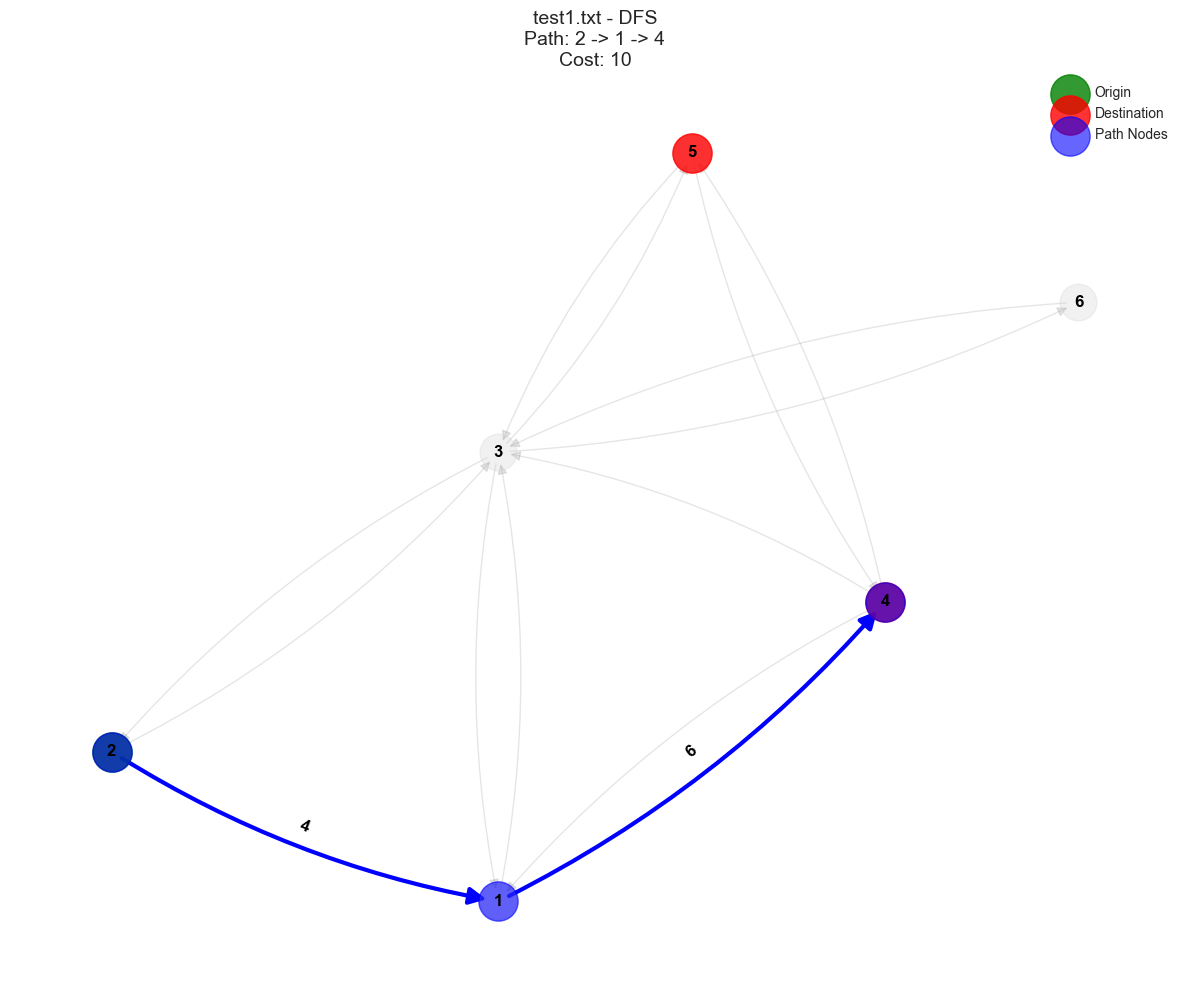

  Running on: test10.txt
Loaded graph with 16 nodes, 70 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 33, Path length: 11, Cost: 44.00
Saved path visualization to test_paths/test10.txt_DFS_path.png


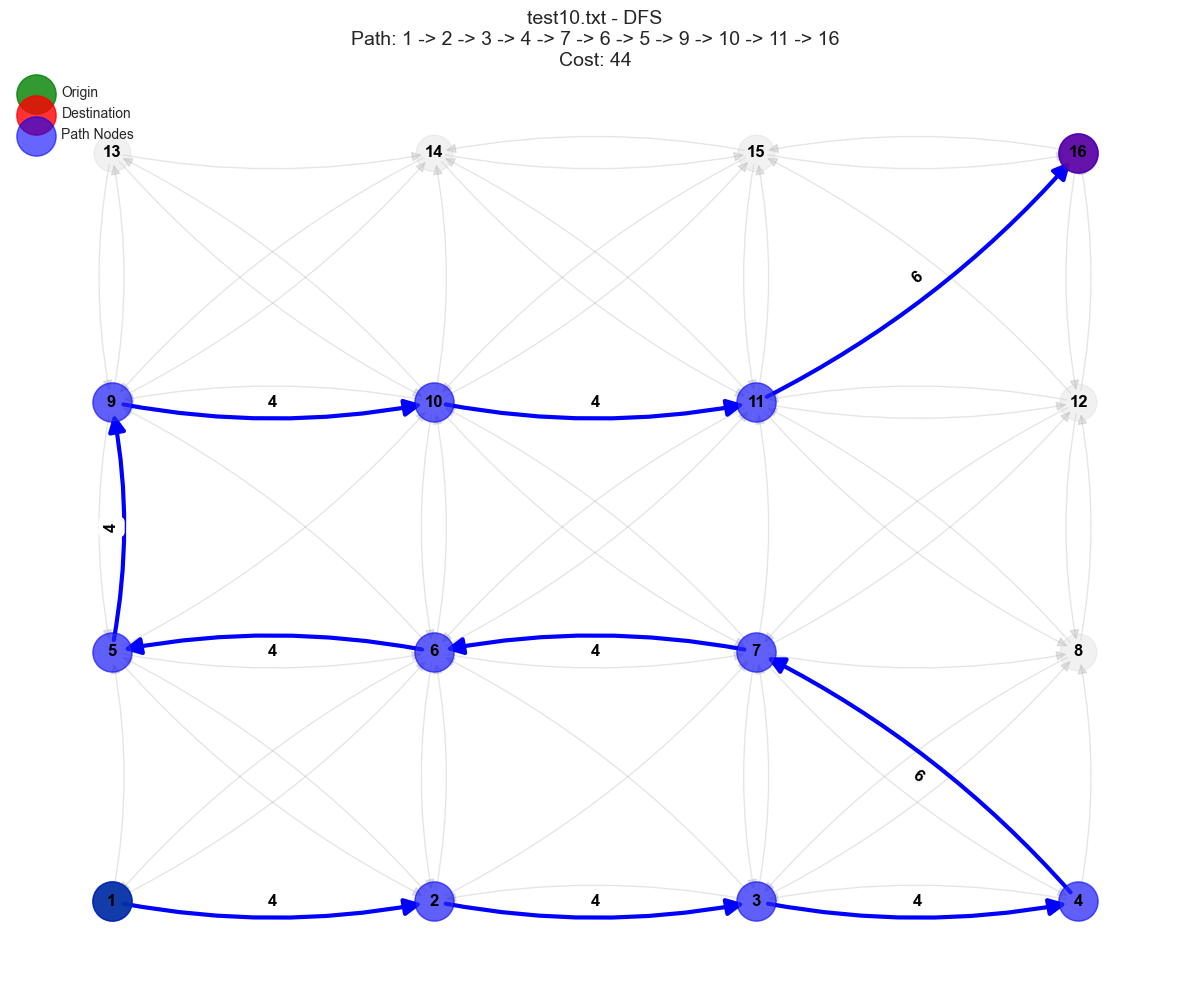

  Running on: test11.txt
Loaded graph with 16 nodes, 80 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 34, Path length: 11, Cost: 31.00
Saved path visualization to test_paths/test11.txt_DFS_path.png


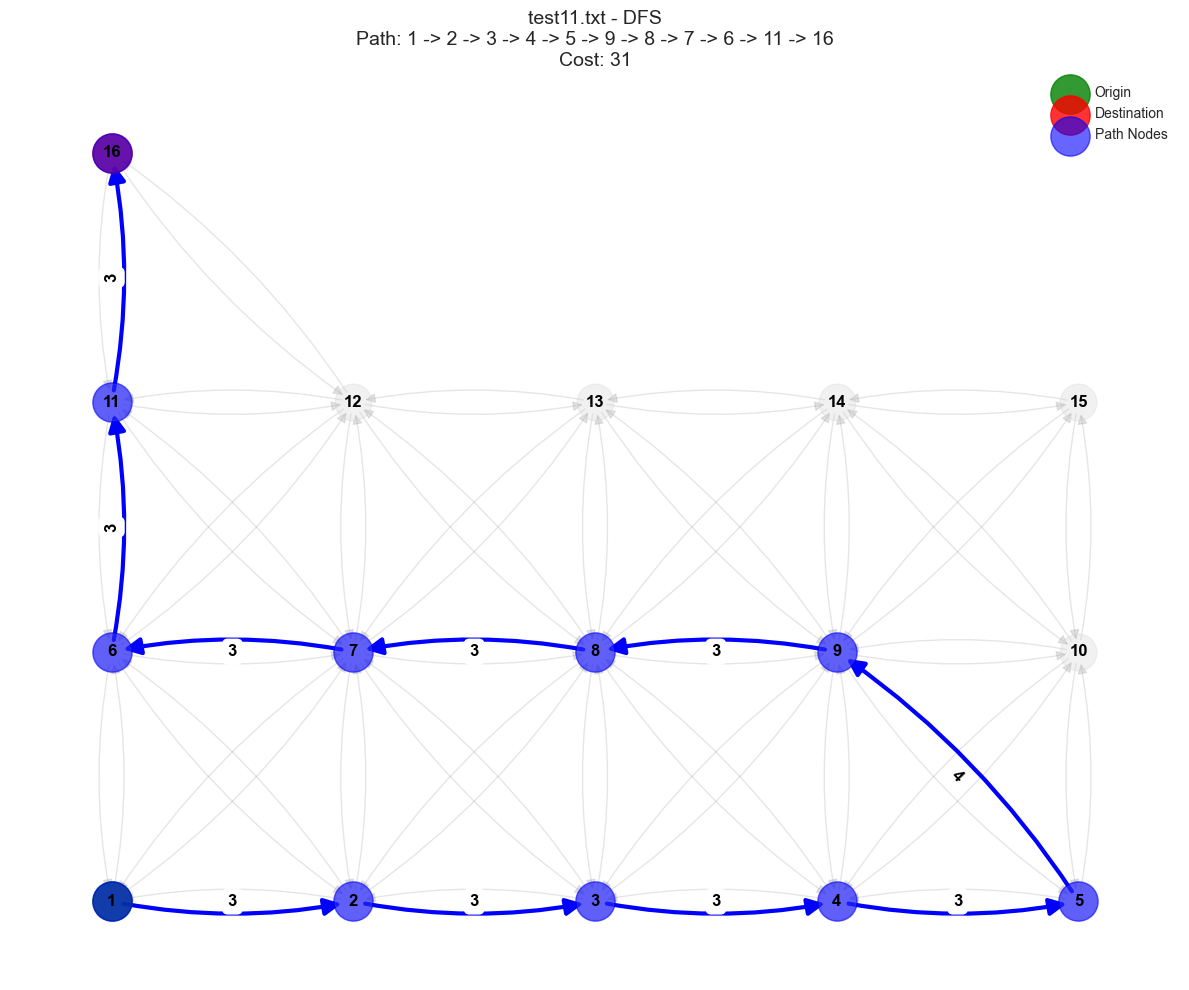

  Running on: test12.txt
Loaded graph with 5 nodes, 7 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 6, Path length: 4, Cost: 12.00
Saved path visualization to test_paths/test12.txt_DFS_path.png


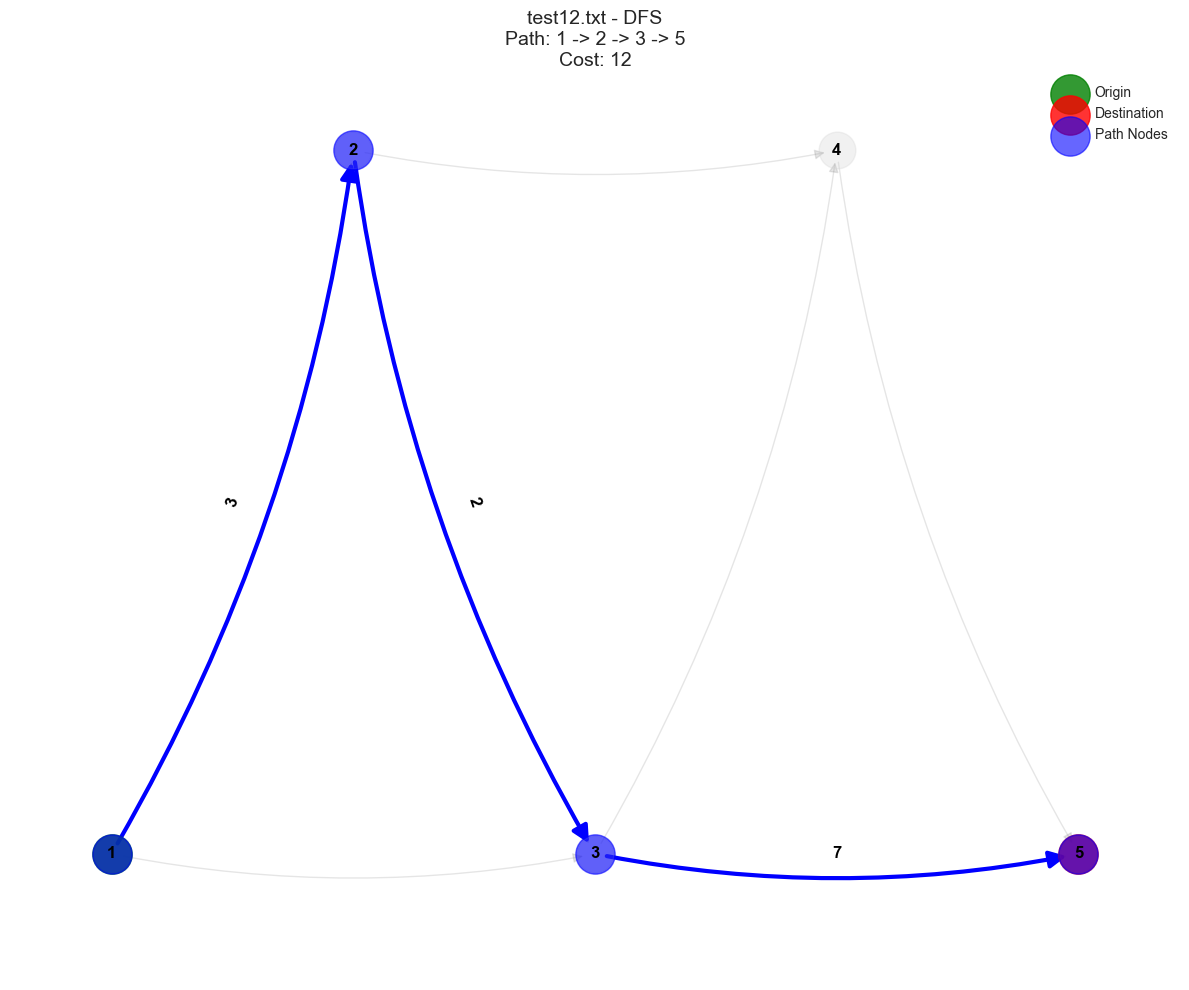

  Running on: test2.txt
Loaded graph with 6 nodes, 11 edges
Origin: 1, Destinations: [4, 5, 6]
    Success! Goal: 5, Nodes created: 4, Path length: 3, Cost: 7.00
Saved path visualization to test_paths/test2.txt_DFS_path.png


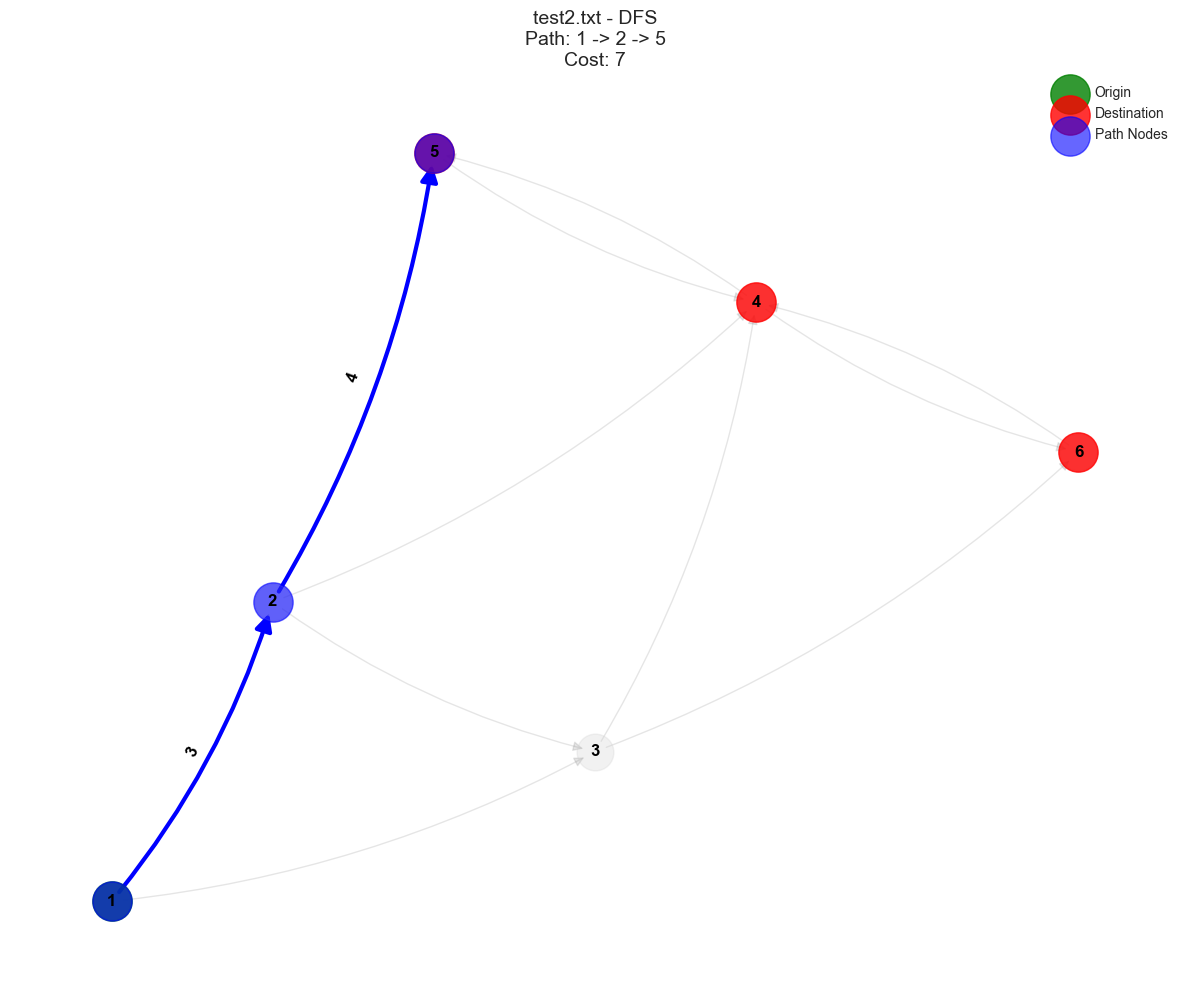

  Running on: test3.txt
Loaded graph with 6 nodes, 7 edges
Origin: 1, Destinations: [6]
    Success! Goal: 6, Nodes created: 5, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test3.txt_DFS_path.png


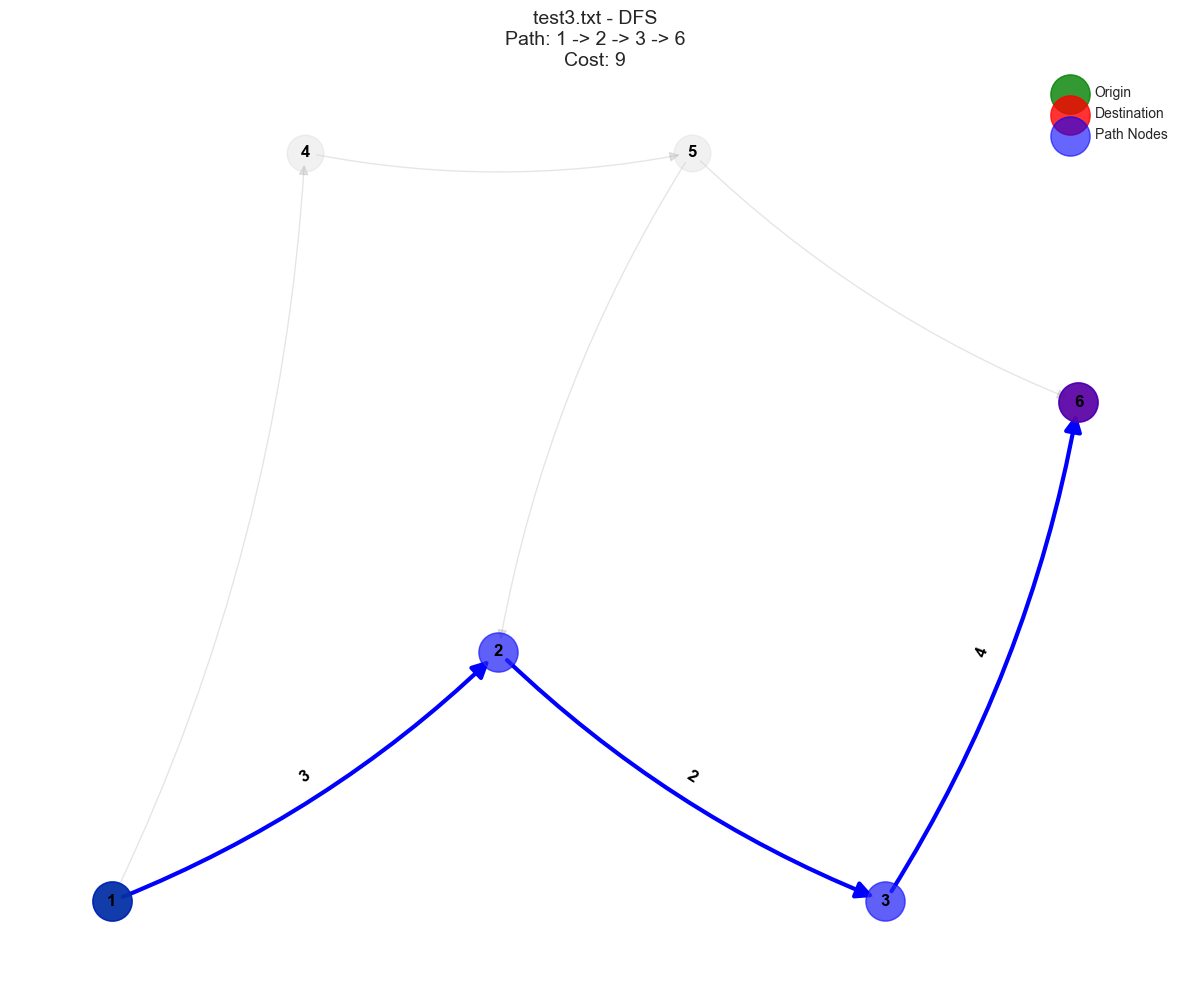

  Running on: test4.txt
Loaded graph with 6 nodes, 4 edges
Origin: 1, Destinations: [6]
    No solution found
  Running on: test5.txt
Loaded graph with 20 nodes, 39 edges
Origin: 1, Destinations: [20]
    Success! Goal: 20, Nodes created: 15, Path length: 7, Cost: 11.00
Saved path visualization to test_paths/test5.txt_DFS_path.png


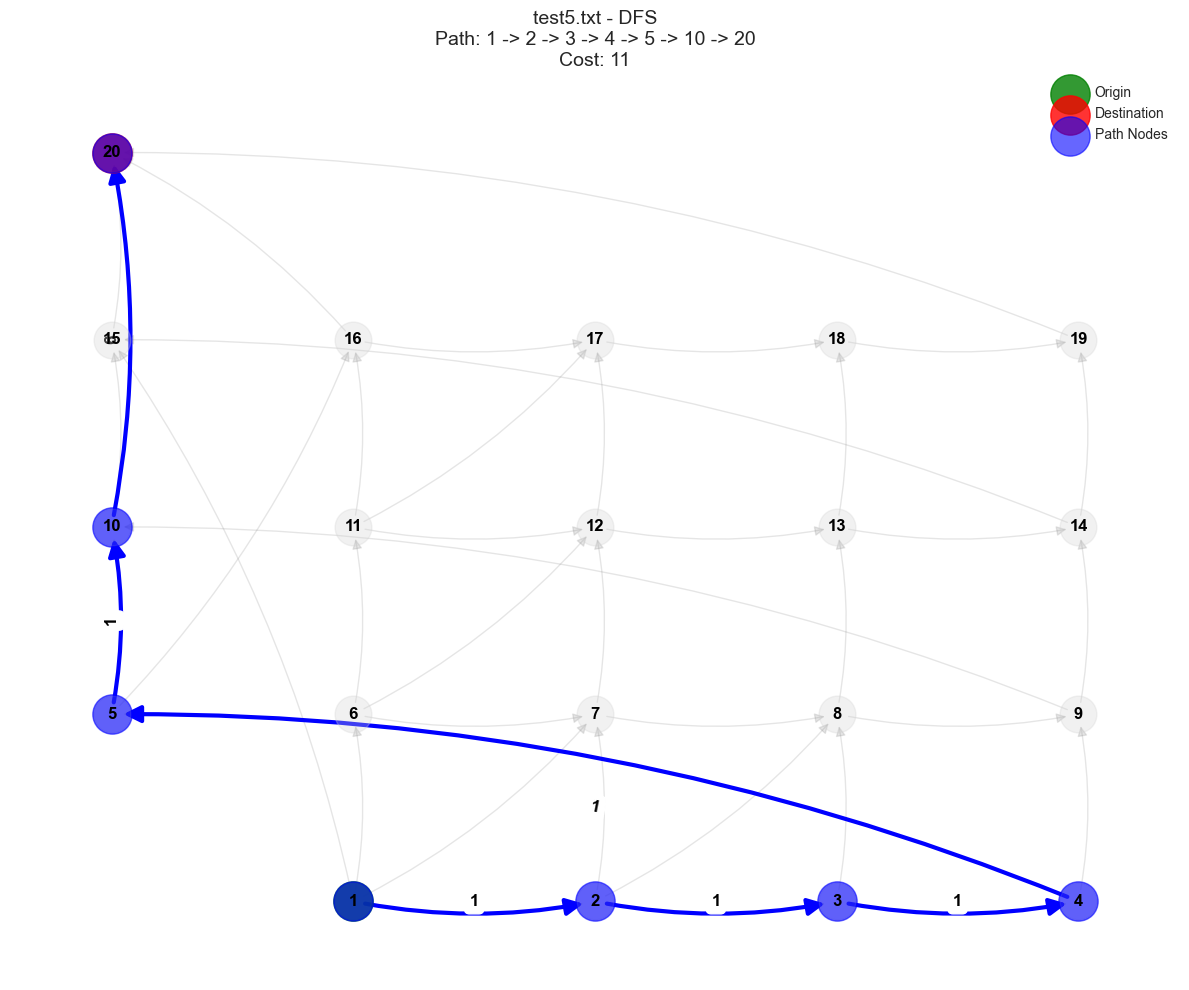

  Running on: test6.txt
Loaded graph with 6 nodes, 6 edges
Origin: 1, Destinations: [5, 6]
    Success! Goal: 6, Nodes created: 5, Path length: 4, Cost: 6.00
Saved path visualization to test_paths/test6.txt_DFS_path.png


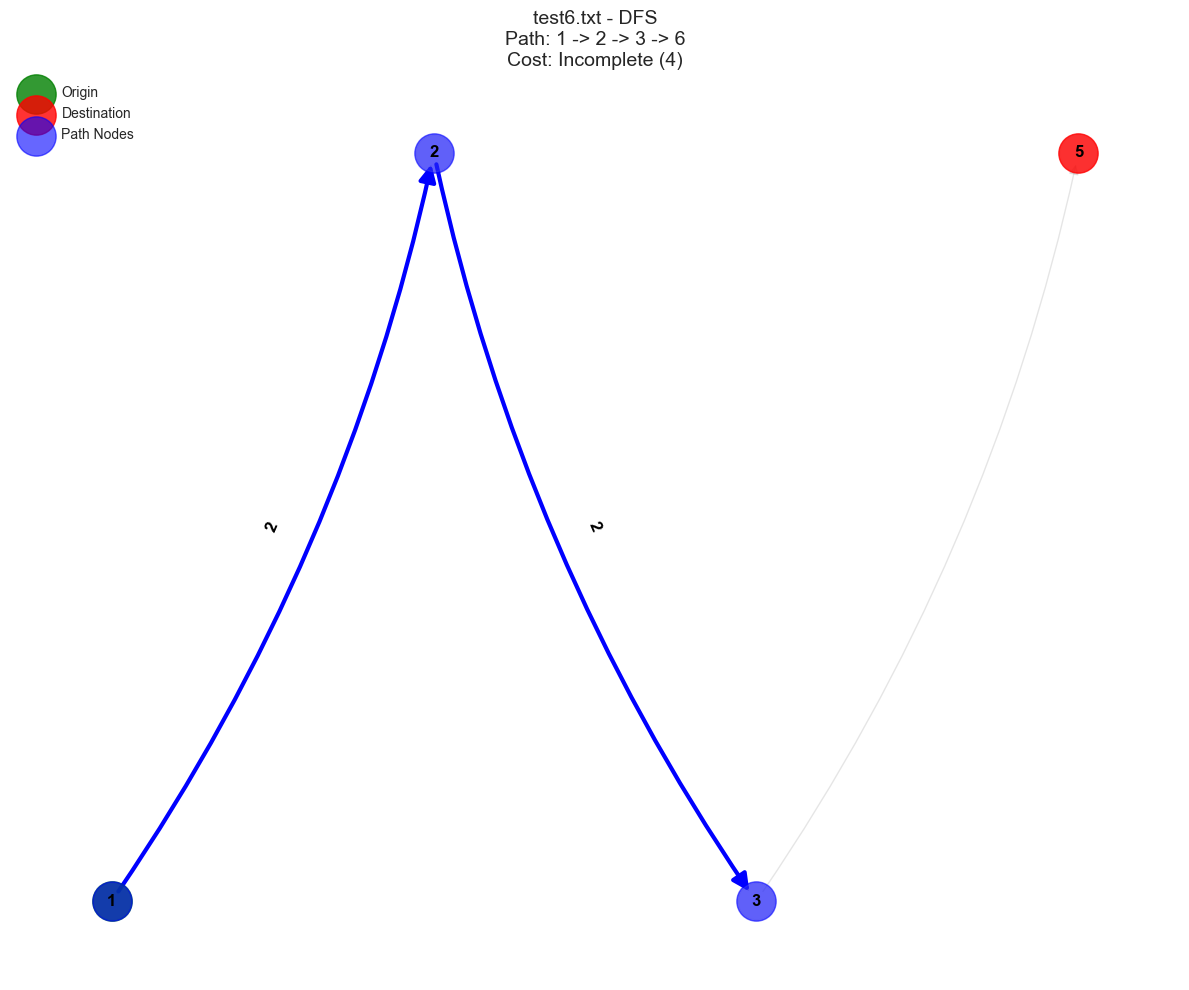

  Running on: test7.txt
Loaded graph with 4 nodes, 2 edges
Origin: 1, Destinations: [4]
    No solution found
  Running on: test8.txt
Loaded graph with 1 nodes, 0 edges
Origin: 1, Destinations: [1]
    Success! Goal: 1, Nodes created: 1, Path length: 1, Cost: 0.00
Saved path visualization to test_paths/test8.txt_DFS_path.png


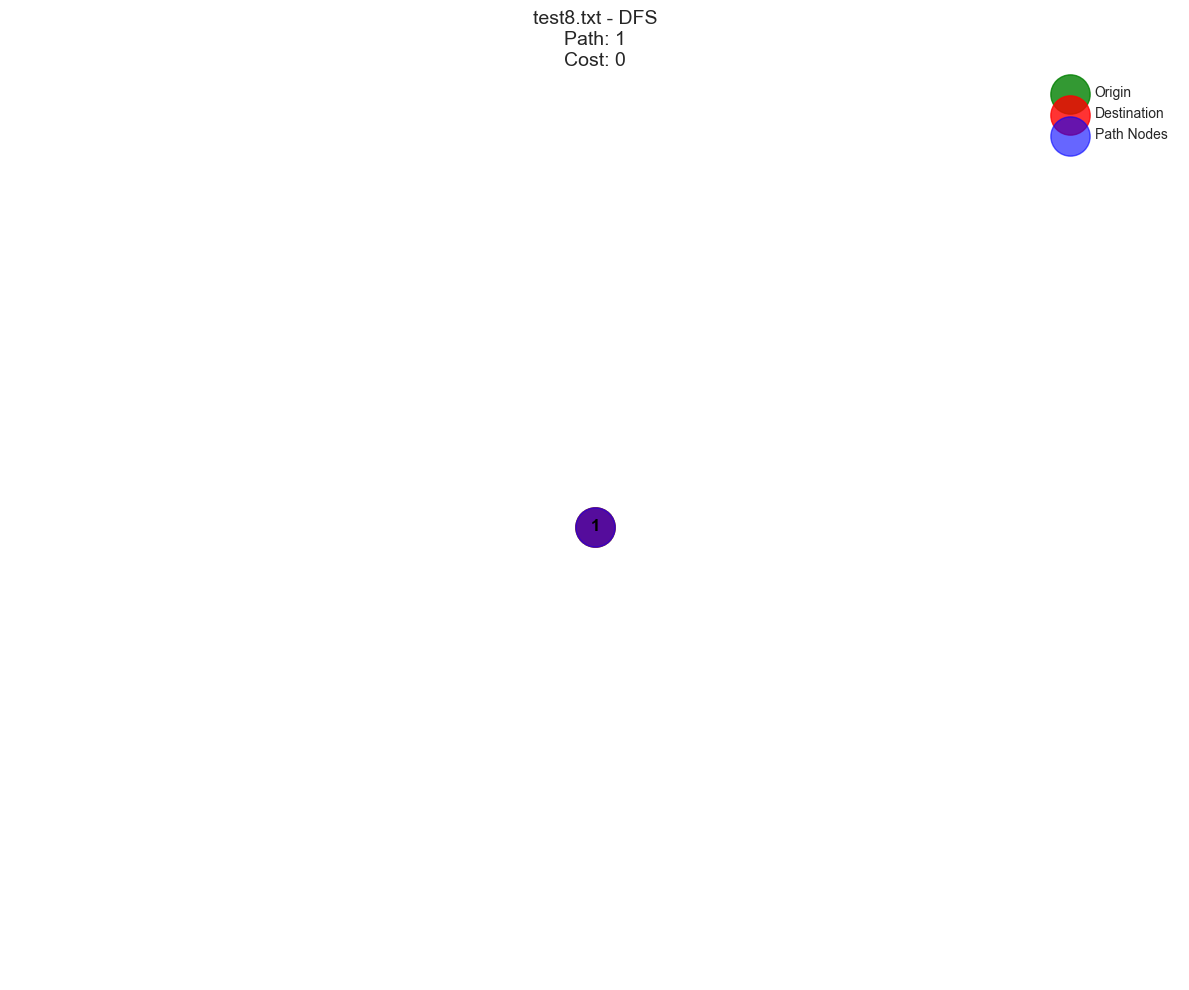

  Running on: test9.txt
Loaded graph with 5 nodes, 5 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 4, Path length: 4, Cost: 4.00
Saved path visualization to test_paths/test9.txt_DFS_path.png


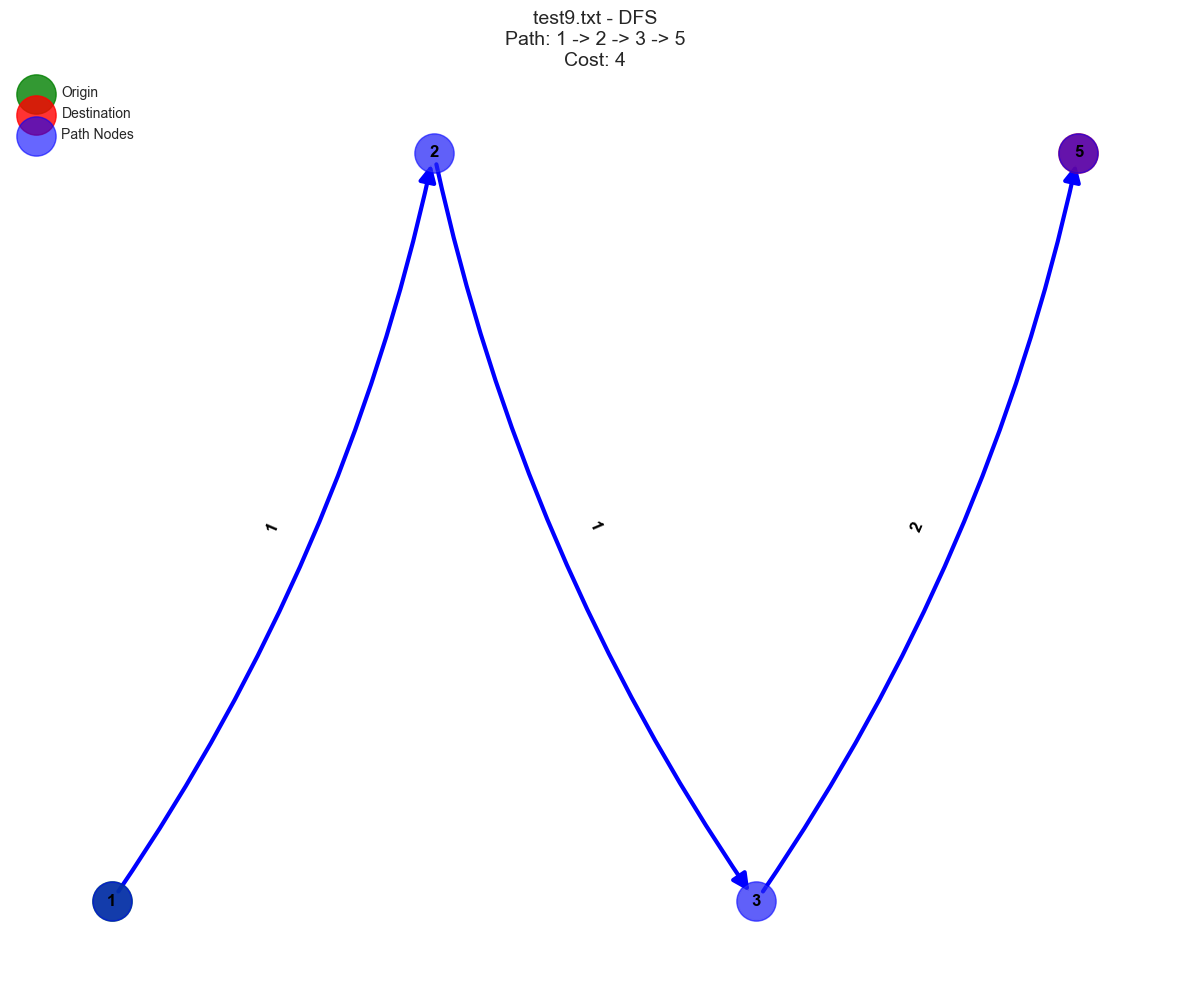


Testing BFS...
  Running on: test1.txt
Loaded graph with 6 nodes, 14 edges
Origin: 2, Destinations: [5, 4]
    Success! Goal: 4, Nodes created: 4, Path length: 3, Cost: 10.00
Saved path visualization to test_paths/test1.txt_BFS_path.png


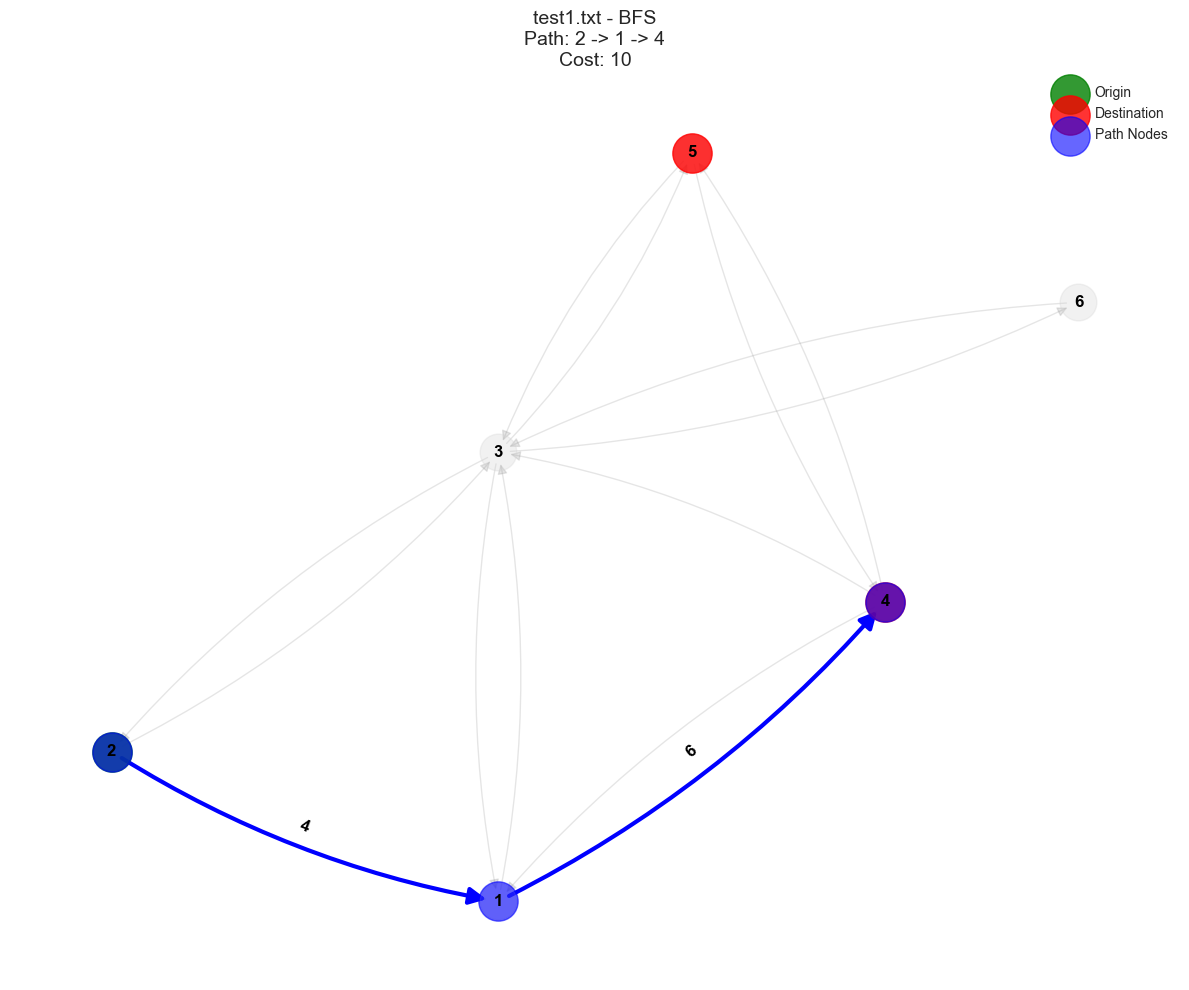

  Running on: test10.txt
Loaded graph with 16 nodes, 70 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 16, Path length: 4, Cost: 18.00
Saved path visualization to test_paths/test10.txt_BFS_path.png


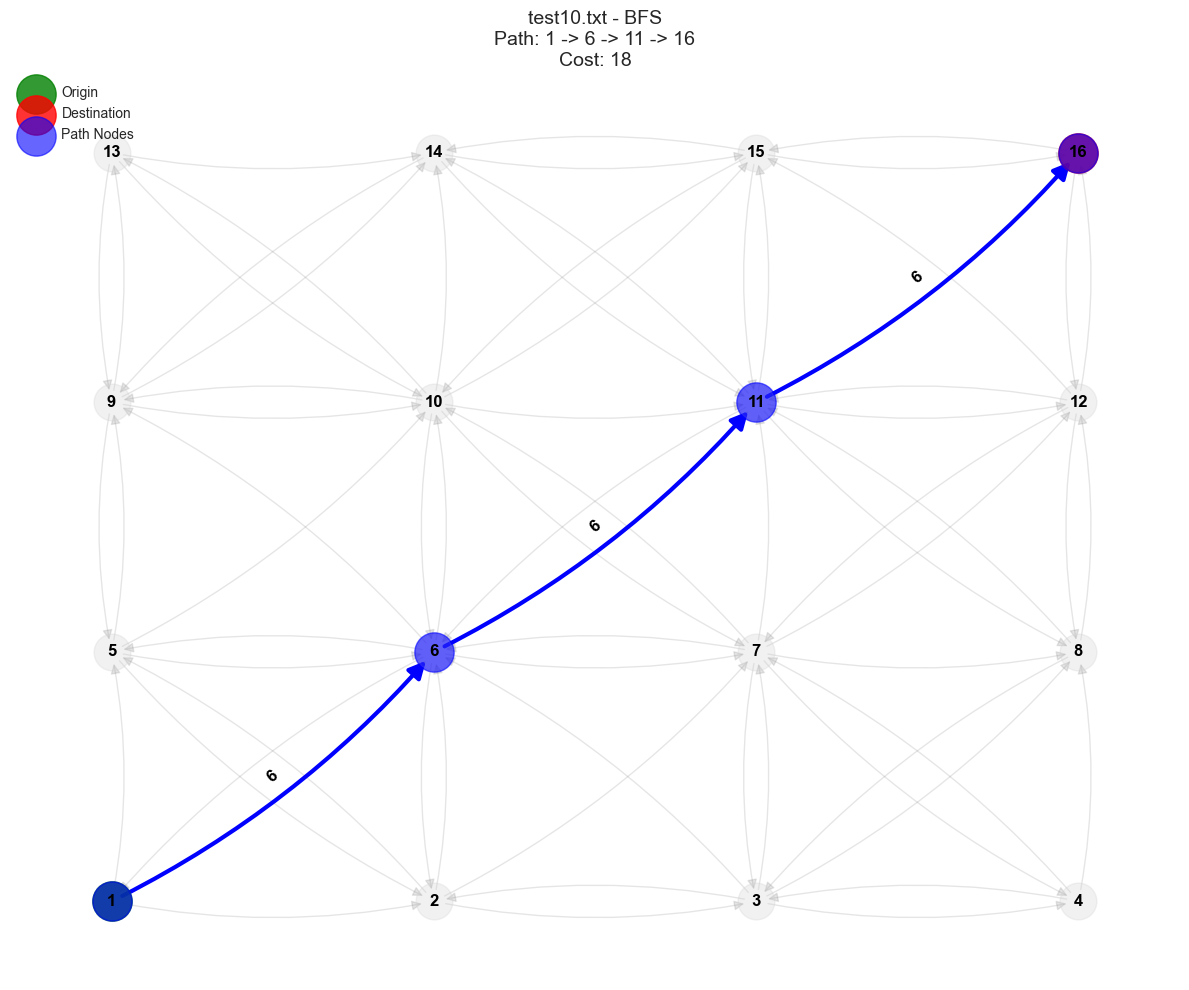

  Running on: test11.txt
Loaded graph with 16 nodes, 80 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 13, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test11.txt_BFS_path.png


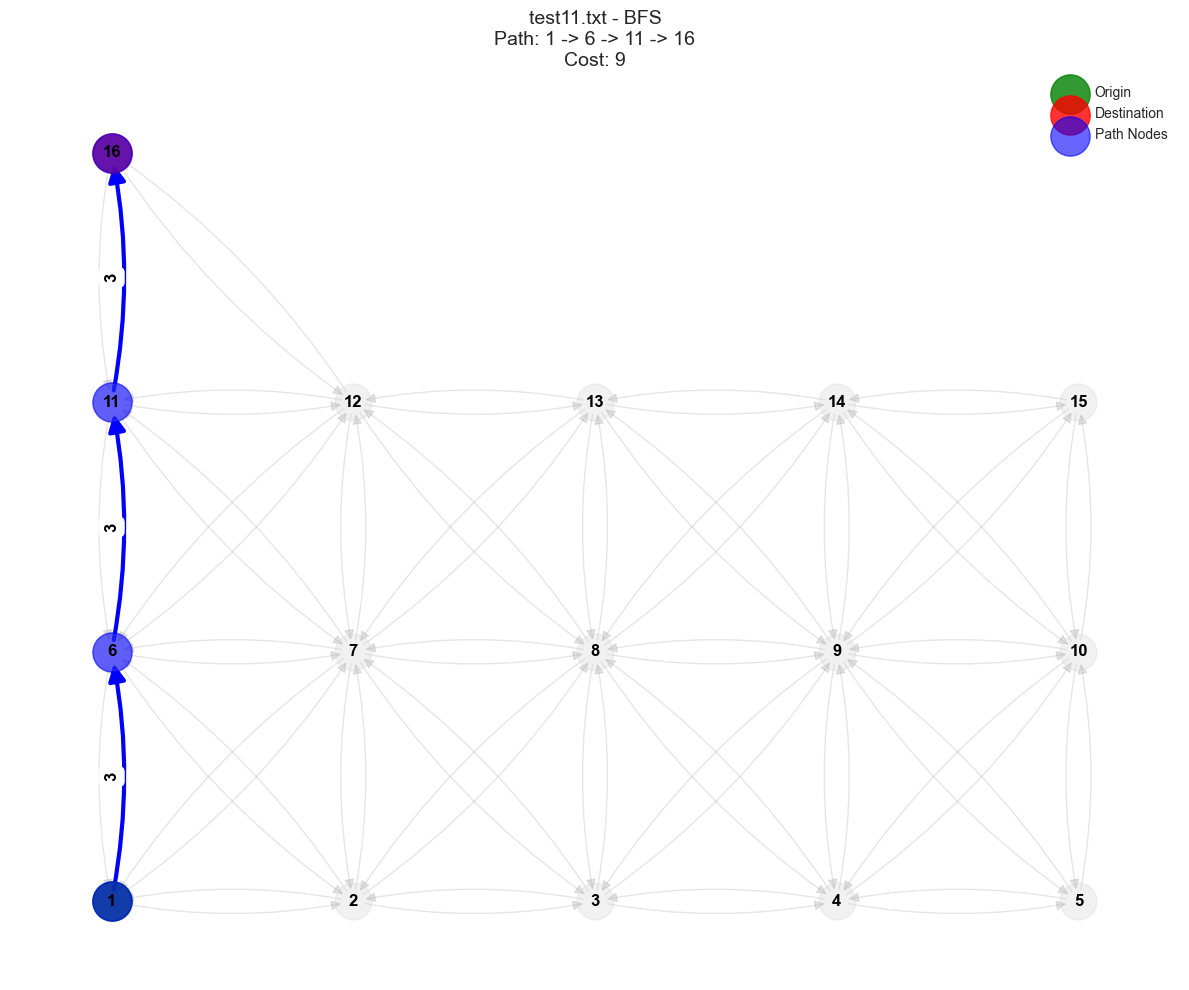

  Running on: test12.txt
Loaded graph with 5 nodes, 7 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 5, Path length: 3, Cost: 13.00
Saved path visualization to test_paths/test12.txt_BFS_path.png


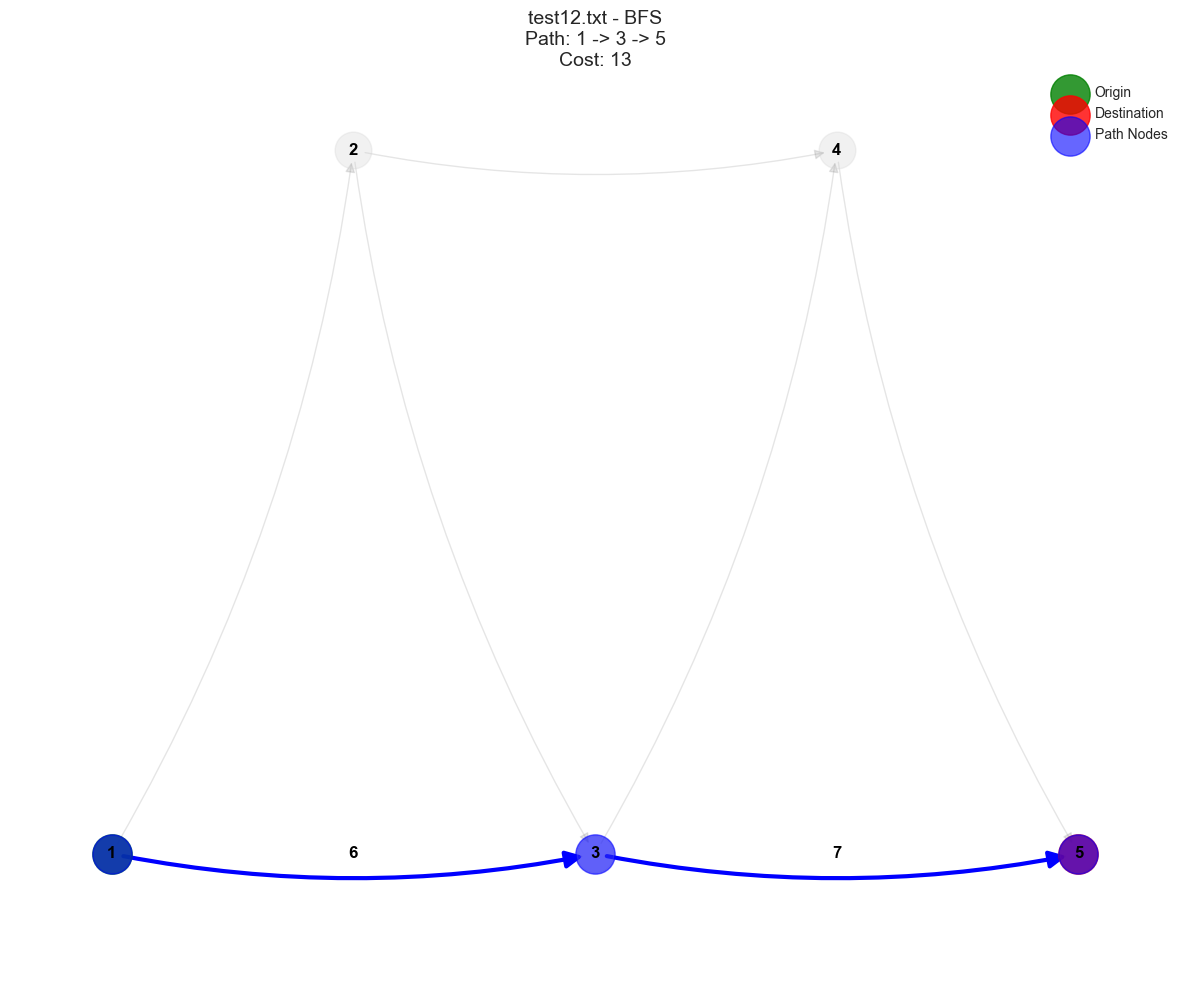

  Running on: test2.txt
Loaded graph with 6 nodes, 11 edges
Origin: 1, Destinations: [4, 5, 6]
    Success! Goal: 4, Nodes created: 4, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test2.txt_BFS_path.png


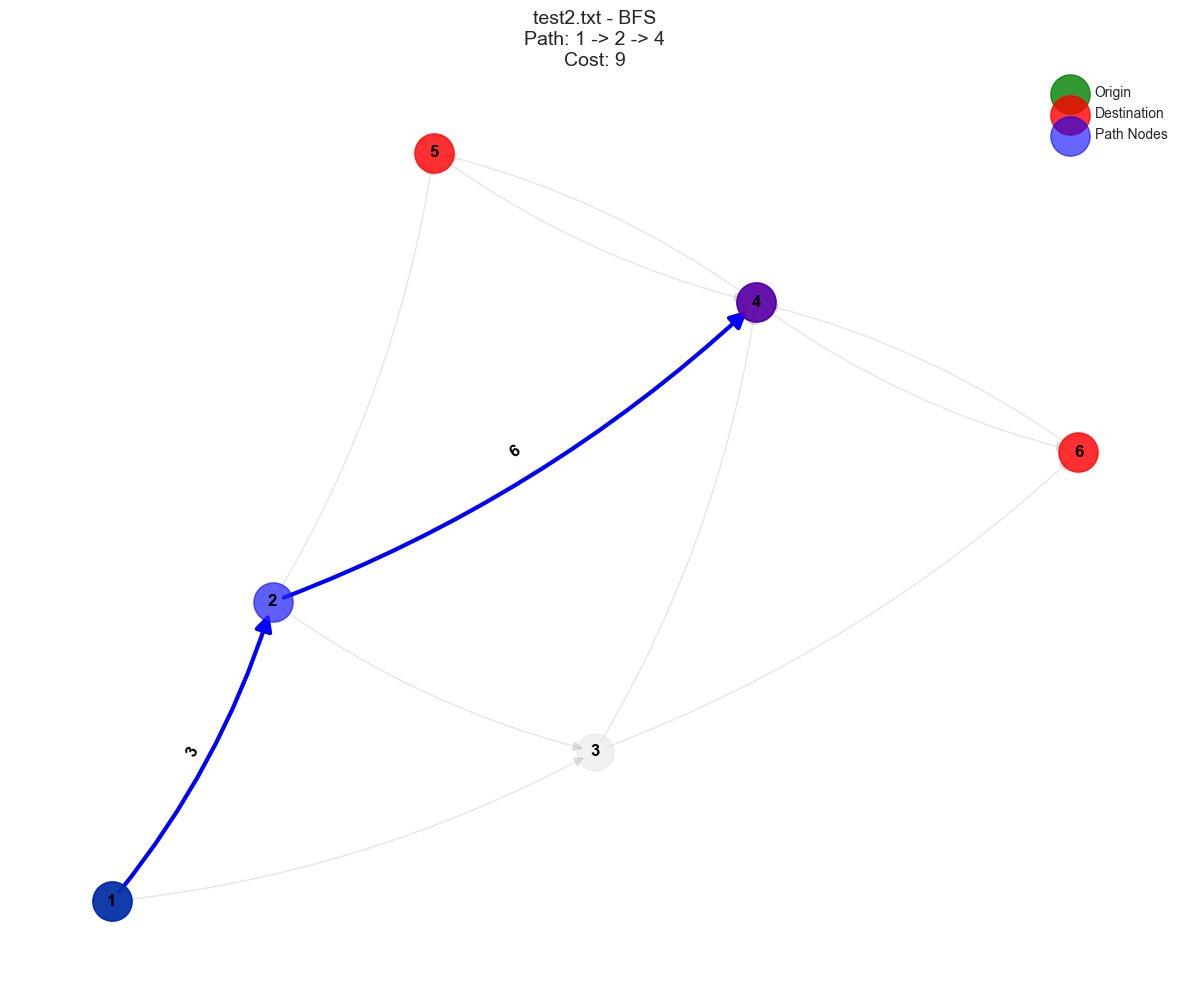

  Running on: test3.txt
Loaded graph with 6 nodes, 7 edges
Origin: 1, Destinations: [6]
    Success! Goal: 6, Nodes created: 6, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test3.txt_BFS_path.png


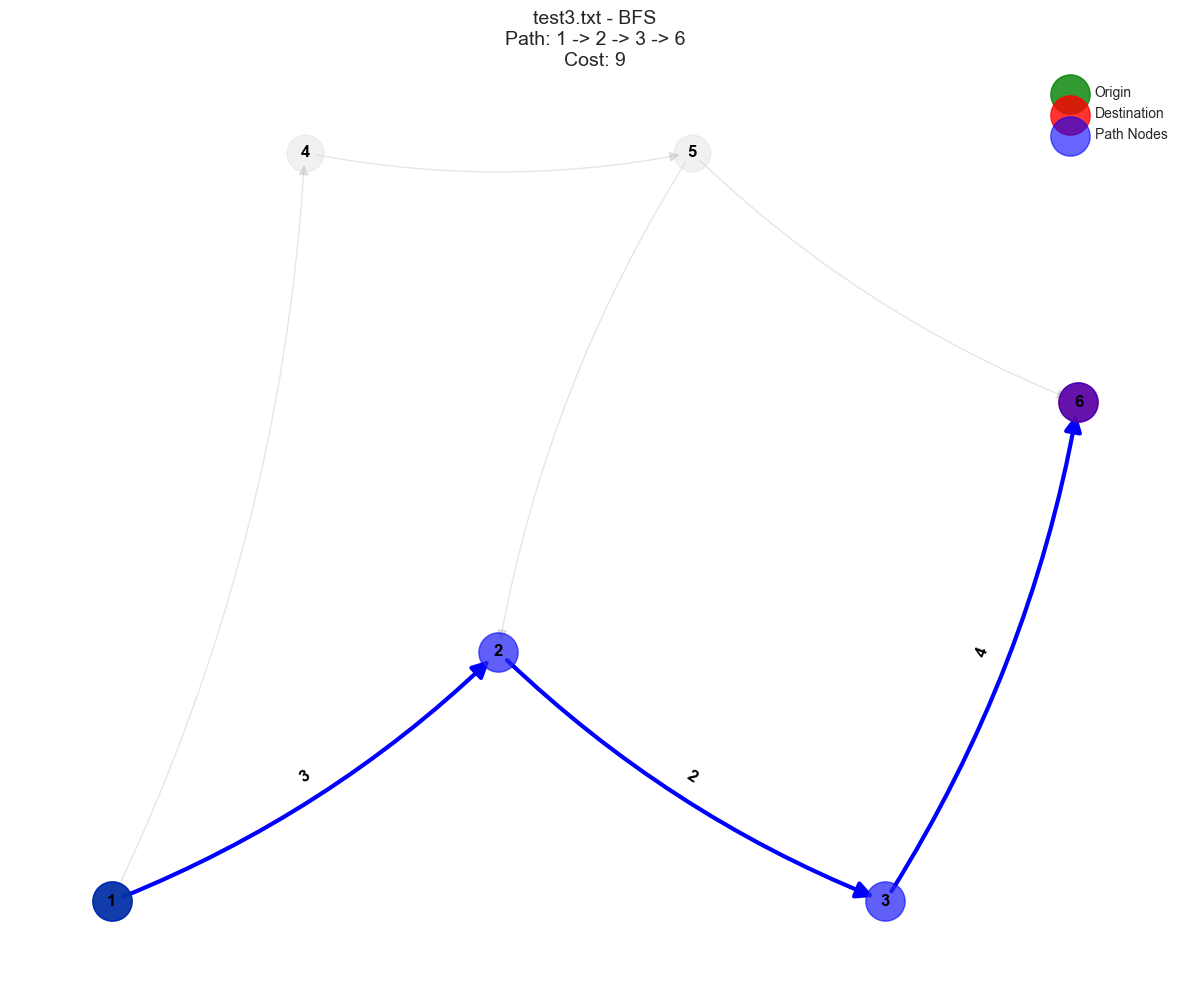

  Running on: test4.txt
Loaded graph with 6 nodes, 4 edges
Origin: 1, Destinations: [6]
    No solution found
  Running on: test5.txt
Loaded graph with 20 nodes, 39 edges
Origin: 1, Destinations: [20]
    Success! Goal: 20, Nodes created: 10, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test5.txt_BFS_path.png


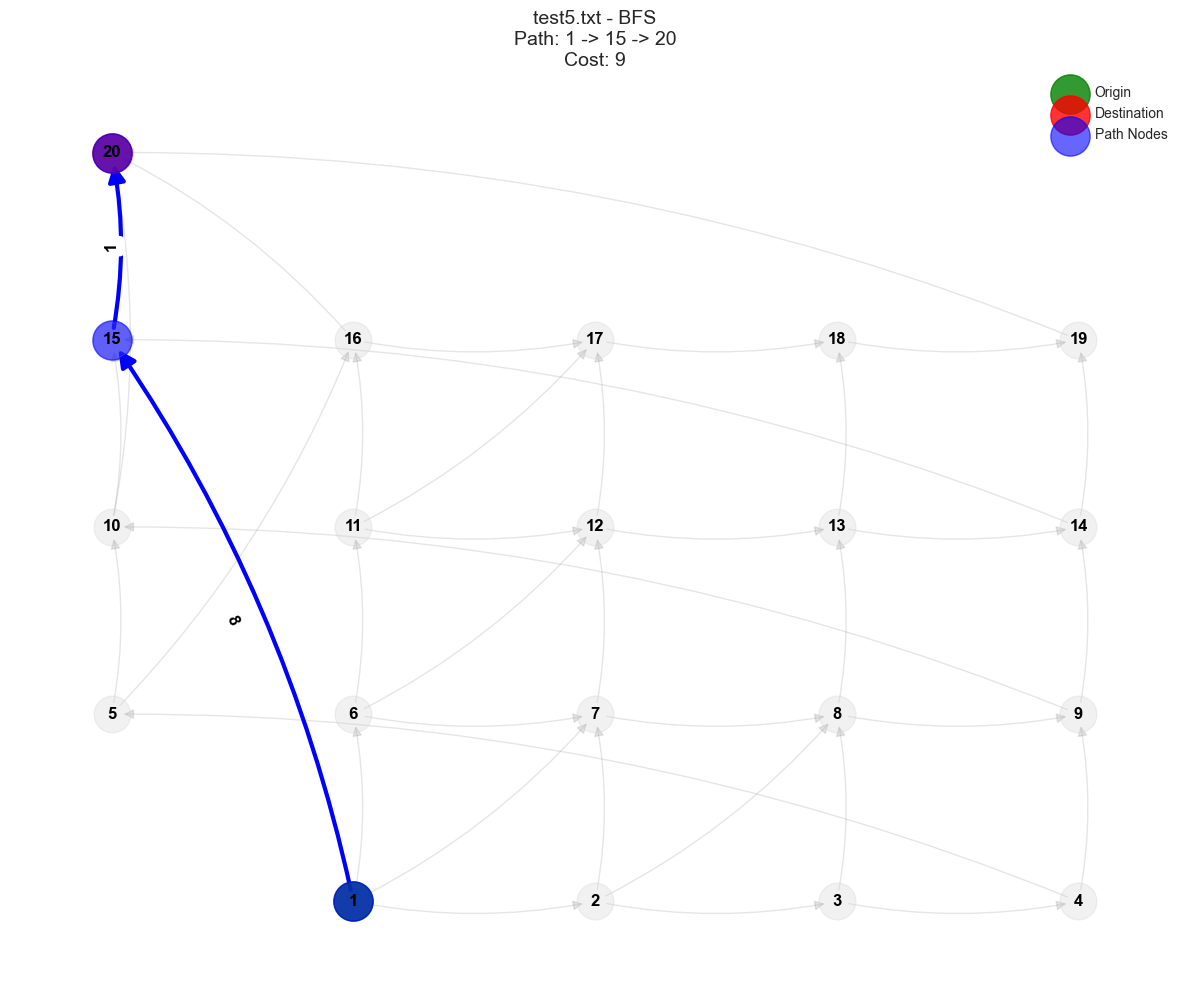

  Running on: test6.txt
Loaded graph with 6 nodes, 6 edges
Origin: 1, Destinations: [5, 6]
    Success! Goal: 5, Nodes created: 5, Path length: 4, Cost: 6.00
Saved path visualization to test_paths/test6.txt_BFS_path.png


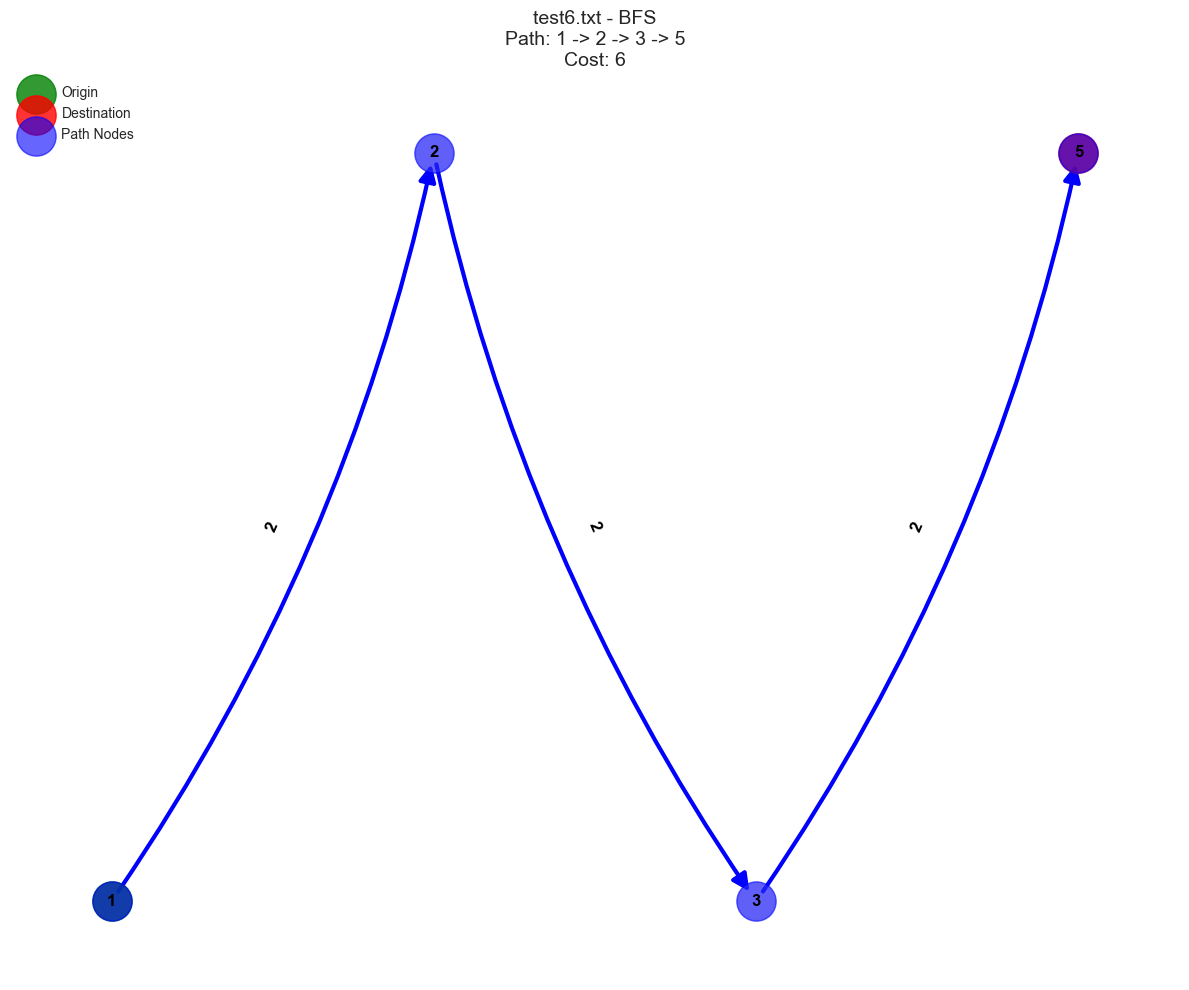

  Running on: test7.txt
Loaded graph with 4 nodes, 2 edges
Origin: 1, Destinations: [4]
    No solution found
  Running on: test8.txt
Loaded graph with 1 nodes, 0 edges
Origin: 1, Destinations: [1]
    Success! Goal: 1, Nodes created: 1, Path length: 1, Cost: 0.00
Saved path visualization to test_paths/test8.txt_BFS_path.png


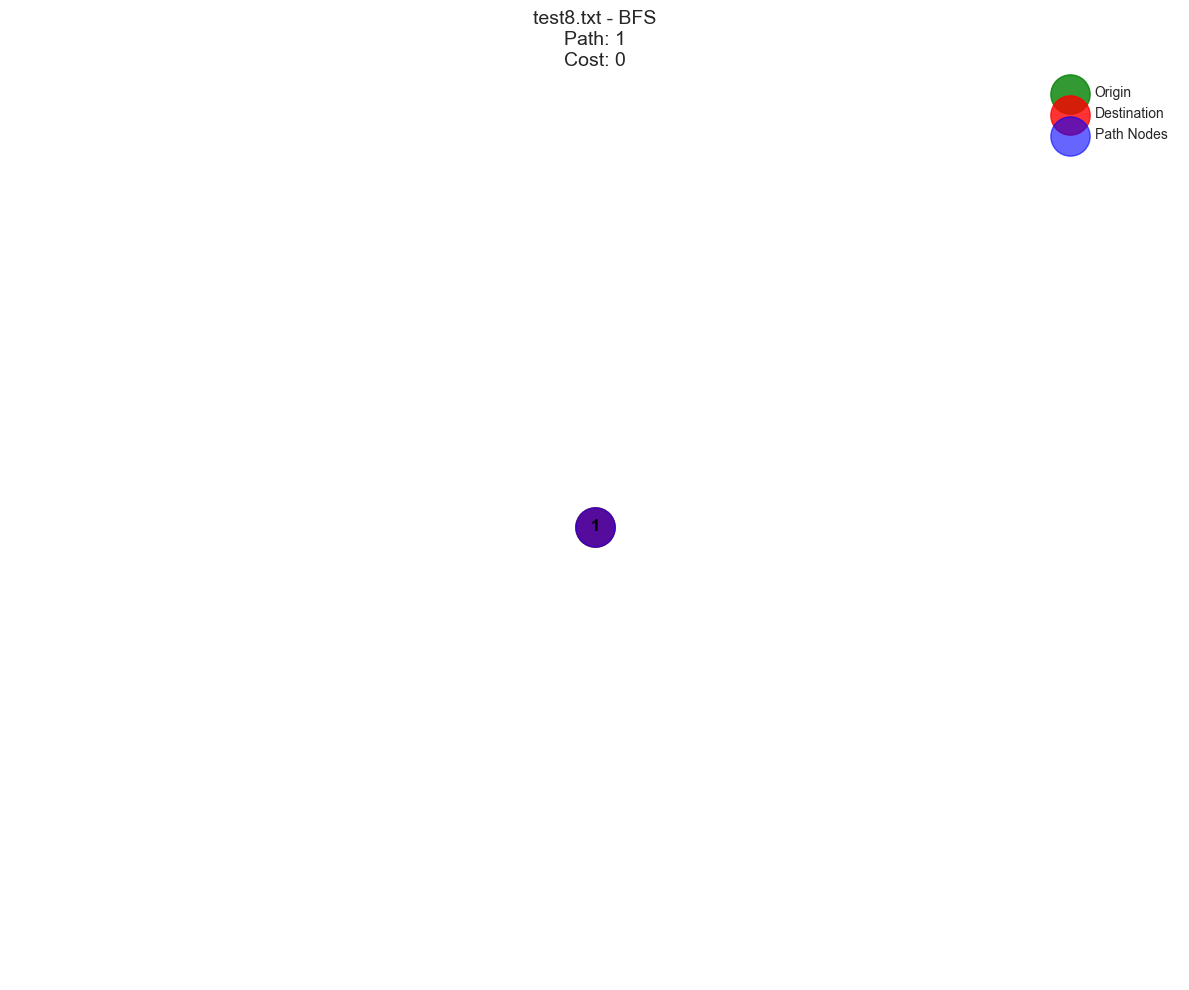

  Running on: test9.txt
Loaded graph with 5 nodes, 5 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 5, Path length: 4, Cost: 4.00
Saved path visualization to test_paths/test9.txt_BFS_path.png


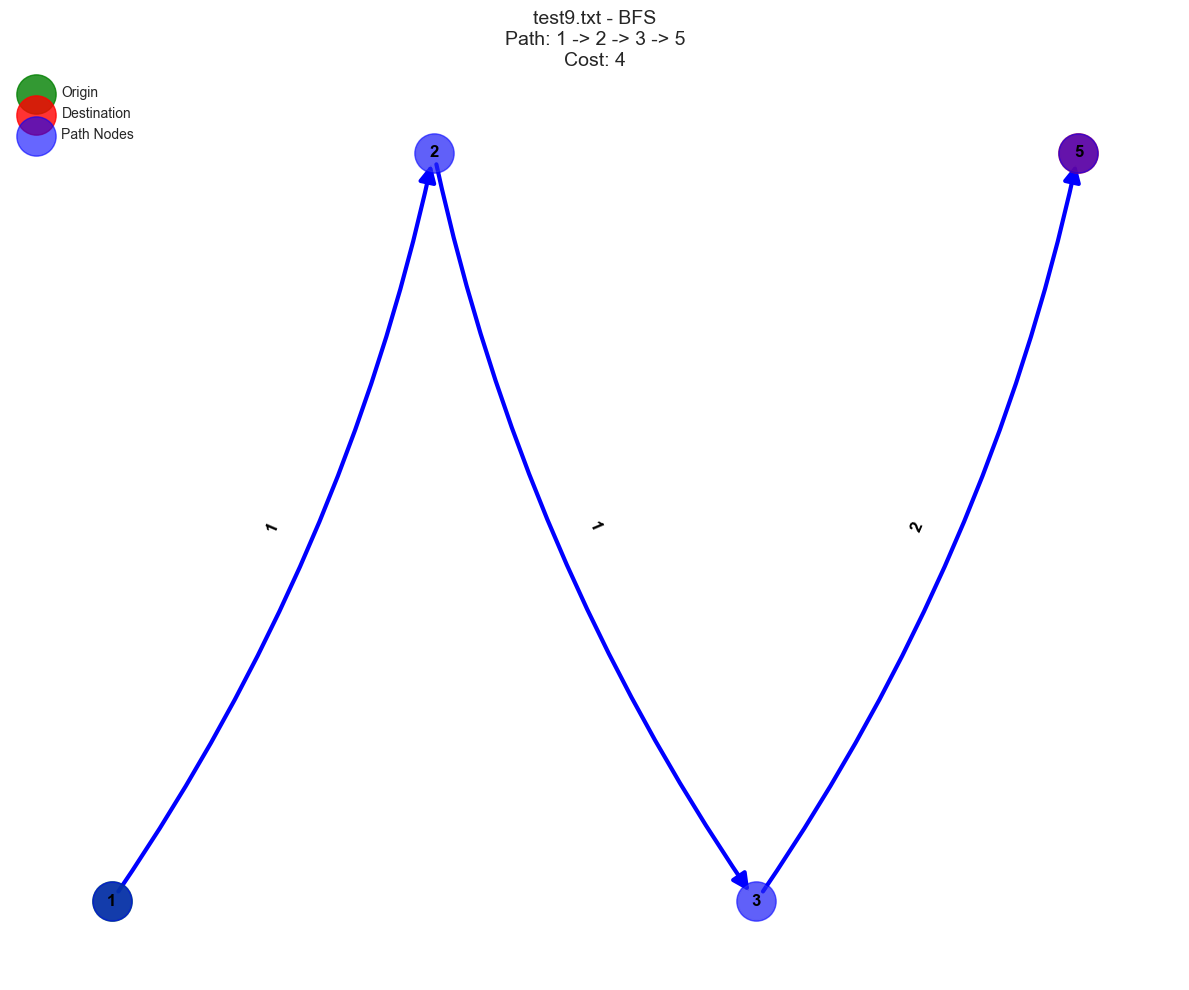


Testing GBFS...
  Running on: test1.txt
Loaded graph with 6 nodes, 14 edges
Origin: 2, Destinations: [5, 4]
    Success! Goal: 5, Nodes created: 5, Path length: 3, Cost: 10.00
Saved path visualization to test_paths/test1.txt_GBFS_path.png


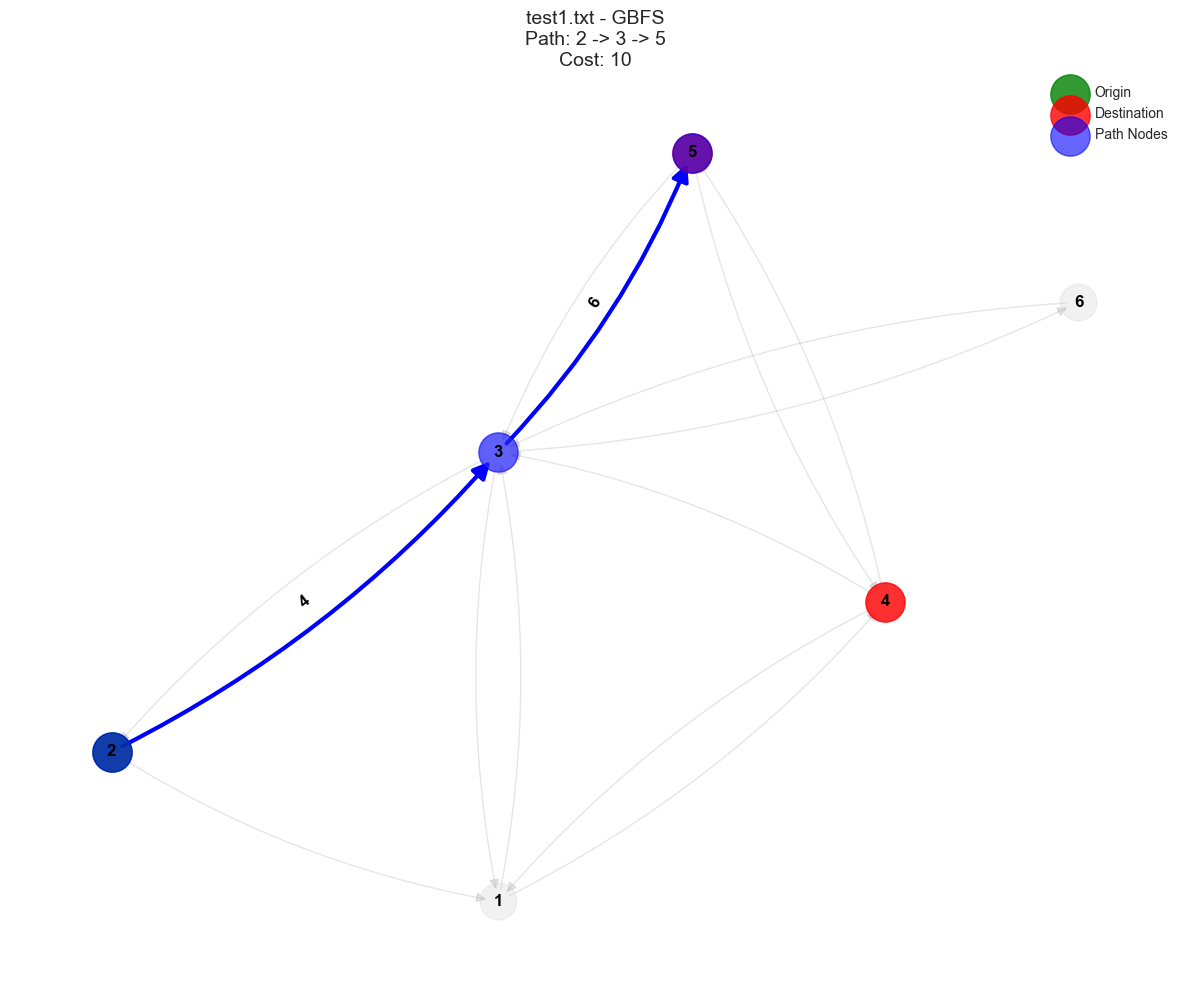

  Running on: test10.txt
Loaded graph with 16 nodes, 70 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 13, Path length: 4, Cost: 18.00
Saved path visualization to test_paths/test10.txt_GBFS_path.png


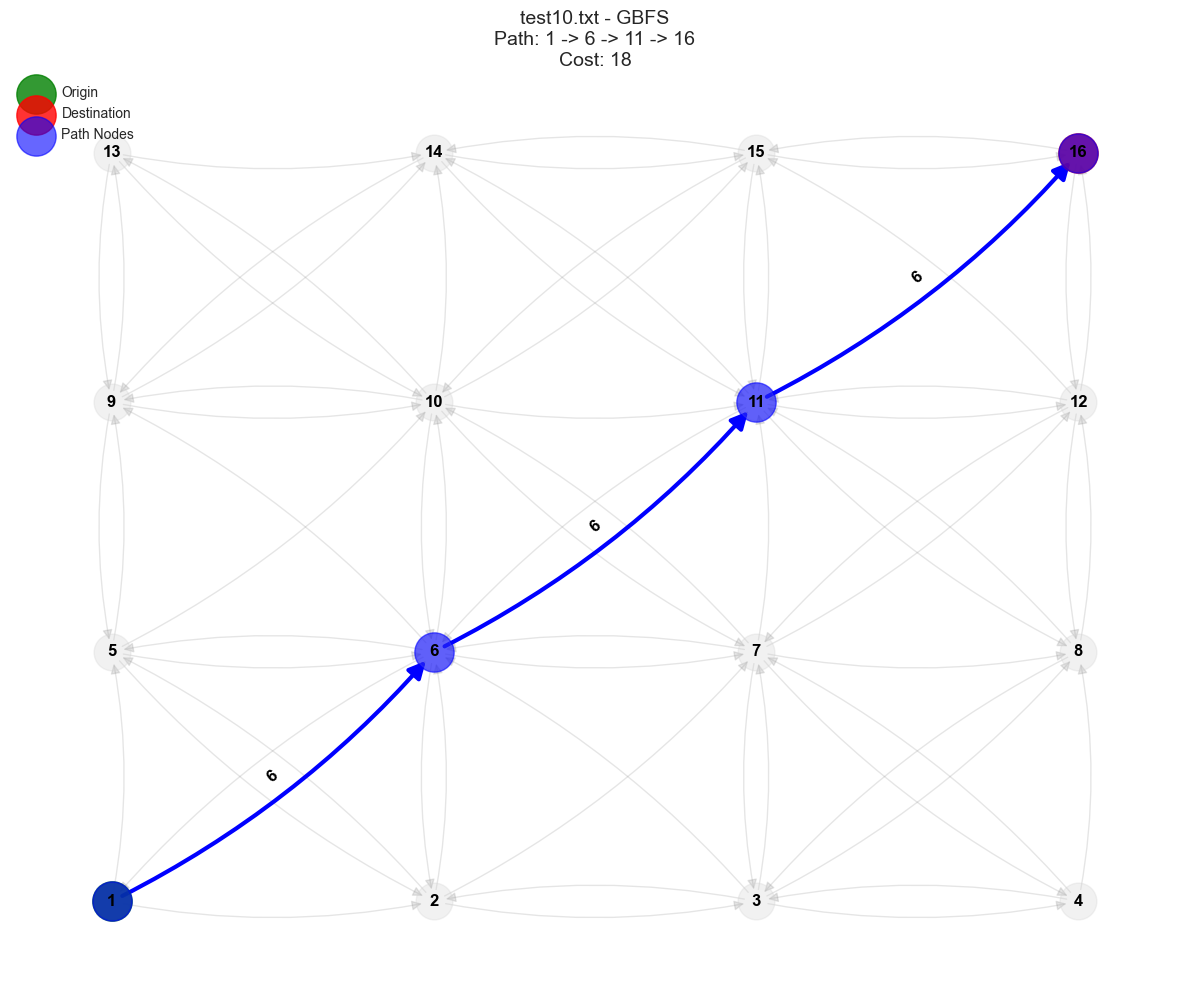

  Running on: test11.txt
Loaded graph with 16 nodes, 80 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 7, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test11.txt_GBFS_path.png


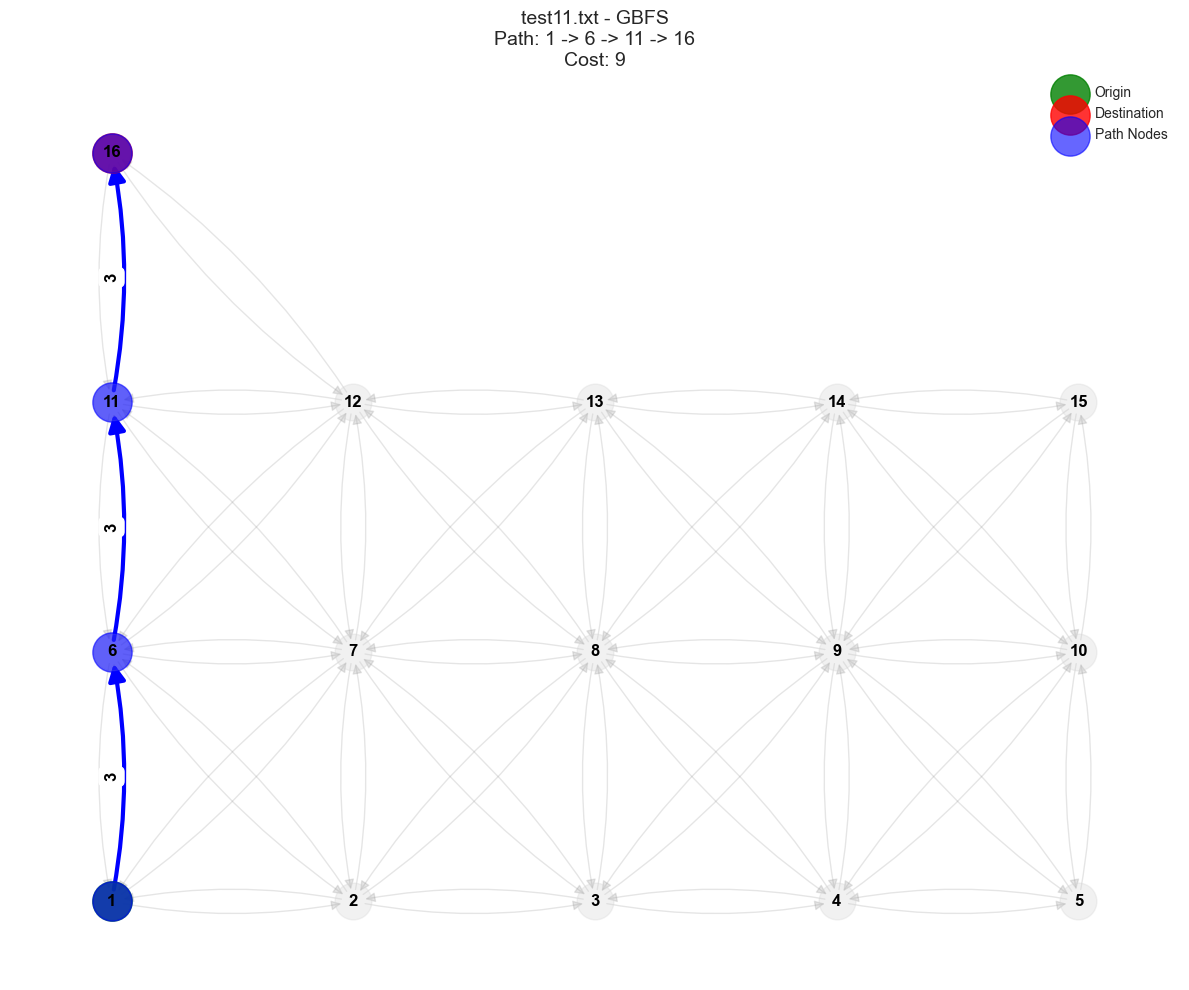

  Running on: test12.txt
Loaded graph with 5 nodes, 7 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 5, Path length: 3, Cost: 13.00
Saved path visualization to test_paths/test12.txt_GBFS_path.png


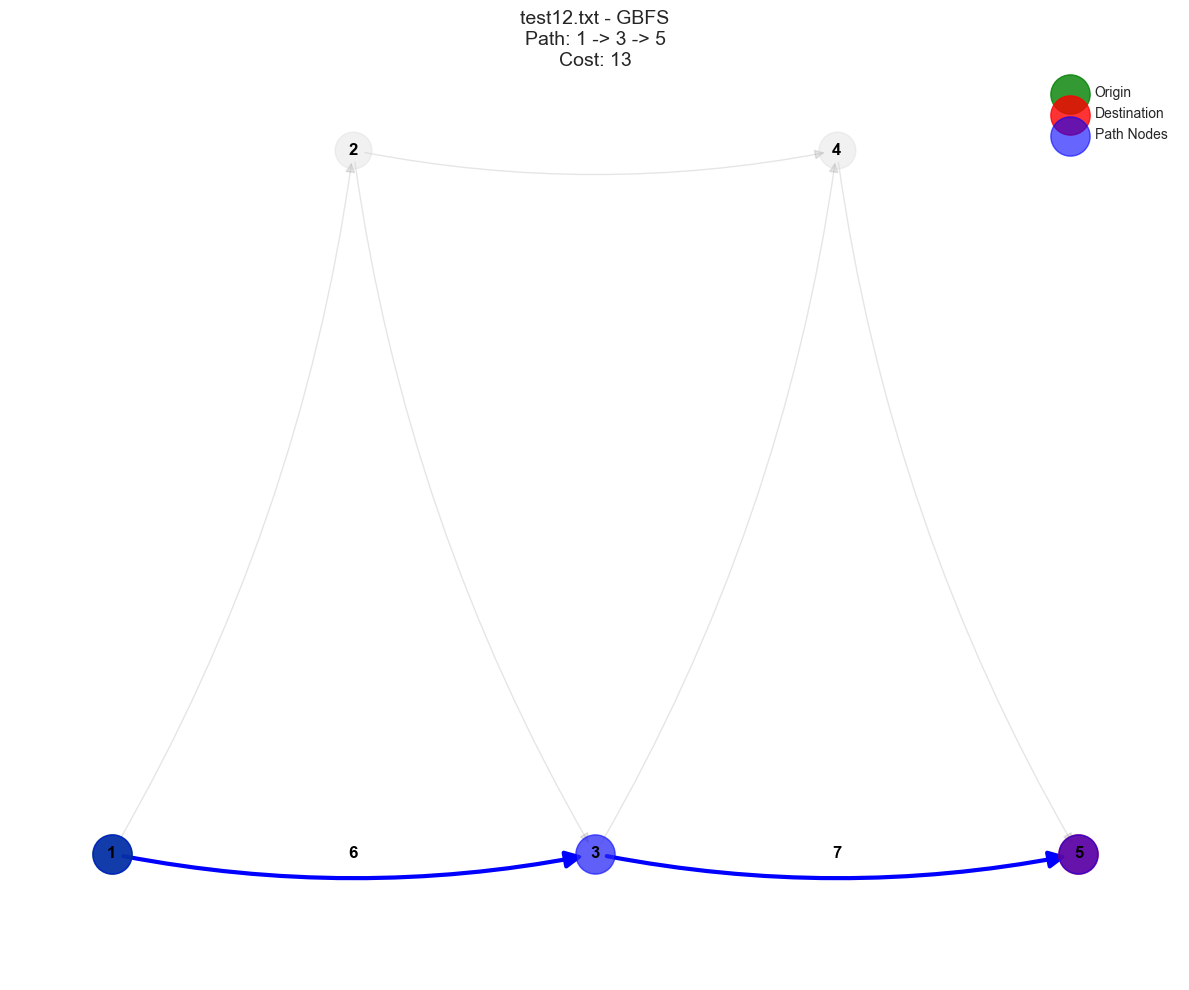

  Running on: test2.txt
Loaded graph with 6 nodes, 11 edges
Origin: 1, Destinations: [4, 5, 6]
    Success! Goal: 6, Nodes created: 5, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test2.txt_GBFS_path.png


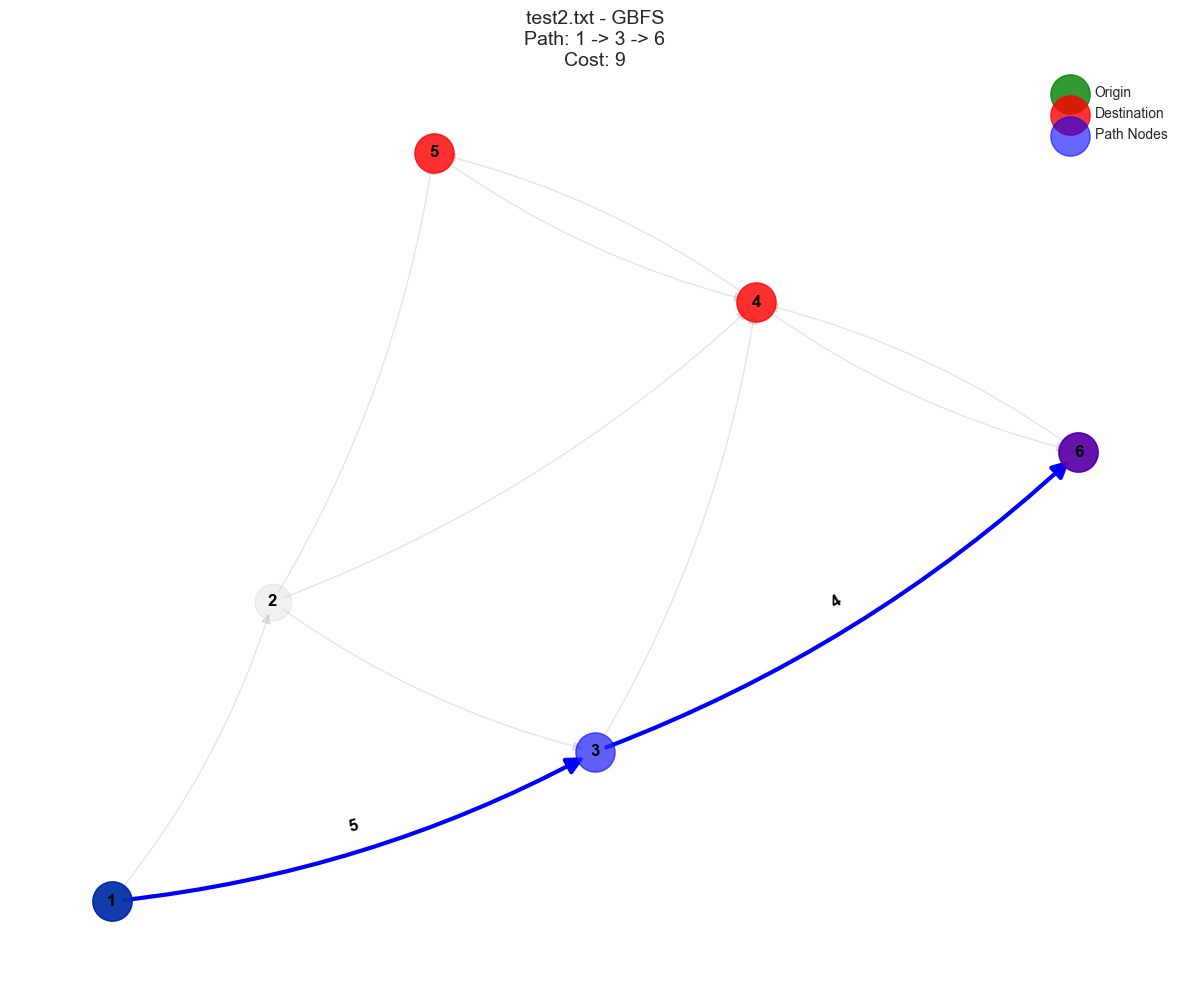

  Running on: test3.txt
Loaded graph with 6 nodes, 7 edges
Origin: 1, Destinations: [6]
    Success! Goal: 6, Nodes created: 5, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test3.txt_GBFS_path.png


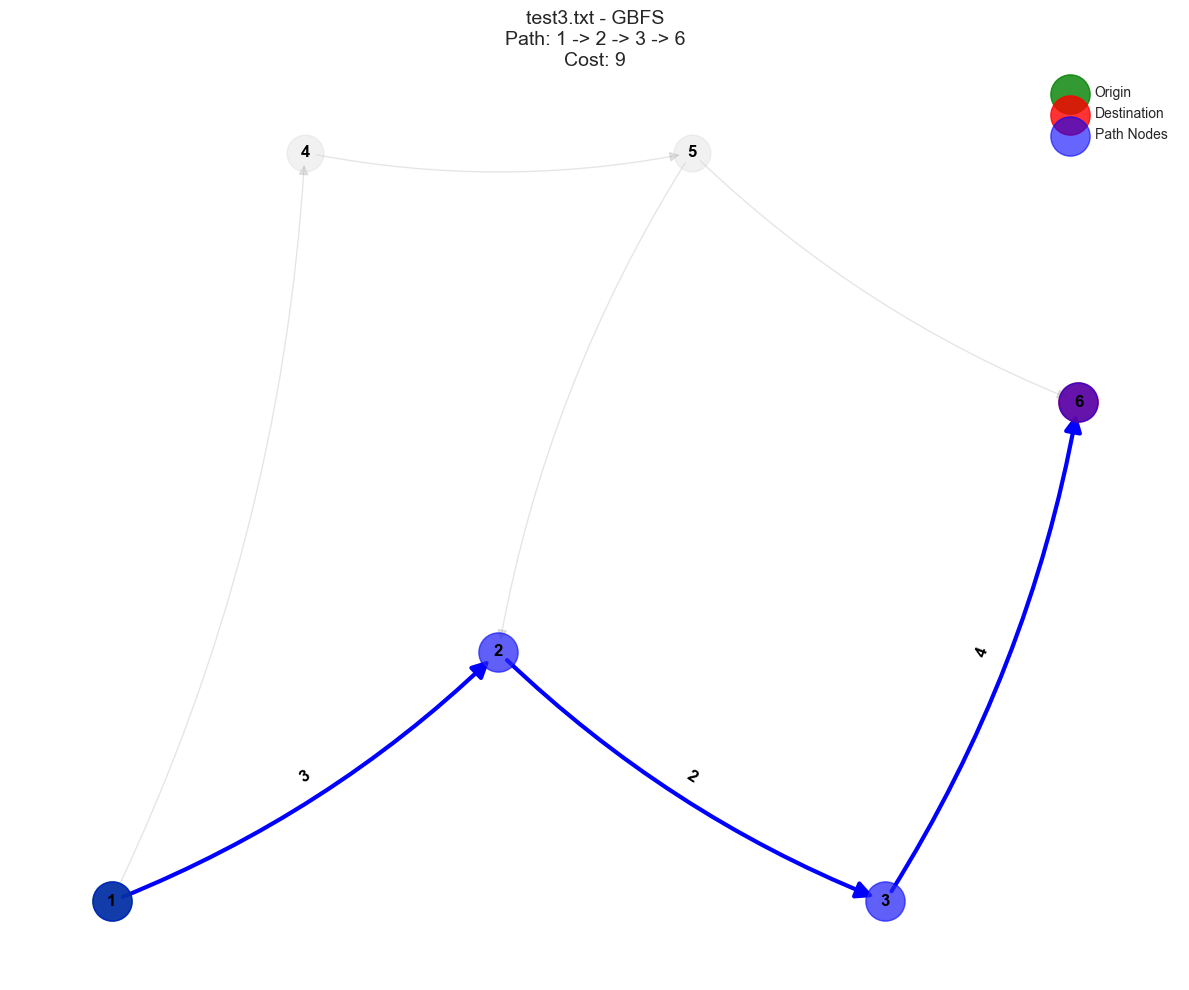

  Running on: test4.txt
Loaded graph with 6 nodes, 4 edges
Origin: 1, Destinations: [6]
    No solution found
  Running on: test5.txt
Loaded graph with 20 nodes, 39 edges
Origin: 1, Destinations: [20]
    Success! Goal: 20, Nodes created: 6, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test5.txt_GBFS_path.png


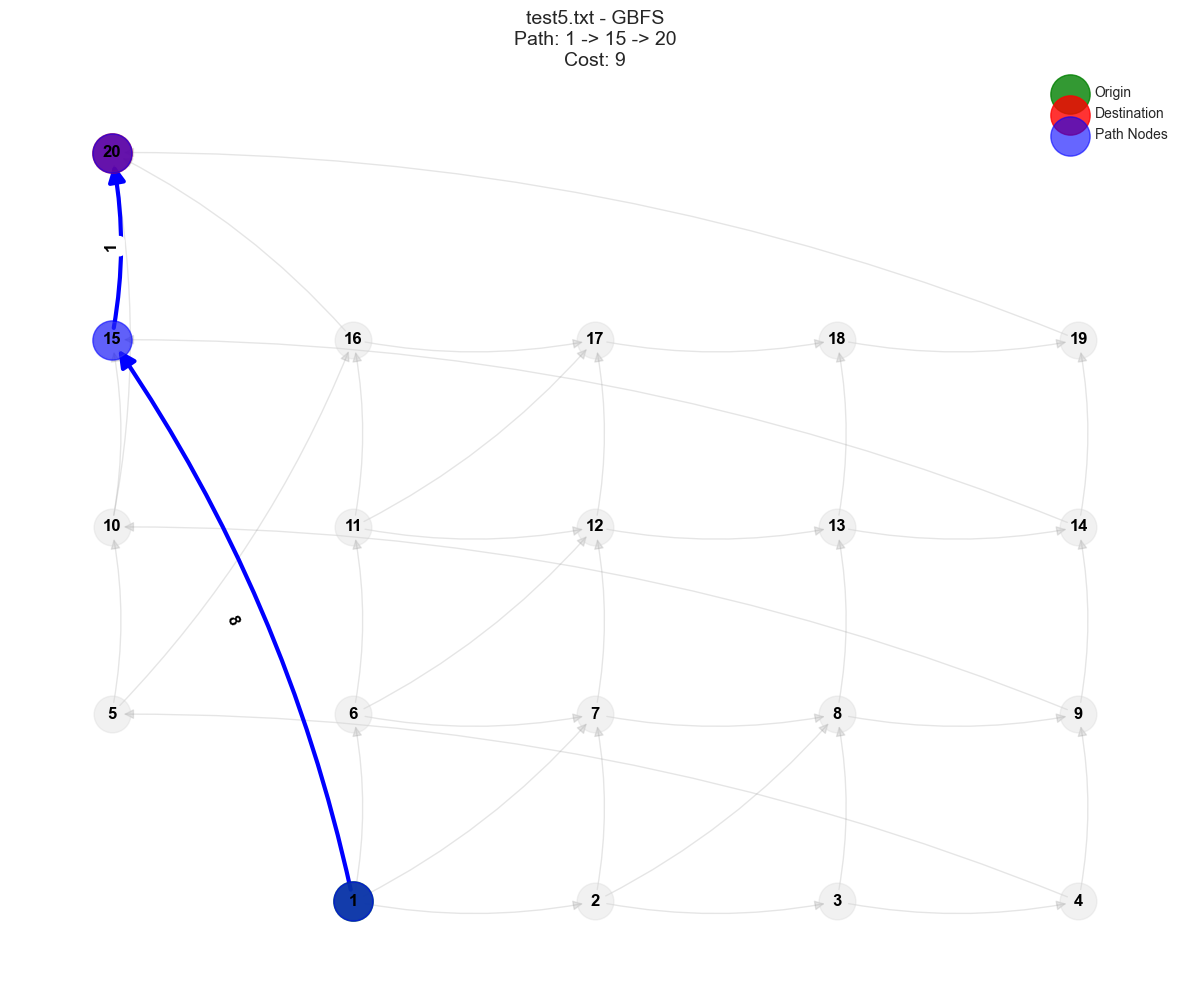

  Running on: test6.txt
Loaded graph with 6 nodes, 6 edges
Origin: 1, Destinations: [5, 6]
    Success! Goal: 5, Nodes created: 6, Path length: 4, Cost: 6.00
Saved path visualization to test_paths/test6.txt_GBFS_path.png


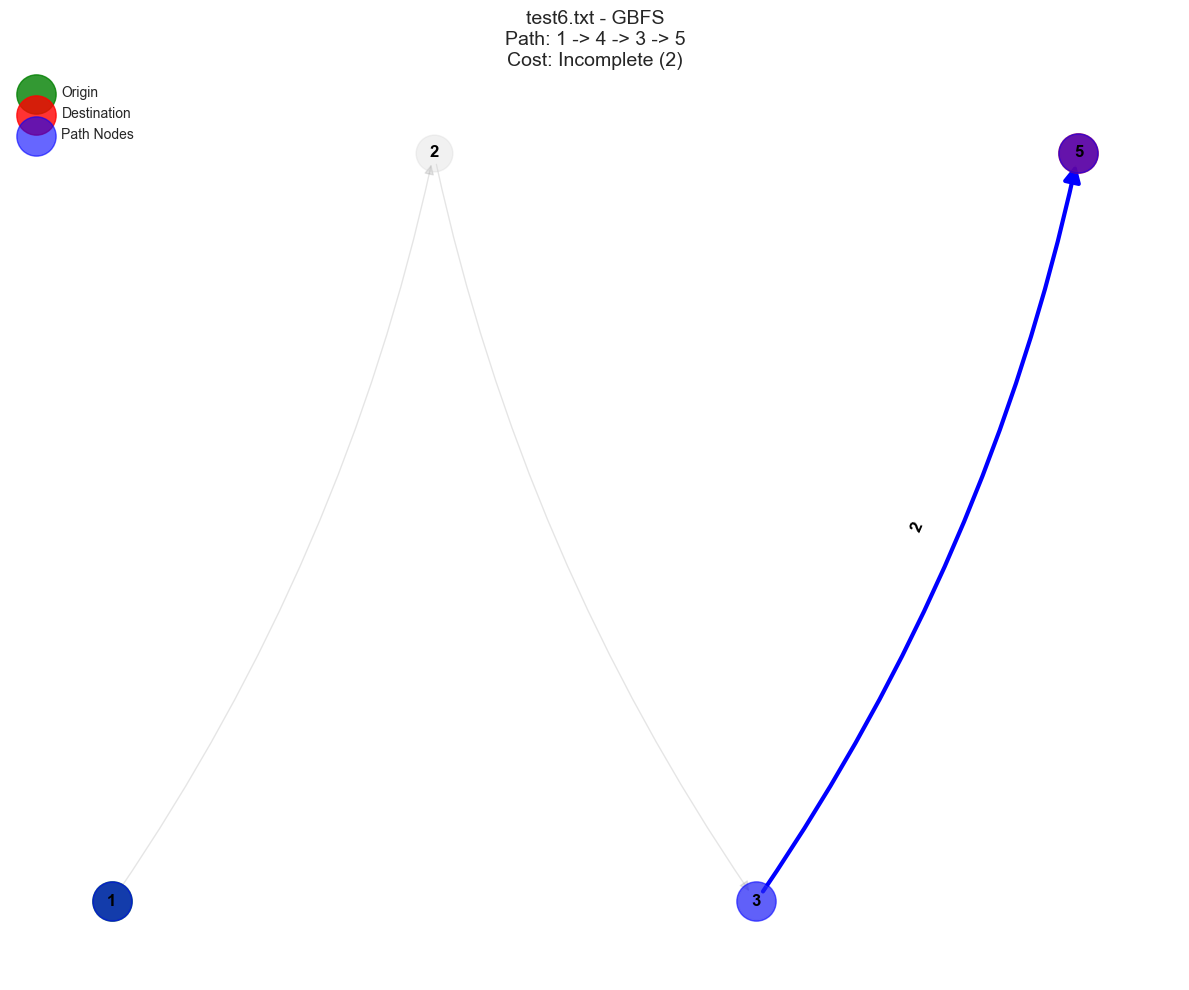

  Running on: test7.txt
Loaded graph with 4 nodes, 2 edges
Origin: 1, Destinations: [4]
    No solution found
  Running on: test8.txt
Loaded graph with 1 nodes, 0 edges
Origin: 1, Destinations: [1]
    Success! Goal: 1, Nodes created: 1, Path length: 1, Cost: 0.00
Saved path visualization to test_paths/test8.txt_GBFS_path.png


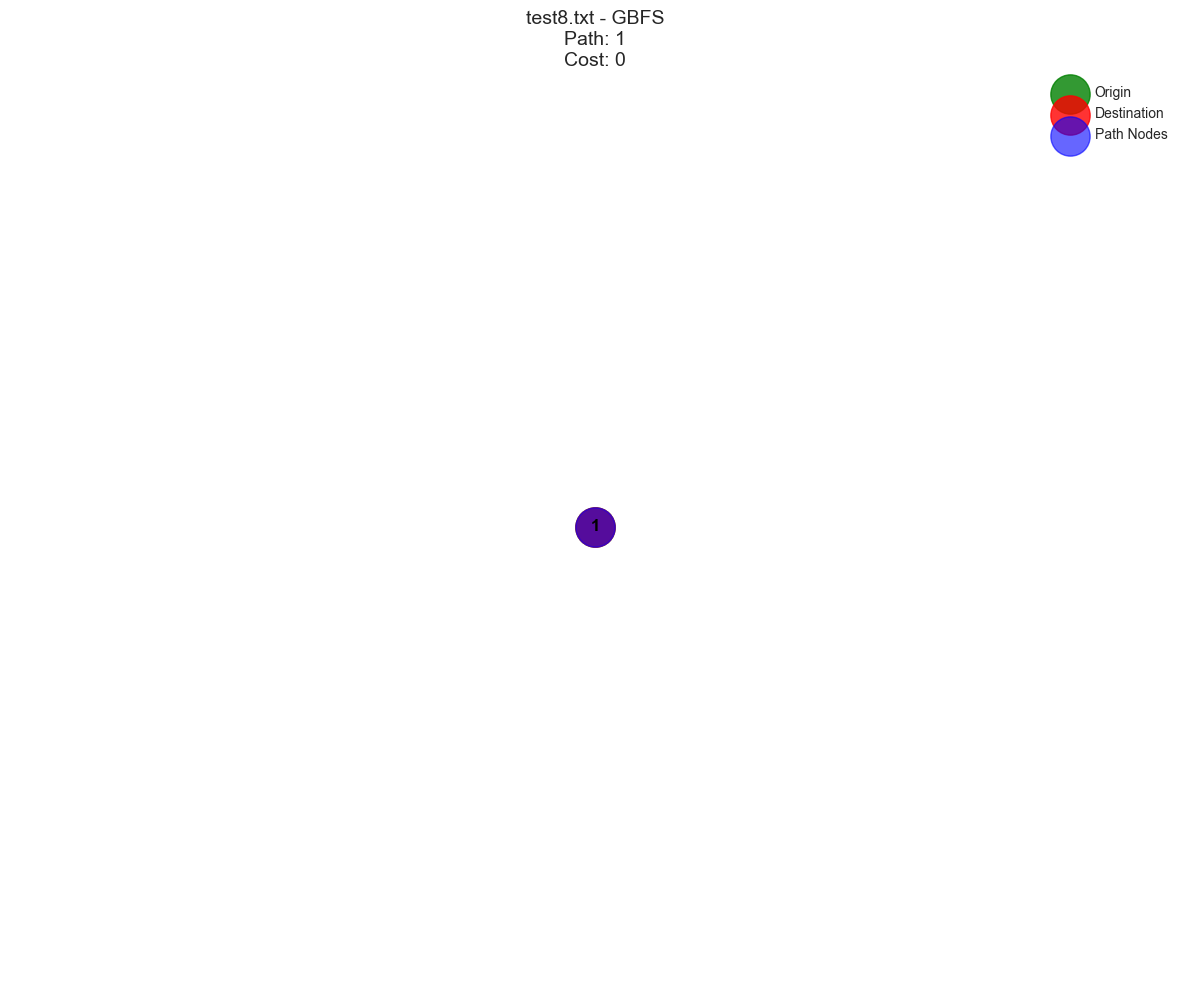

  Running on: test9.txt
Loaded graph with 5 nodes, 5 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 5, Path length: 4, Cost: 4.00
Saved path visualization to test_paths/test9.txt_GBFS_path.png


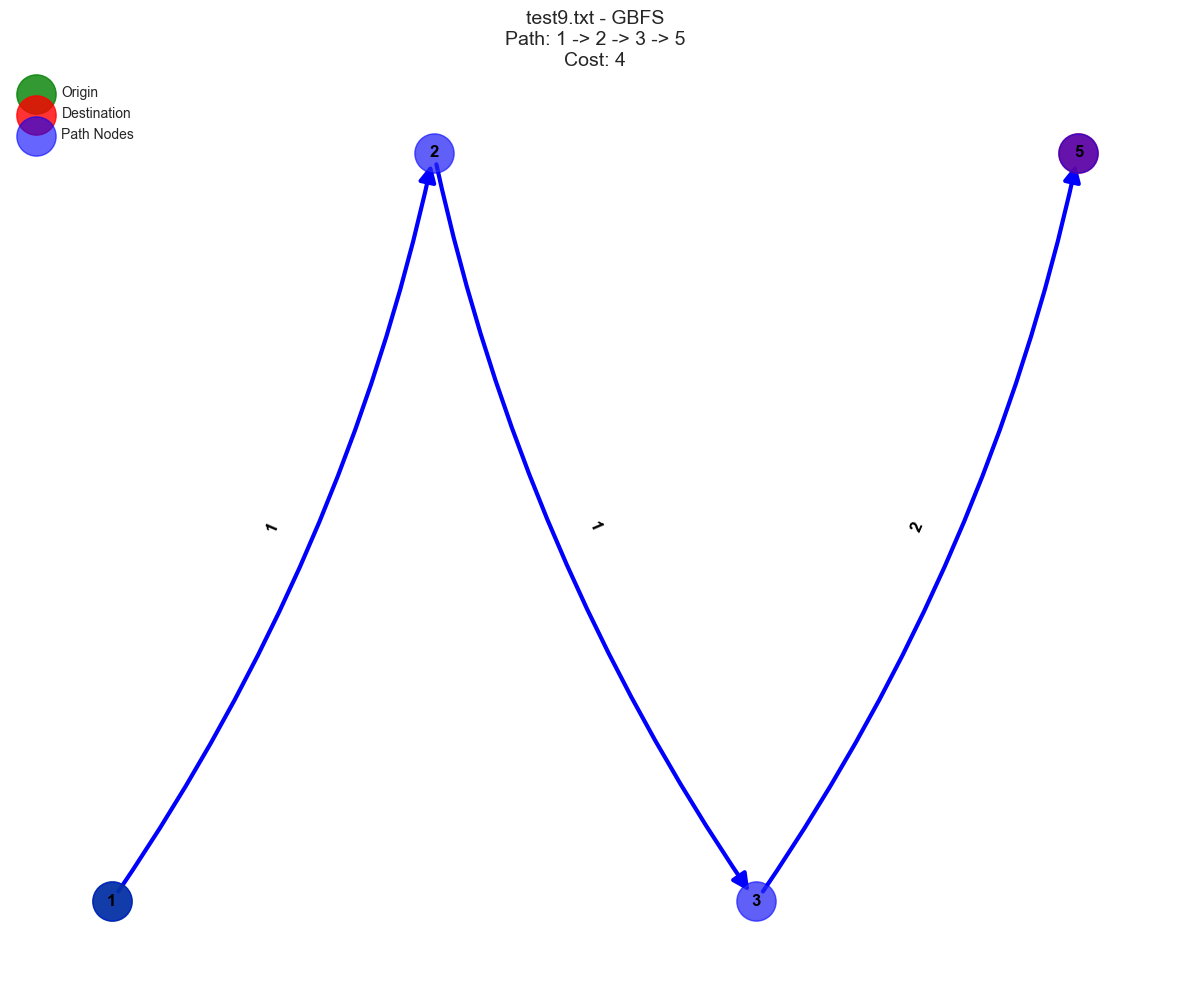


Testing AS...
  Running on: test1.txt
Loaded graph with 6 nodes, 14 edges
Origin: 2, Destinations: [5, 4]
    Success! Goal: 5, Nodes created: 6, Path length: 3, Cost: 10.00
Saved path visualization to test_paths/test1.txt_AS_path.png


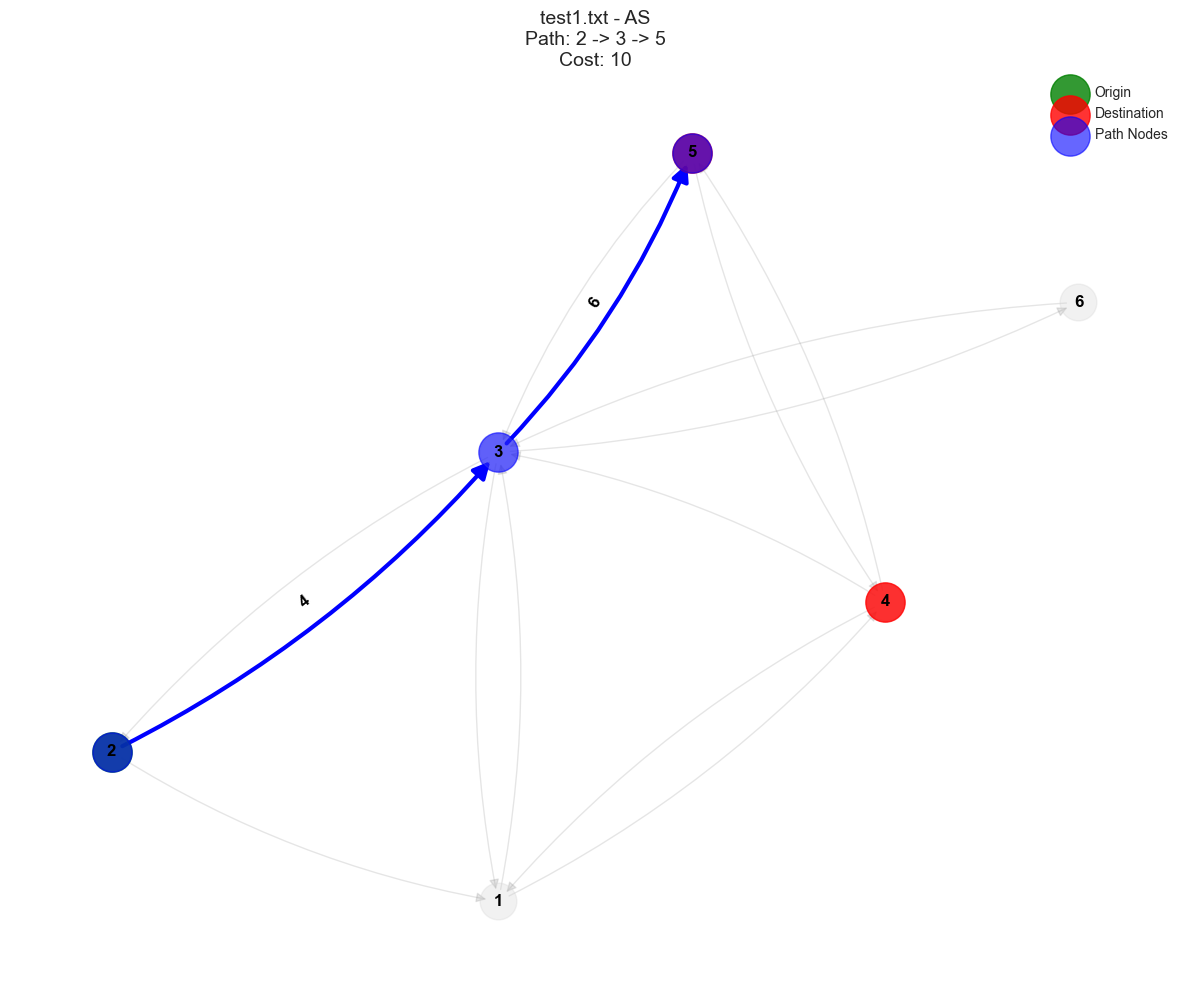

  Running on: test10.txt
Loaded graph with 16 nodes, 70 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 16, Path length: 4, Cost: 18.00
Saved path visualization to test_paths/test10.txt_AS_path.png


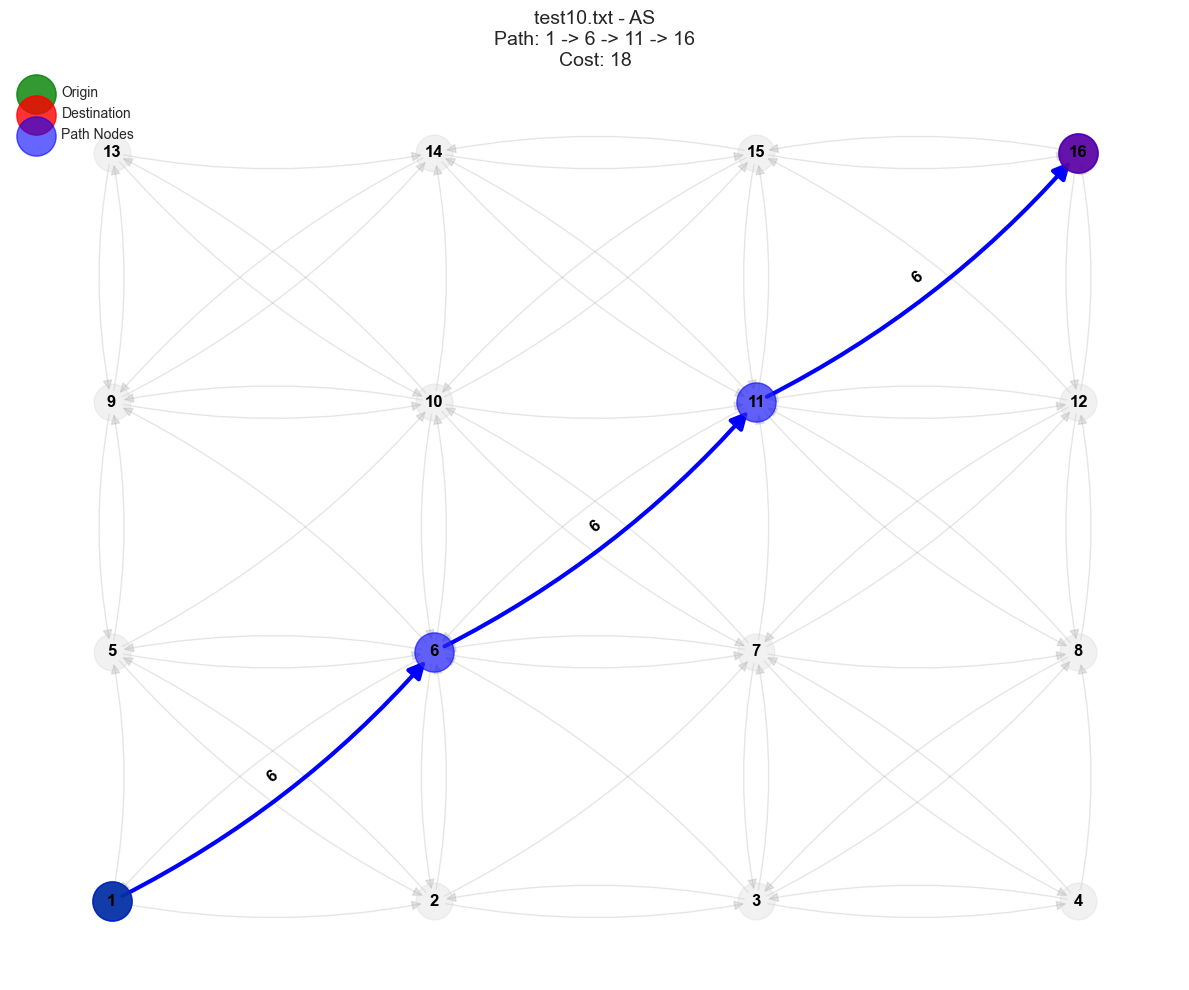

  Running on: test11.txt
Loaded graph with 16 nodes, 80 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 10, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test11.txt_AS_path.png


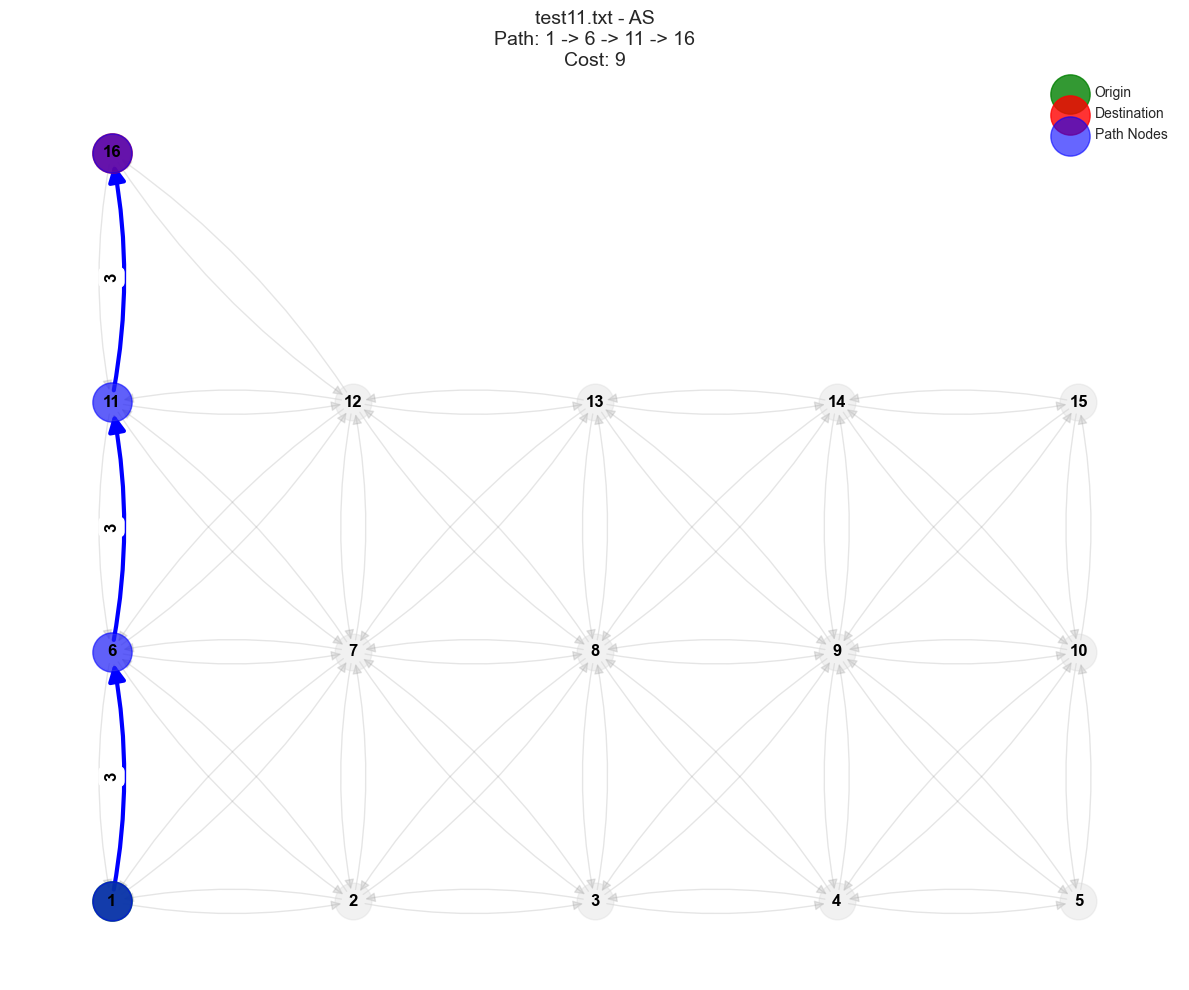

  Running on: test12.txt
Loaded graph with 5 nodes, 7 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 7, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test12.txt_AS_path.png


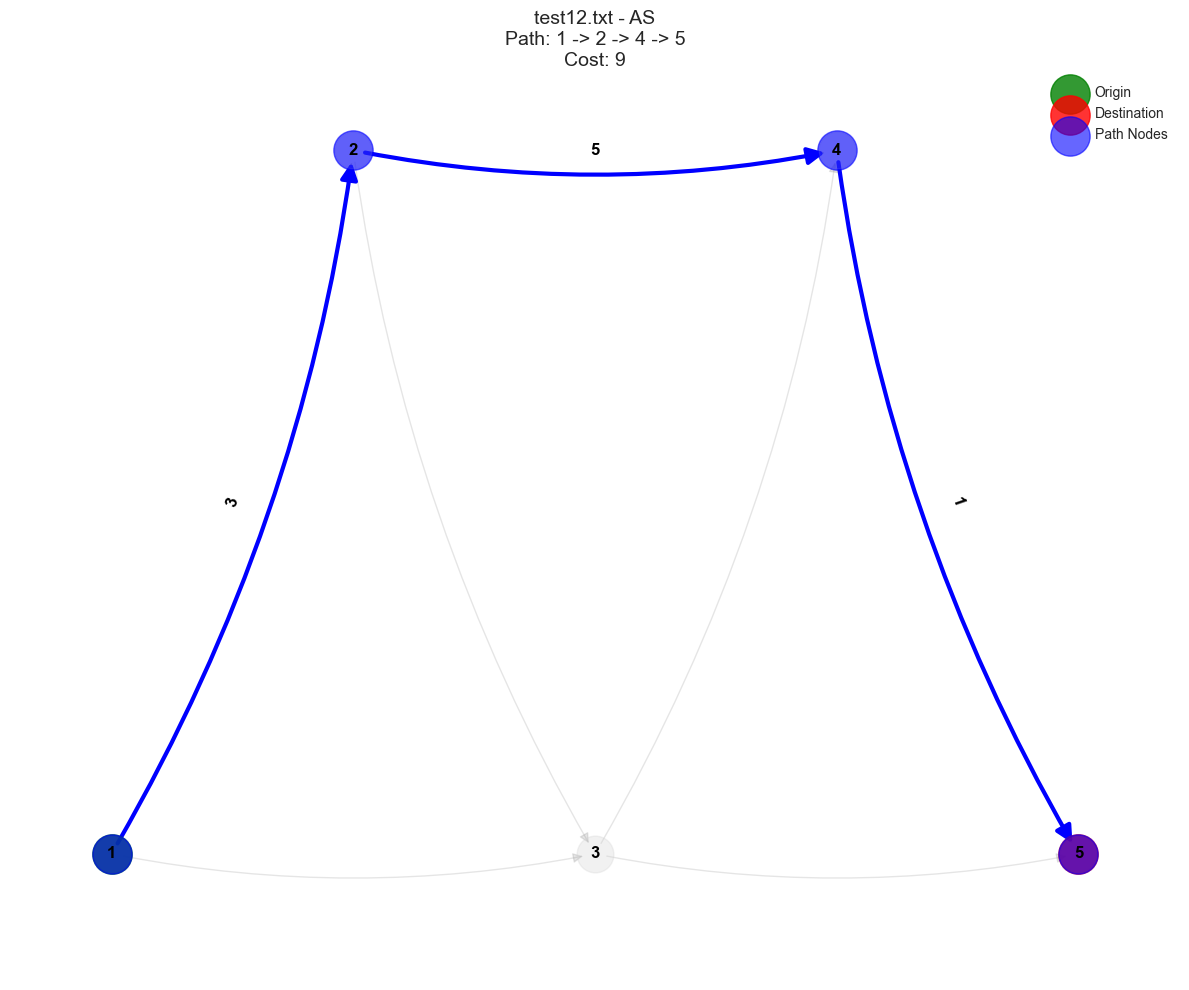

  Running on: test2.txt
Loaded graph with 6 nodes, 11 edges
Origin: 1, Destinations: [4, 5, 6]
    Success! Goal: 5, Nodes created: 5, Path length: 3, Cost: 7.00
Saved path visualization to test_paths/test2.txt_AS_path.png


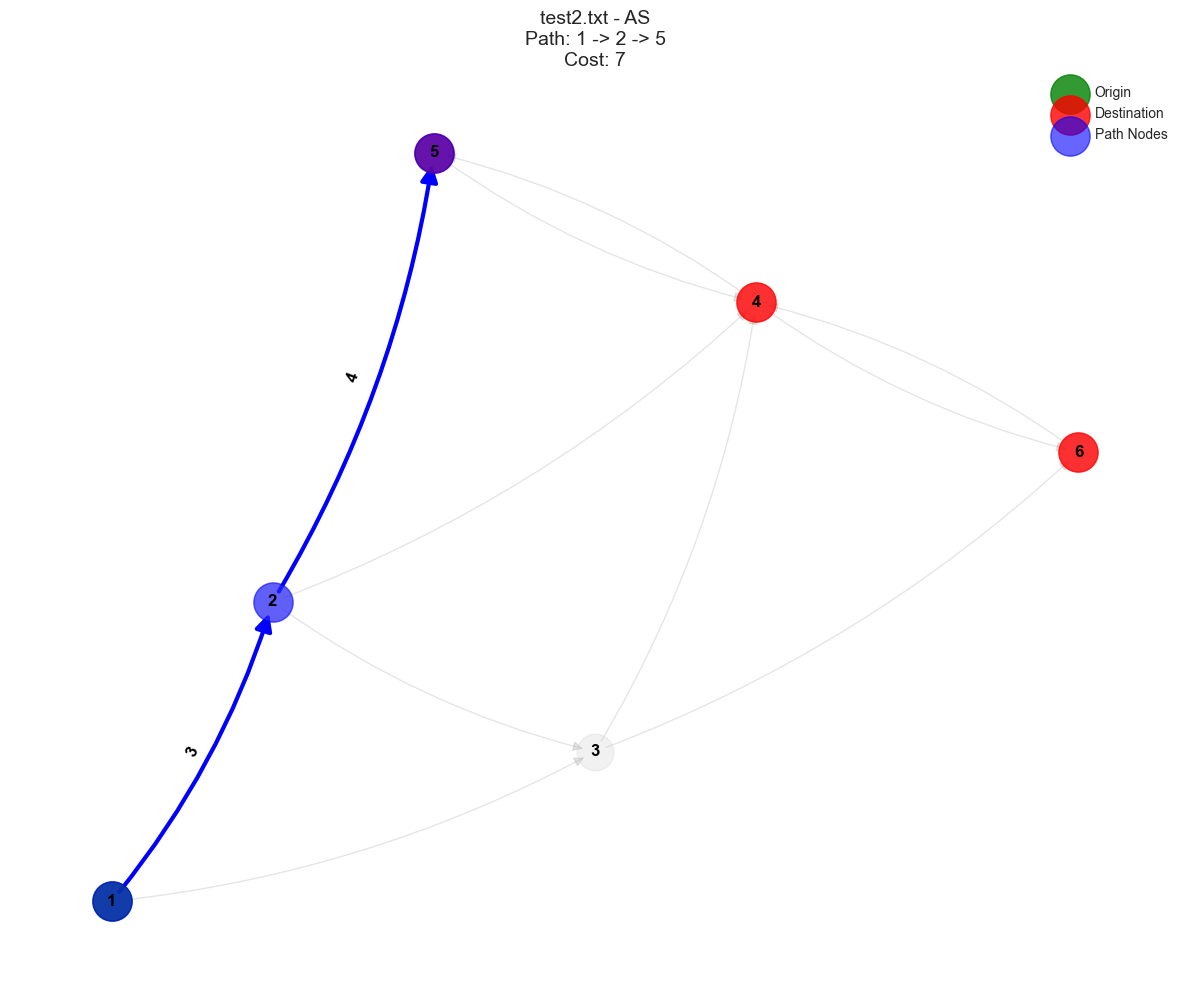

  Running on: test3.txt
Loaded graph with 6 nodes, 7 edges
Origin: 1, Destinations: [6]
    Success! Goal: 6, Nodes created: 6, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test3.txt_AS_path.png


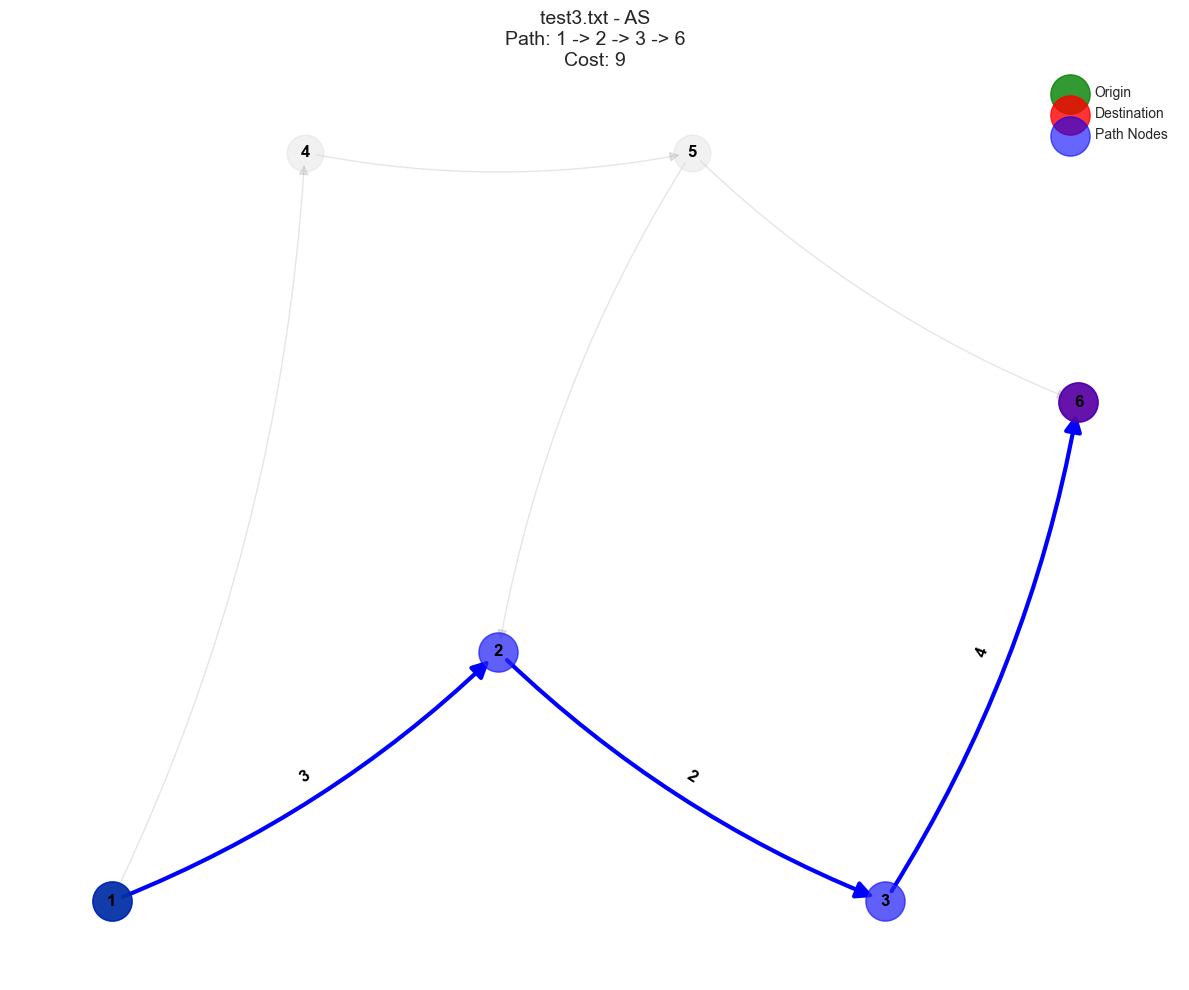

  Running on: test4.txt
Loaded graph with 6 nodes, 4 edges
Origin: 1, Destinations: [6]
    No solution found
  Running on: test5.txt
Loaded graph with 20 nodes, 39 edges
Origin: 1, Destinations: [20]
    Success! Goal: 20, Nodes created: 10, Path length: 5, Cost: 5.00
Saved path visualization to test_paths/test5.txt_AS_path.png


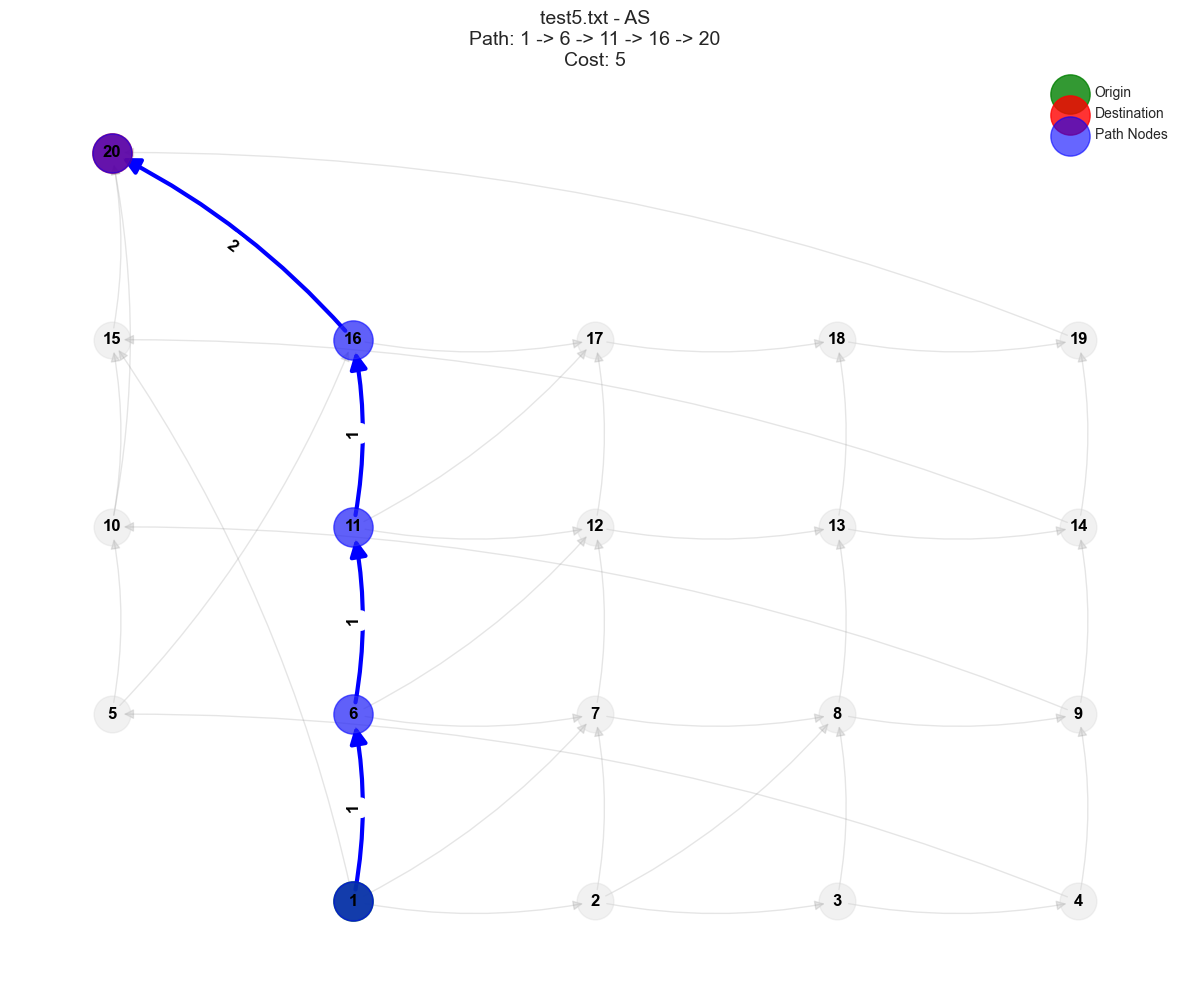

  Running on: test6.txt
Loaded graph with 6 nodes, 6 edges
Origin: 1, Destinations: [5, 6]
    Success! Goal: 6, Nodes created: 6, Path length: 4, Cost: 6.00
Saved path visualization to test_paths/test6.txt_AS_path.png


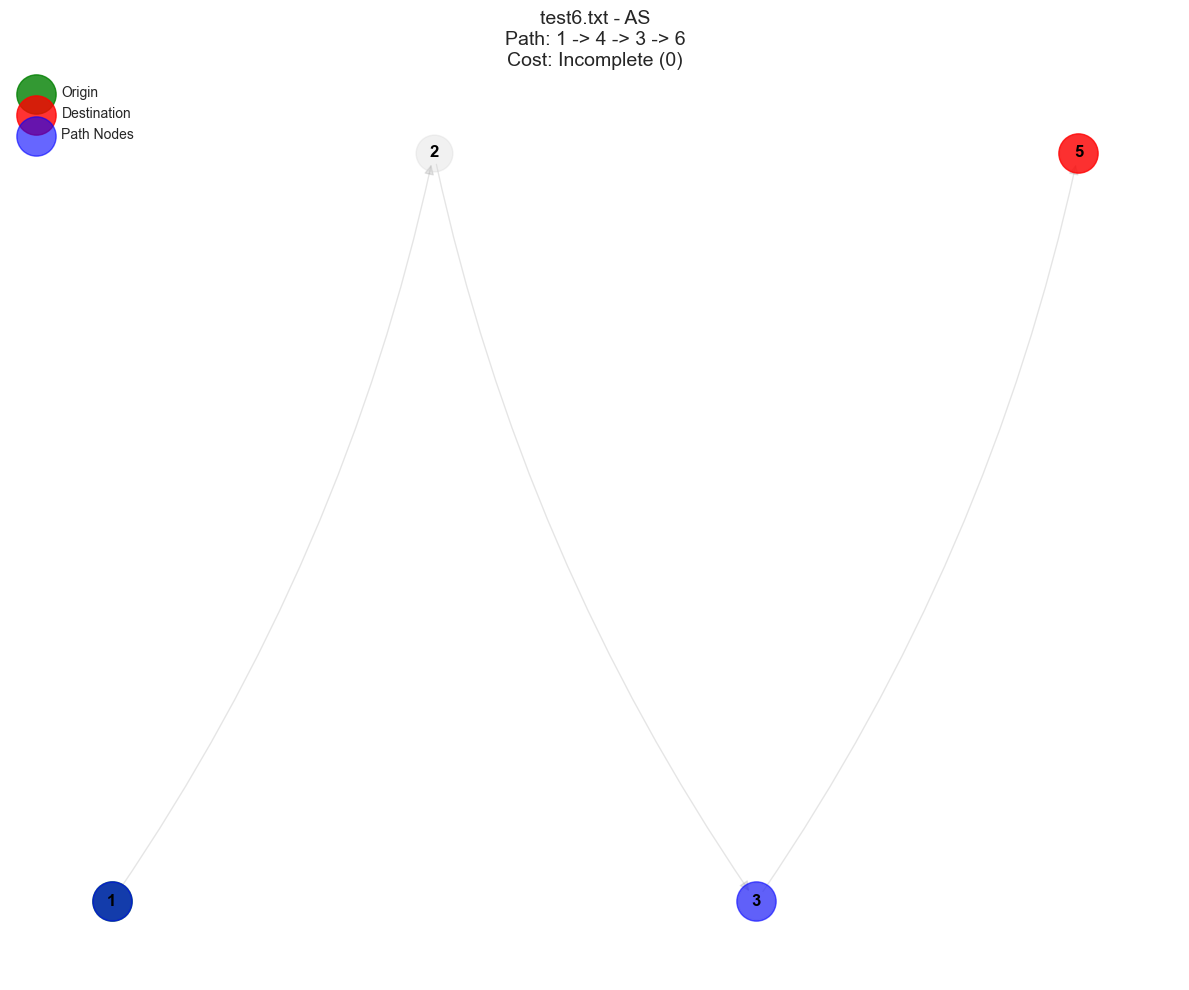

  Running on: test7.txt
Loaded graph with 4 nodes, 2 edges
Origin: 1, Destinations: [4]
    No solution found
  Running on: test8.txt
Loaded graph with 1 nodes, 0 edges
Origin: 1, Destinations: [1]
    Success! Goal: 1, Nodes created: 1, Path length: 1, Cost: 0.00
Saved path visualization to test_paths/test8.txt_AS_path.png


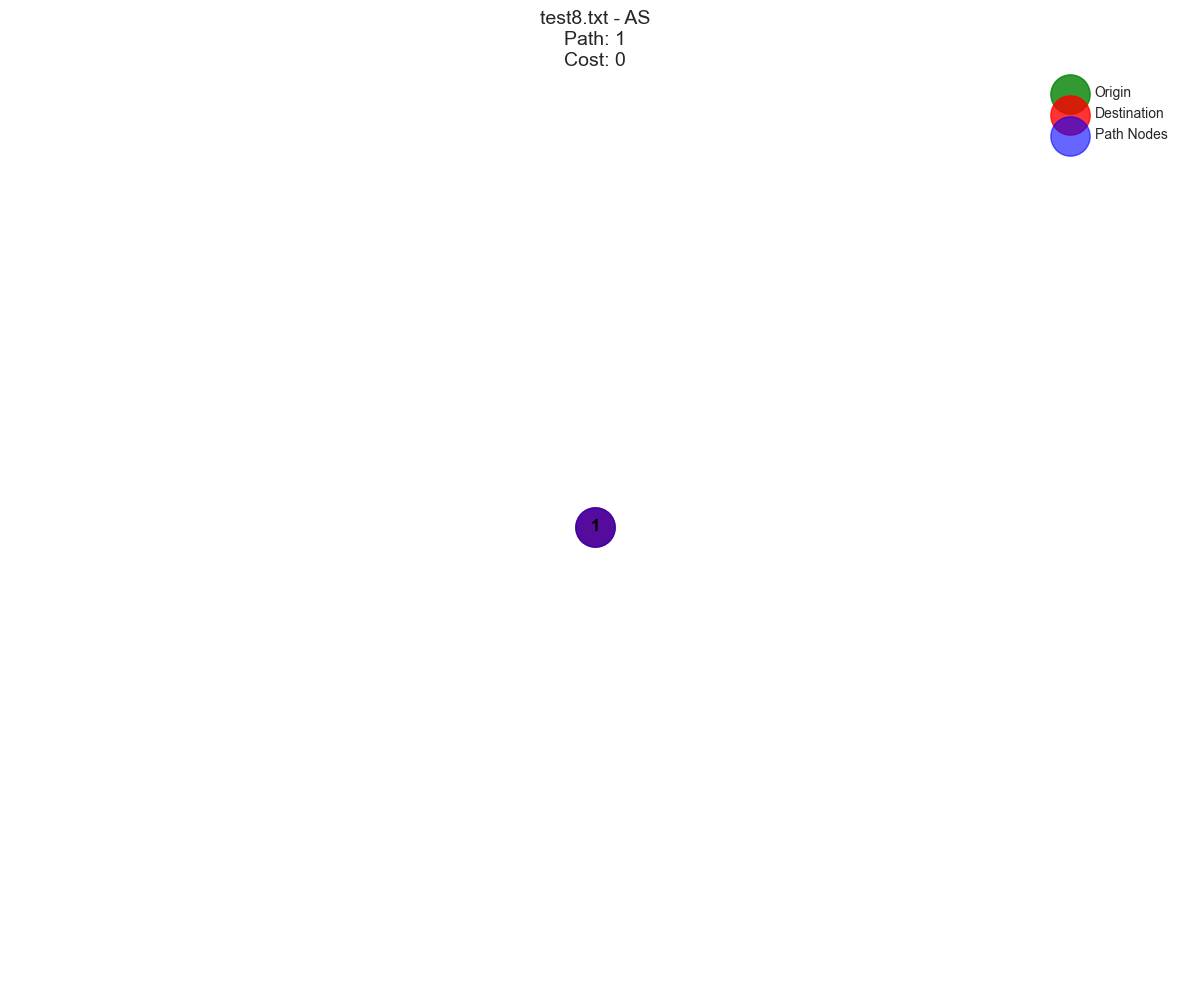

  Running on: test9.txt
Loaded graph with 5 nodes, 5 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 5, Path length: 4, Cost: 4.00
Saved path visualization to test_paths/test9.txt_AS_path.png


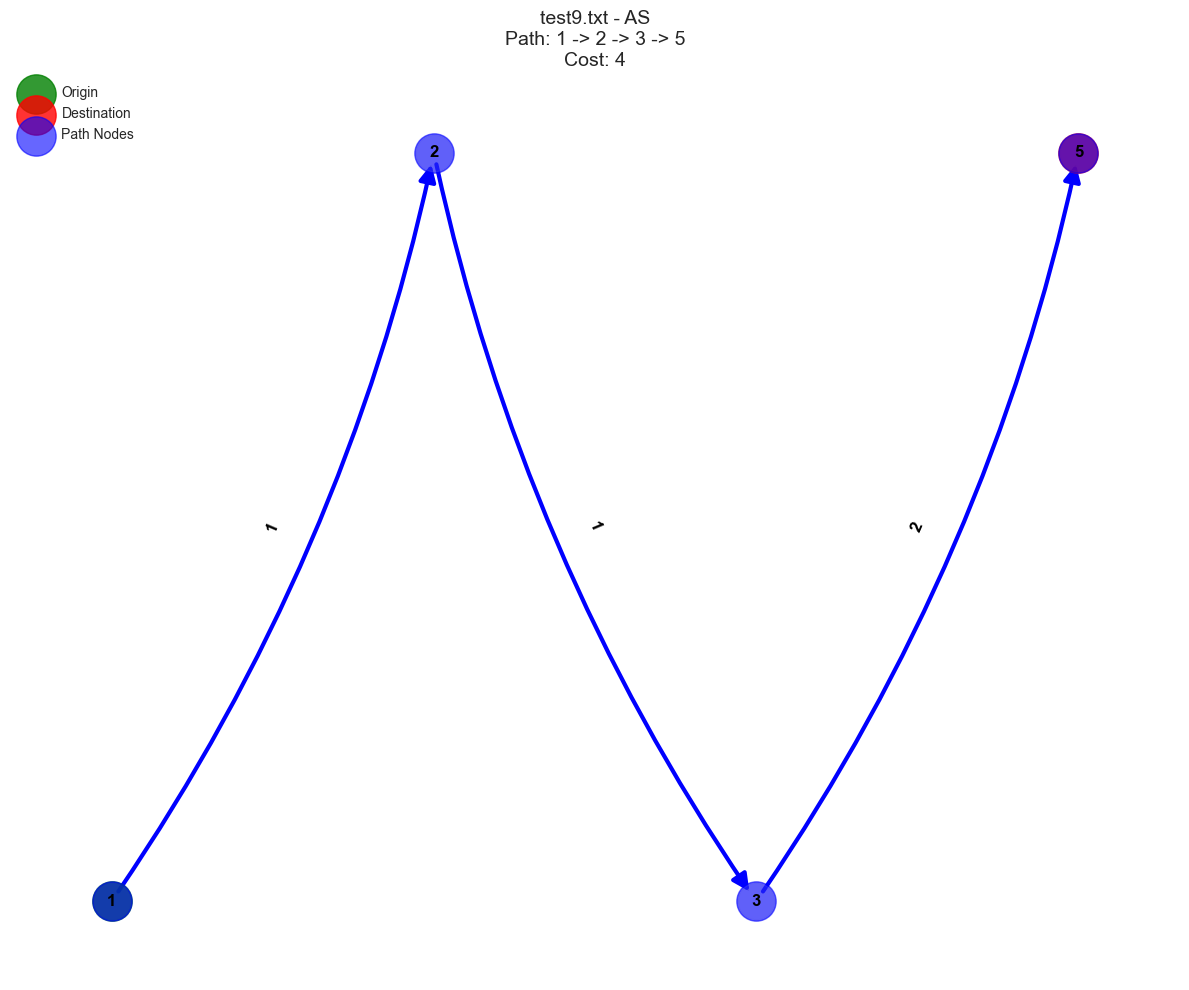


Testing CUS1...
  Running on: test1.txt
Loaded graph with 6 nodes, 14 edges
Origin: 2, Destinations: [5, 4]
    Success! Goal: 4, Nodes created: 6, Path length: 3, Cost: 10.00
Saved path visualization to test_paths/test1.txt_CUS1_path.png


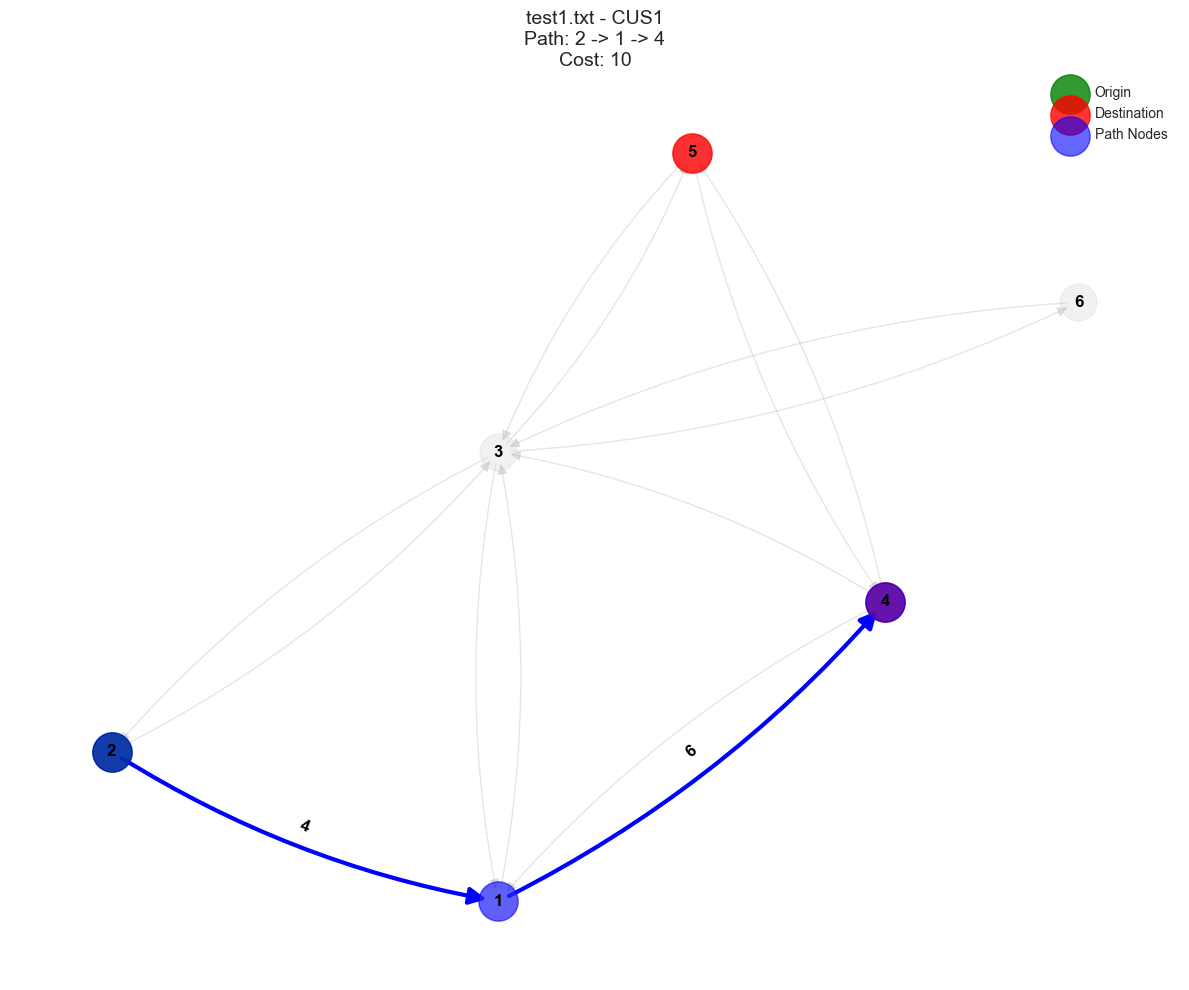

  Running on: test10.txt
Loaded graph with 16 nodes, 70 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 102, Path length: 4, Cost: 18.00
Saved path visualization to test_paths/test10.txt_CUS1_path.png


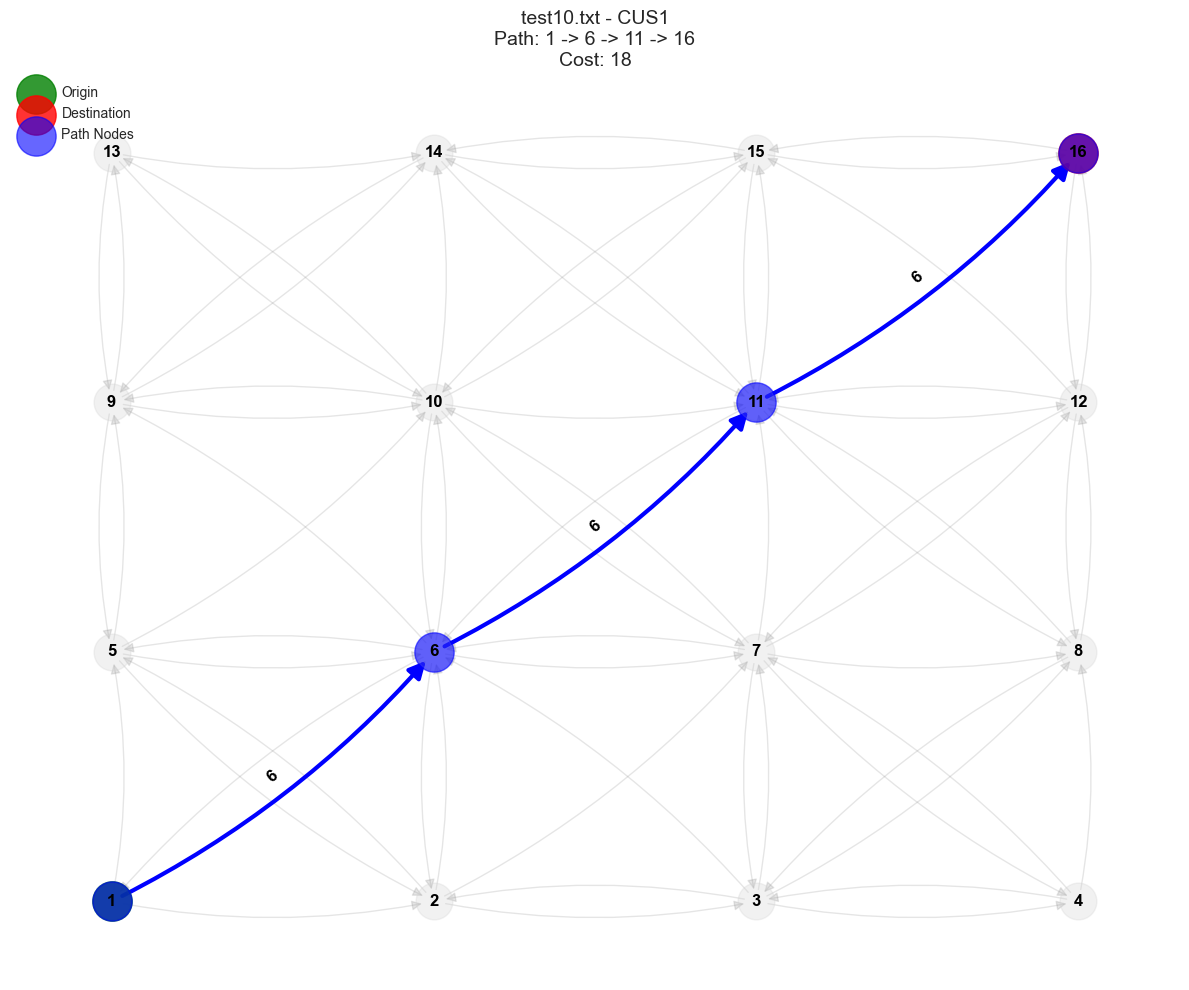

  Running on: test11.txt
Loaded graph with 16 nodes, 80 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 63, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test11.txt_CUS1_path.png


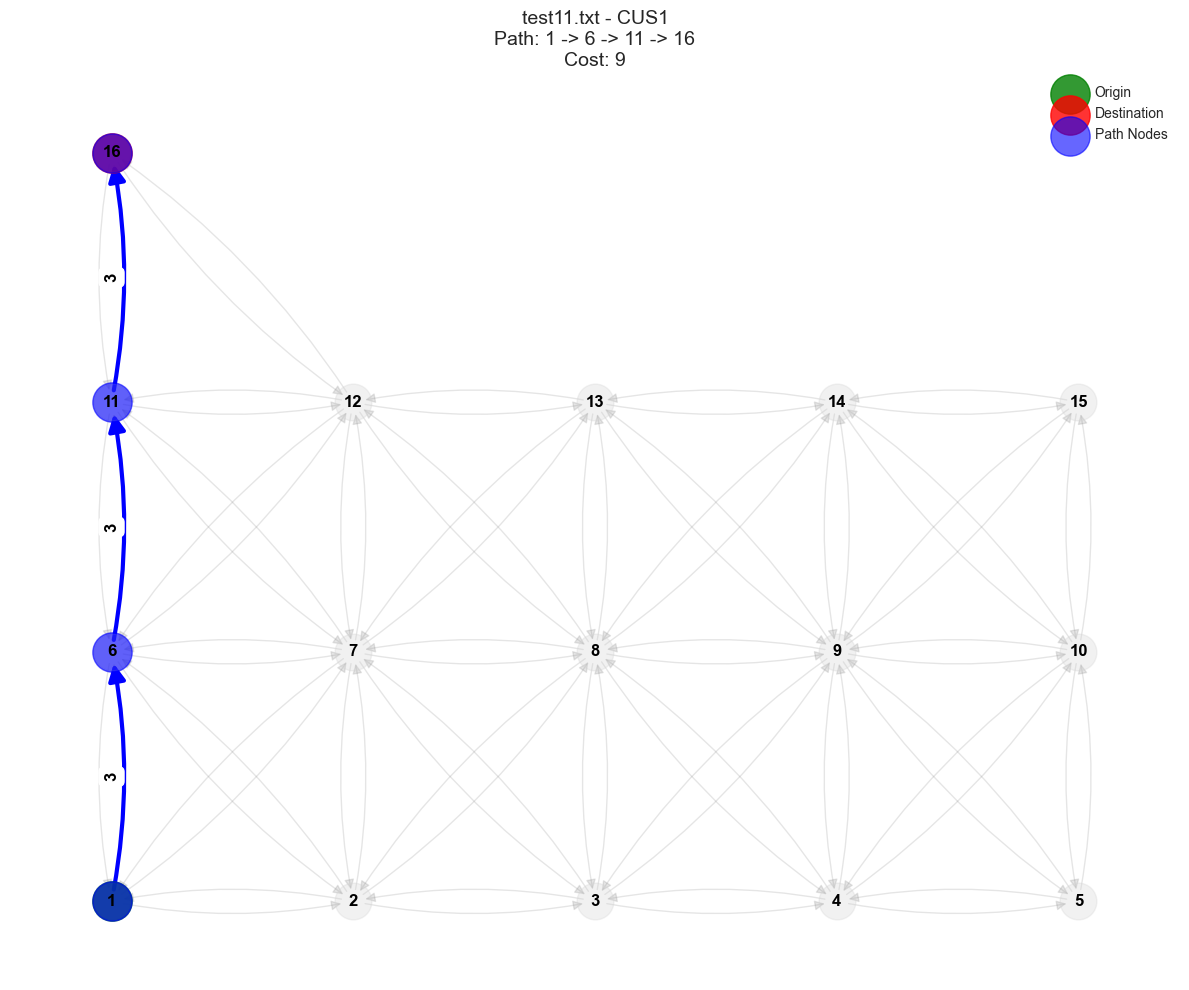

  Running on: test12.txt
Loaded graph with 5 nodes, 7 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 9, Path length: 3, Cost: 13.00
Saved path visualization to test_paths/test12.txt_CUS1_path.png


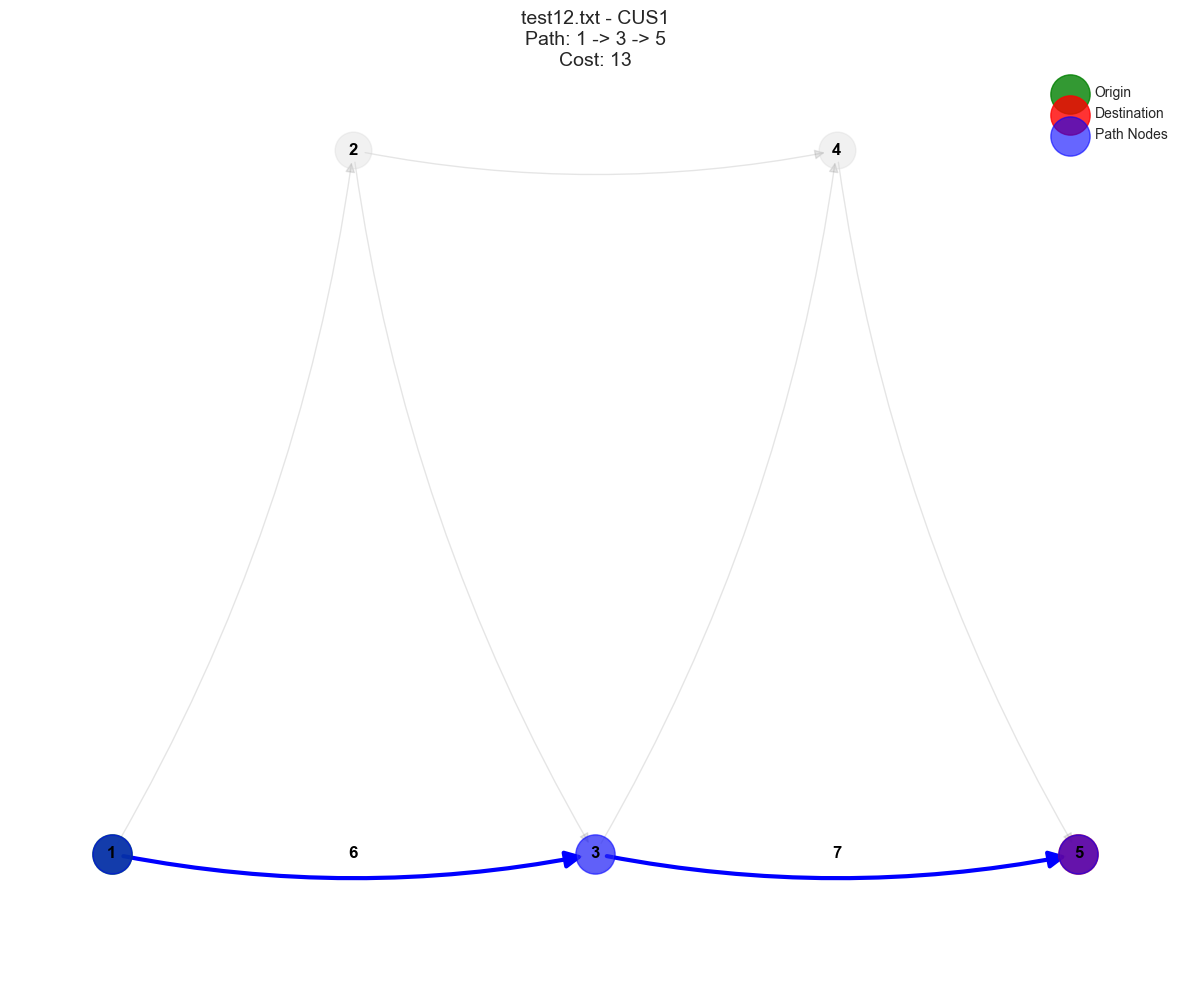

  Running on: test2.txt
Loaded graph with 6 nodes, 11 edges
Origin: 1, Destinations: [4, 5, 6]
    Success! Goal: 4, Nodes created: 6, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test2.txt_CUS1_path.png


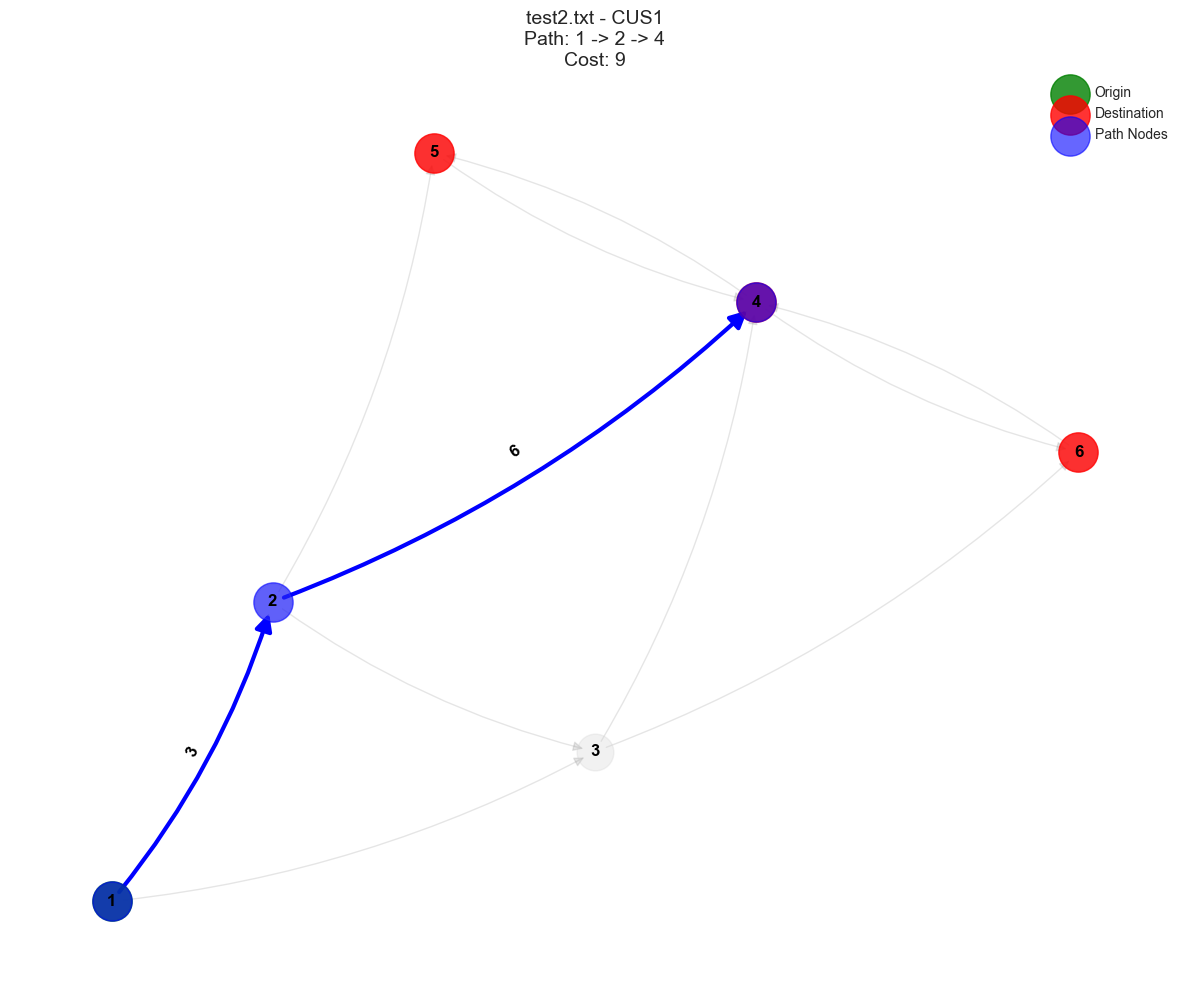

  Running on: test3.txt
Loaded graph with 6 nodes, 7 edges
Origin: 1, Destinations: [6]
    Success! Goal: 6, Nodes created: 10, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test3.txt_CUS1_path.png


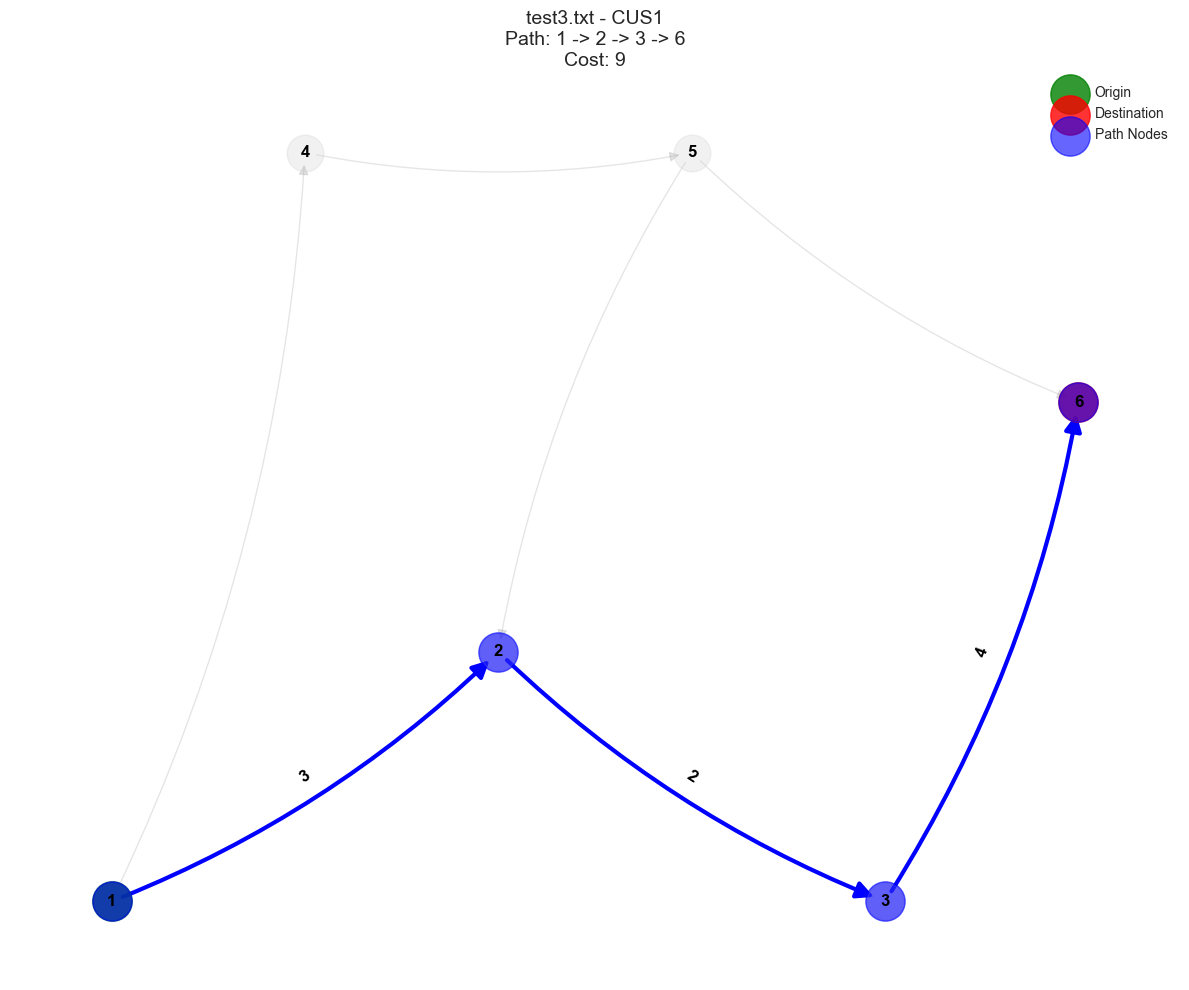

  Running on: test4.txt
Loaded graph with 6 nodes, 4 edges
Origin: 1, Destinations: [6]
    No solution found
  Running on: test5.txt
Loaded graph with 20 nodes, 39 edges
Origin: 1, Destinations: [20]
    Success! Goal: 20, Nodes created: 18, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test5.txt_CUS1_path.png


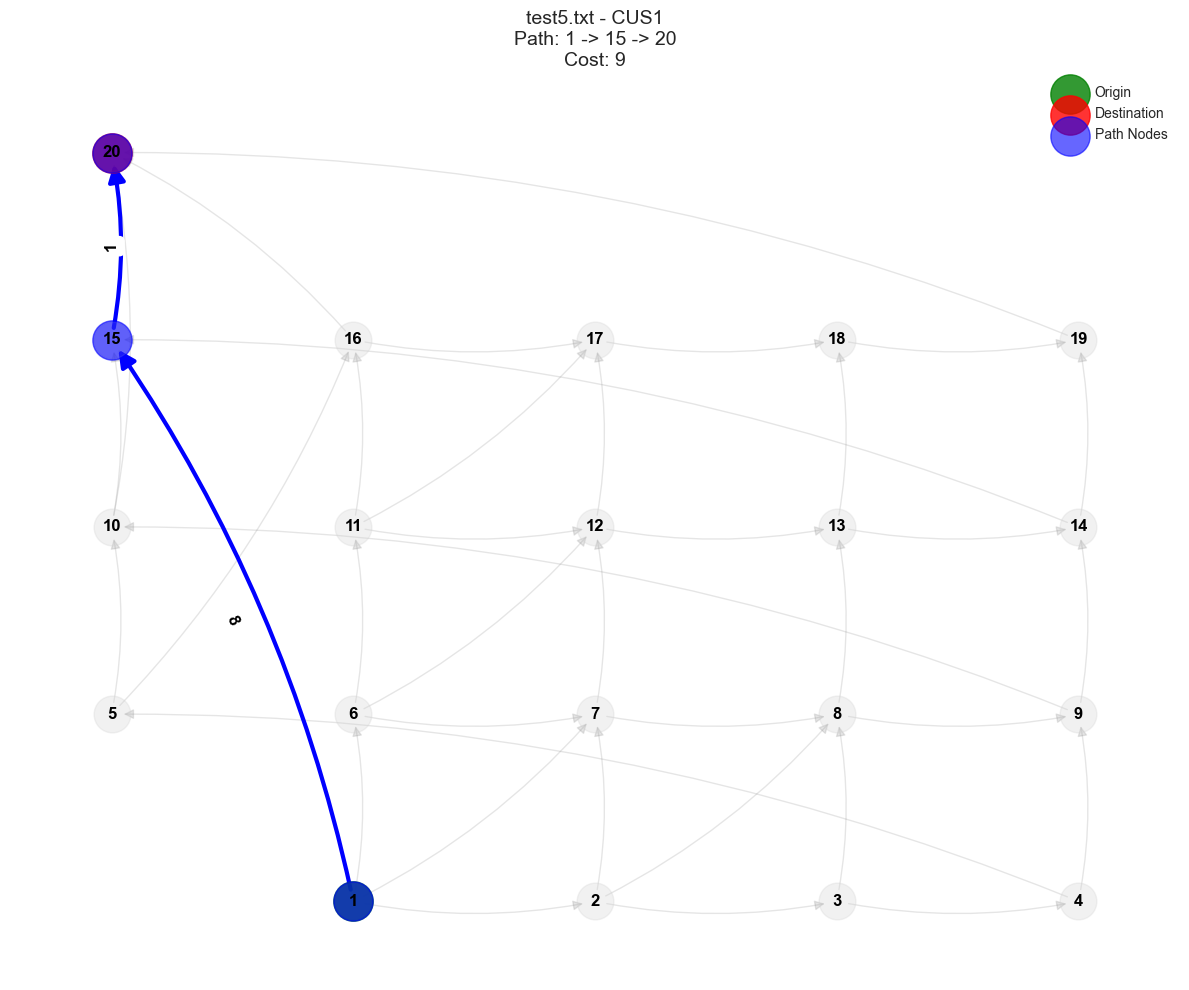

  Running on: test6.txt
Loaded graph with 6 nodes, 6 edges
Origin: 1, Destinations: [5, 6]
    Success! Goal: 5, Nodes created: 10, Path length: 4, Cost: 6.00
Saved path visualization to test_paths/test6.txt_CUS1_path.png


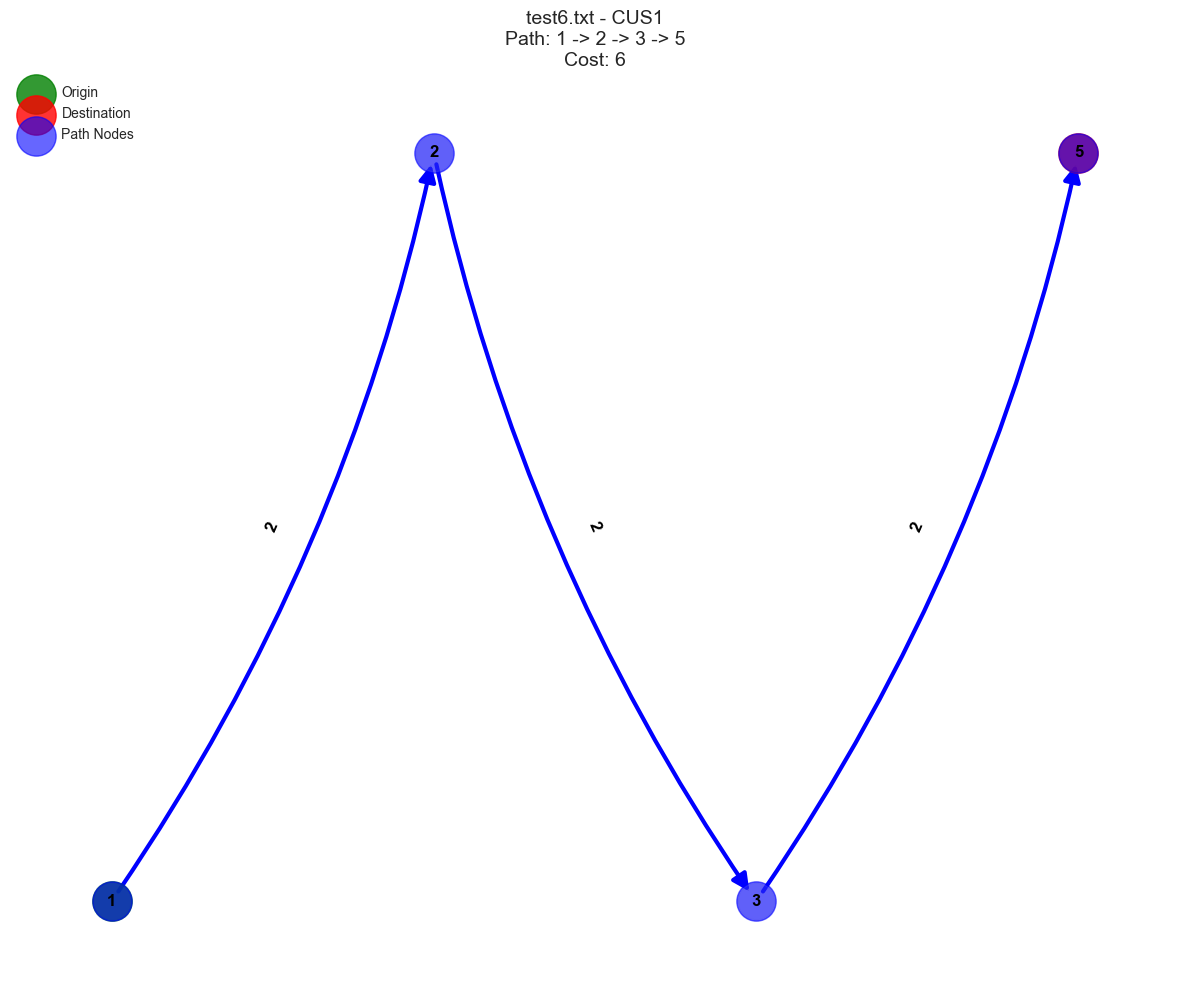

  Running on: test7.txt
Loaded graph with 4 nodes, 2 edges
Origin: 1, Destinations: [4]
    No solution found
  Running on: test8.txt
Loaded graph with 1 nodes, 0 edges
Origin: 1, Destinations: [1]
    Success! Goal: 1, Nodes created: 1, Path length: 1, Cost: 0.00
Saved path visualization to test_paths/test8.txt_CUS1_path.png


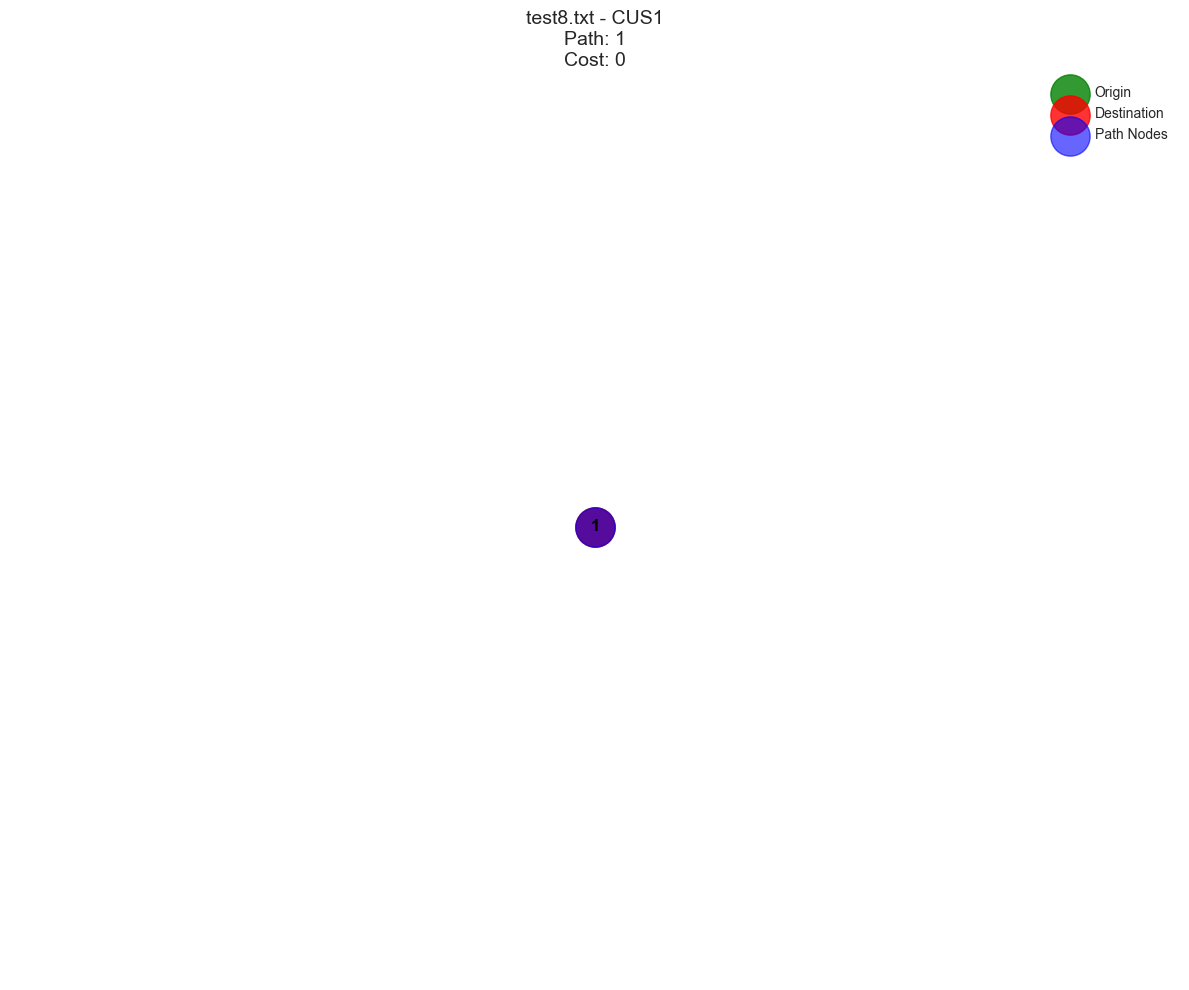

  Running on: test9.txt
Loaded graph with 5 nodes, 5 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 8, Path length: 4, Cost: 4.00
Saved path visualization to test_paths/test9.txt_CUS1_path.png


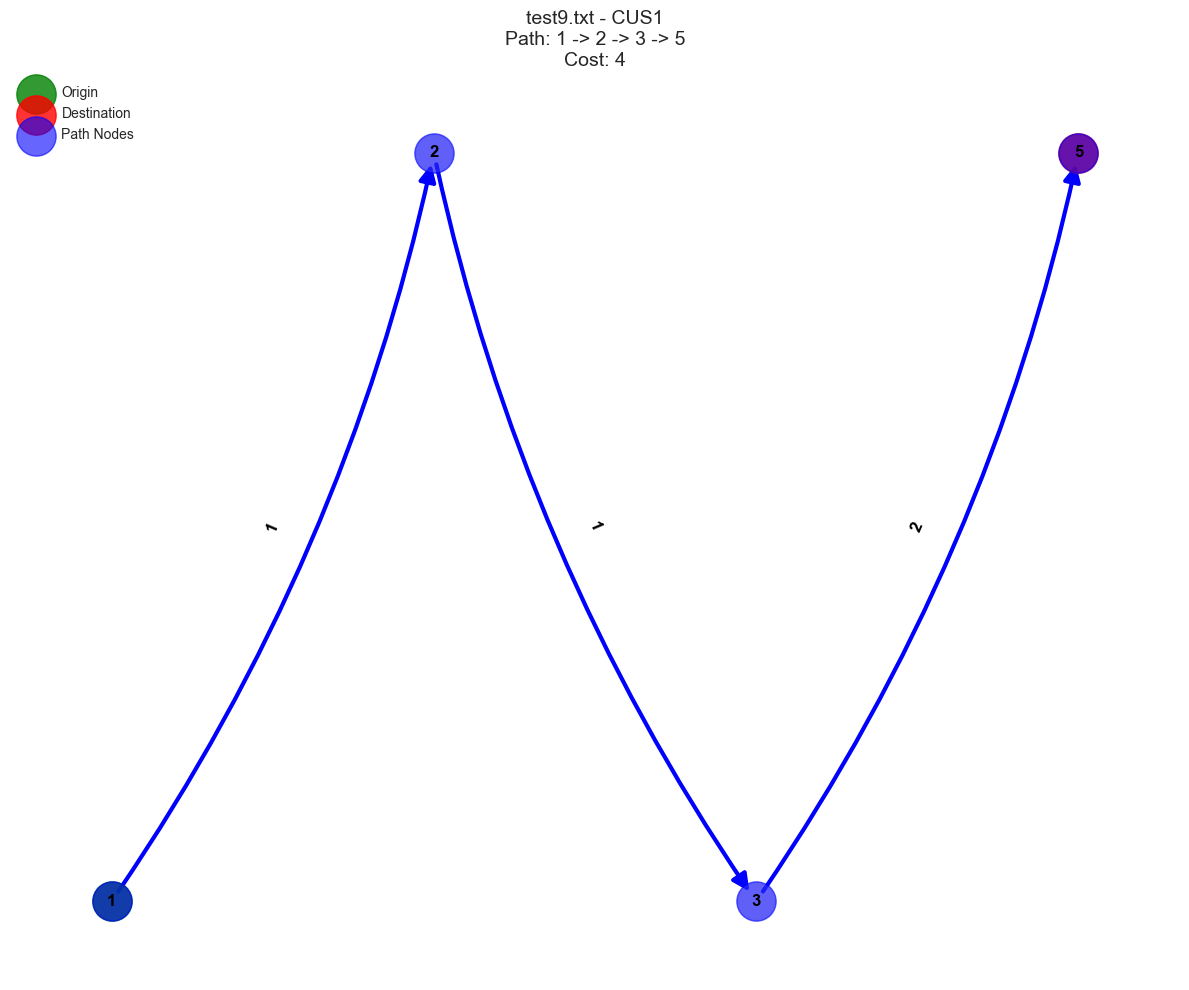


Testing CUS2...
  Running on: test1.txt
Loaded graph with 6 nodes, 14 edges
Origin: 2, Destinations: [5, 4]
    Success! Goal: 5, Nodes created: 6, Path length: 3, Cost: 10.00
Saved path visualization to test_paths/test1.txt_CUS2_path.png


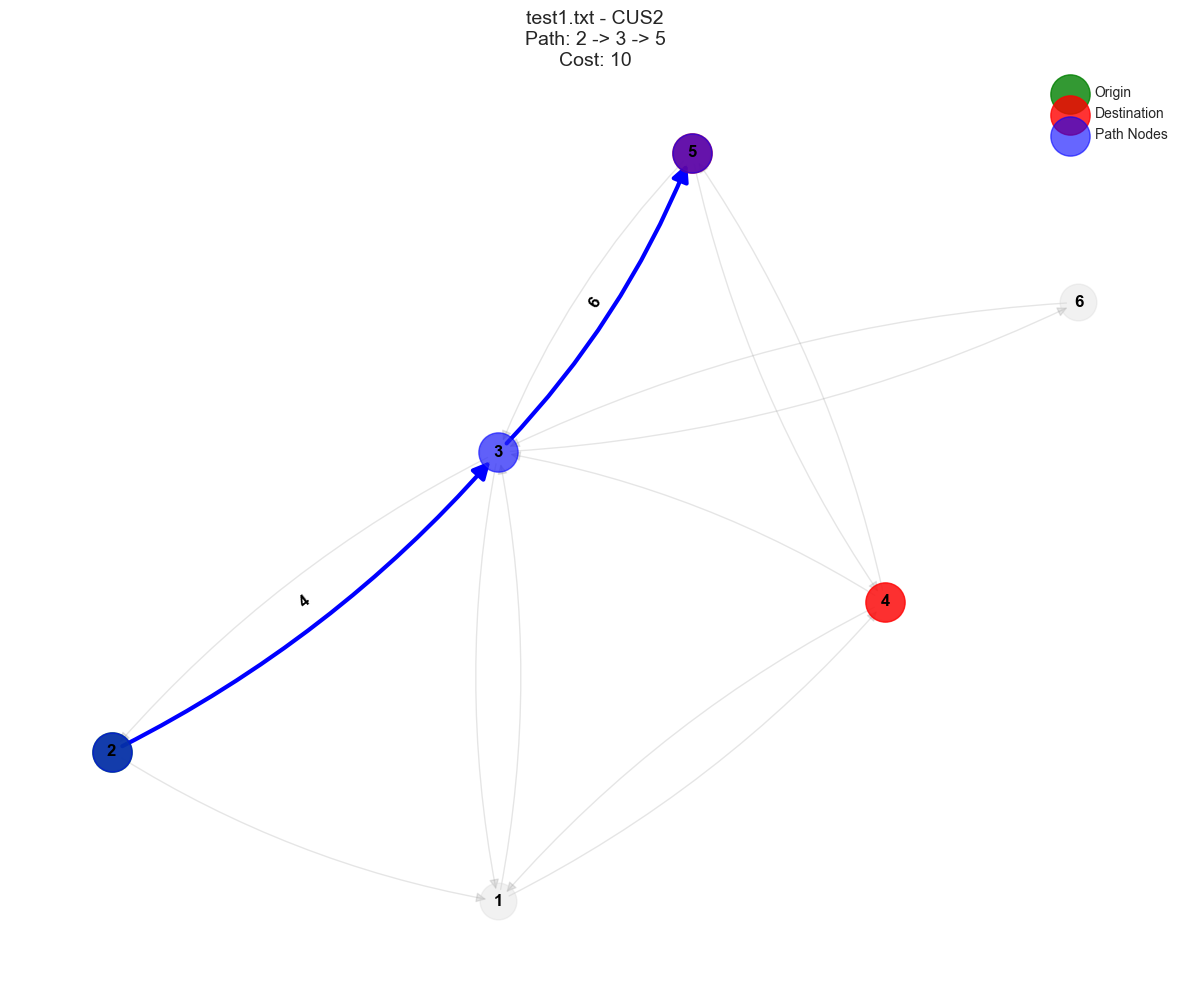

  Running on: test10.txt
Loaded graph with 16 nodes, 70 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 13, Path length: 4, Cost: 18.00
Saved path visualization to test_paths/test10.txt_CUS2_path.png


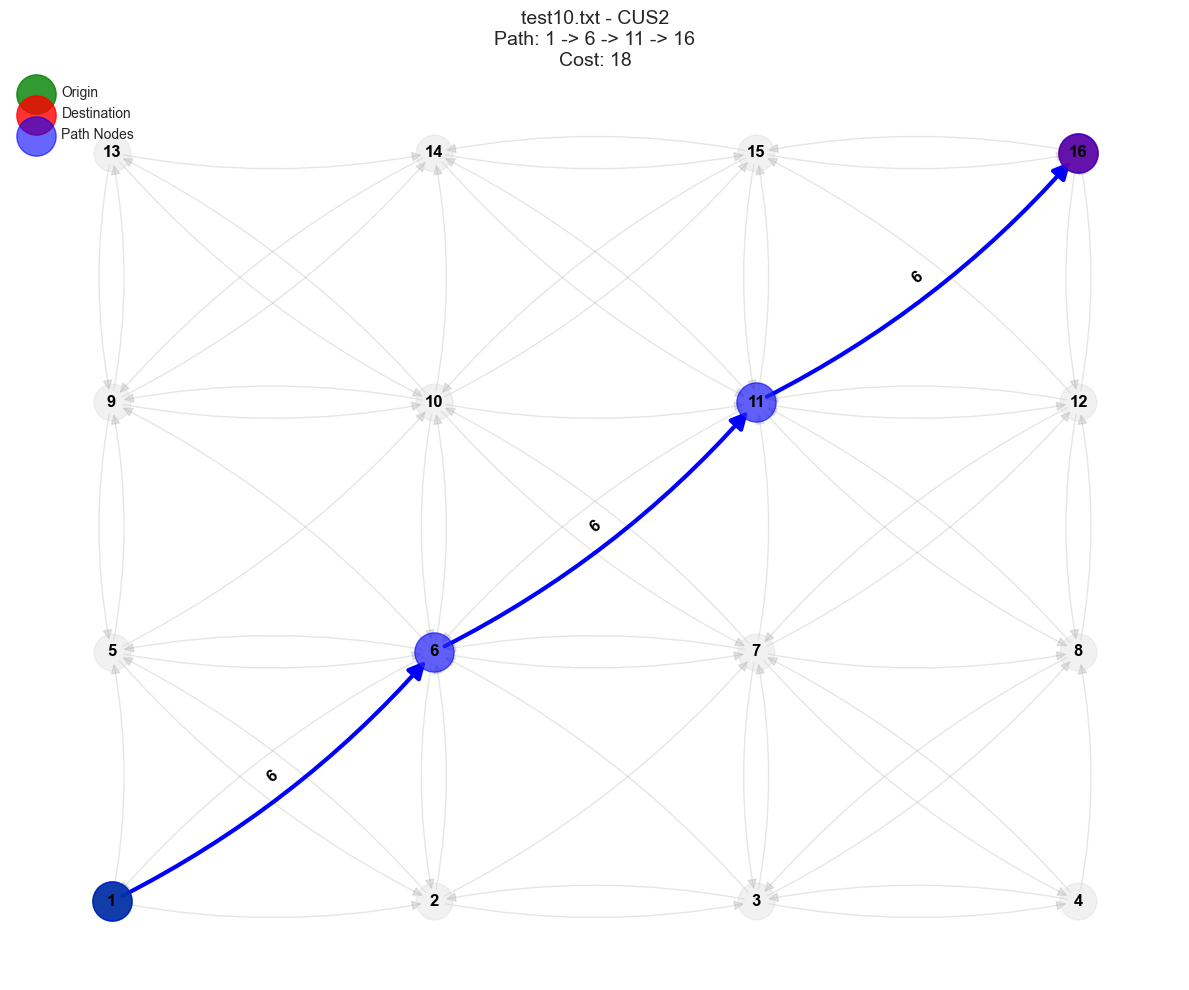

  Running on: test11.txt
Loaded graph with 16 nodes, 80 edges
Origin: 1, Destinations: [16]
    Success! Goal: 16, Nodes created: 7, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test11.txt_CUS2_path.png


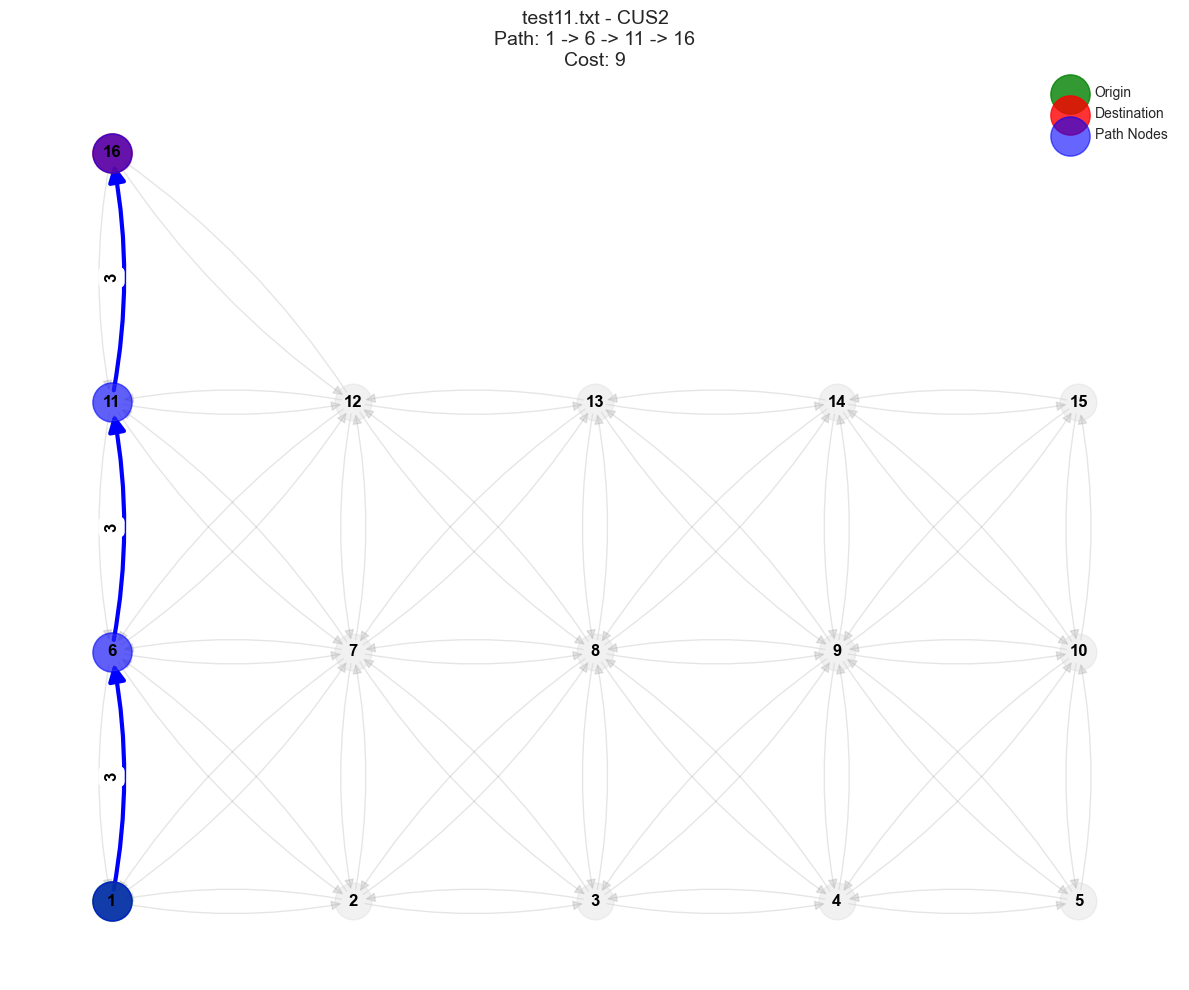

  Running on: test12.txt
Loaded graph with 5 nodes, 7 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 7, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test12.txt_CUS2_path.png


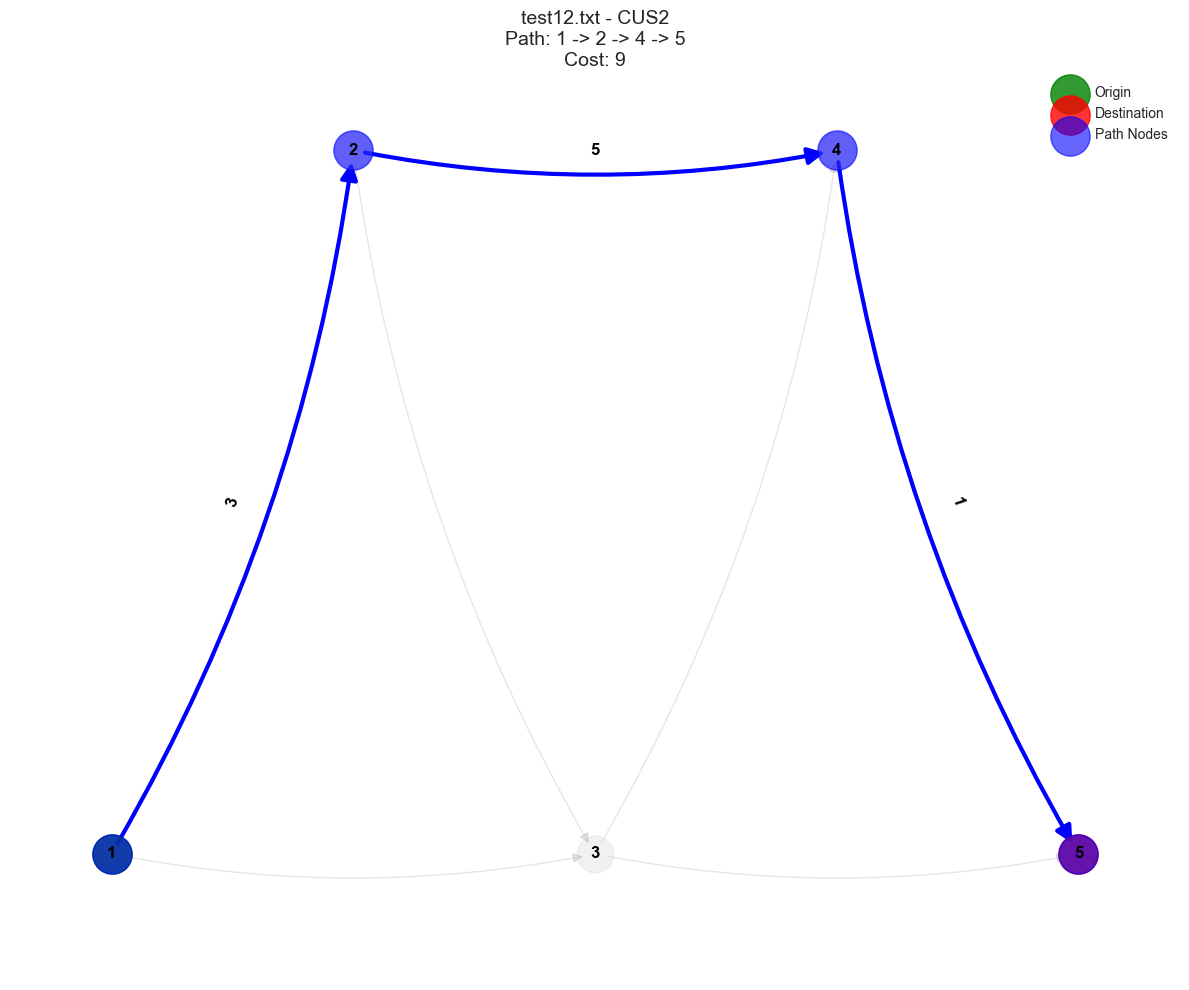

  Running on: test2.txt
Loaded graph with 6 nodes, 11 edges
Origin: 1, Destinations: [4, 5, 6]
    Success! Goal: 5, Nodes created: 5, Path length: 3, Cost: 7.00
Saved path visualization to test_paths/test2.txt_CUS2_path.png


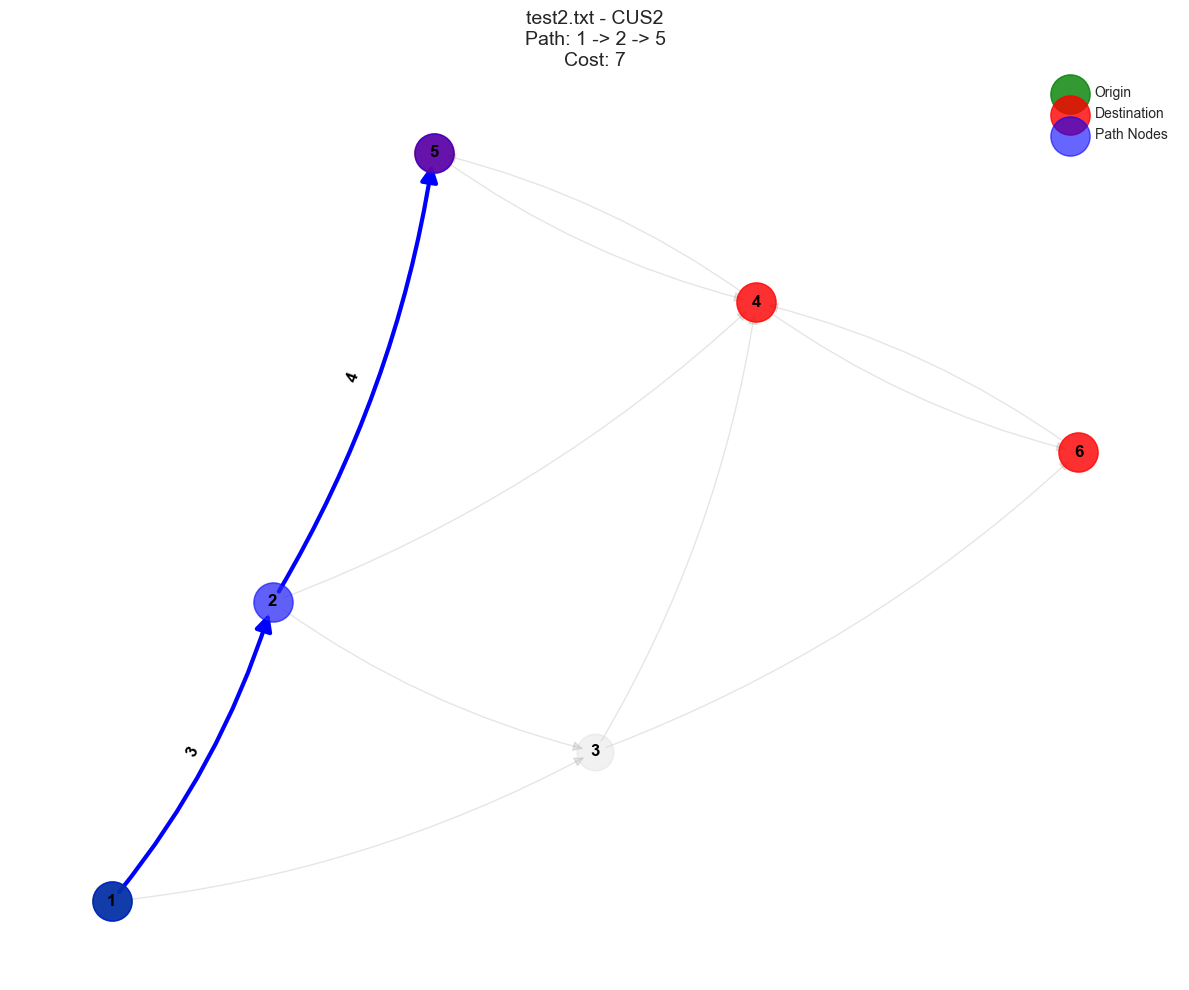

  Running on: test3.txt
Loaded graph with 6 nodes, 7 edges
Origin: 1, Destinations: [6]
    Success! Goal: 6, Nodes created: 5, Path length: 4, Cost: 9.00
Saved path visualization to test_paths/test3.txt_CUS2_path.png


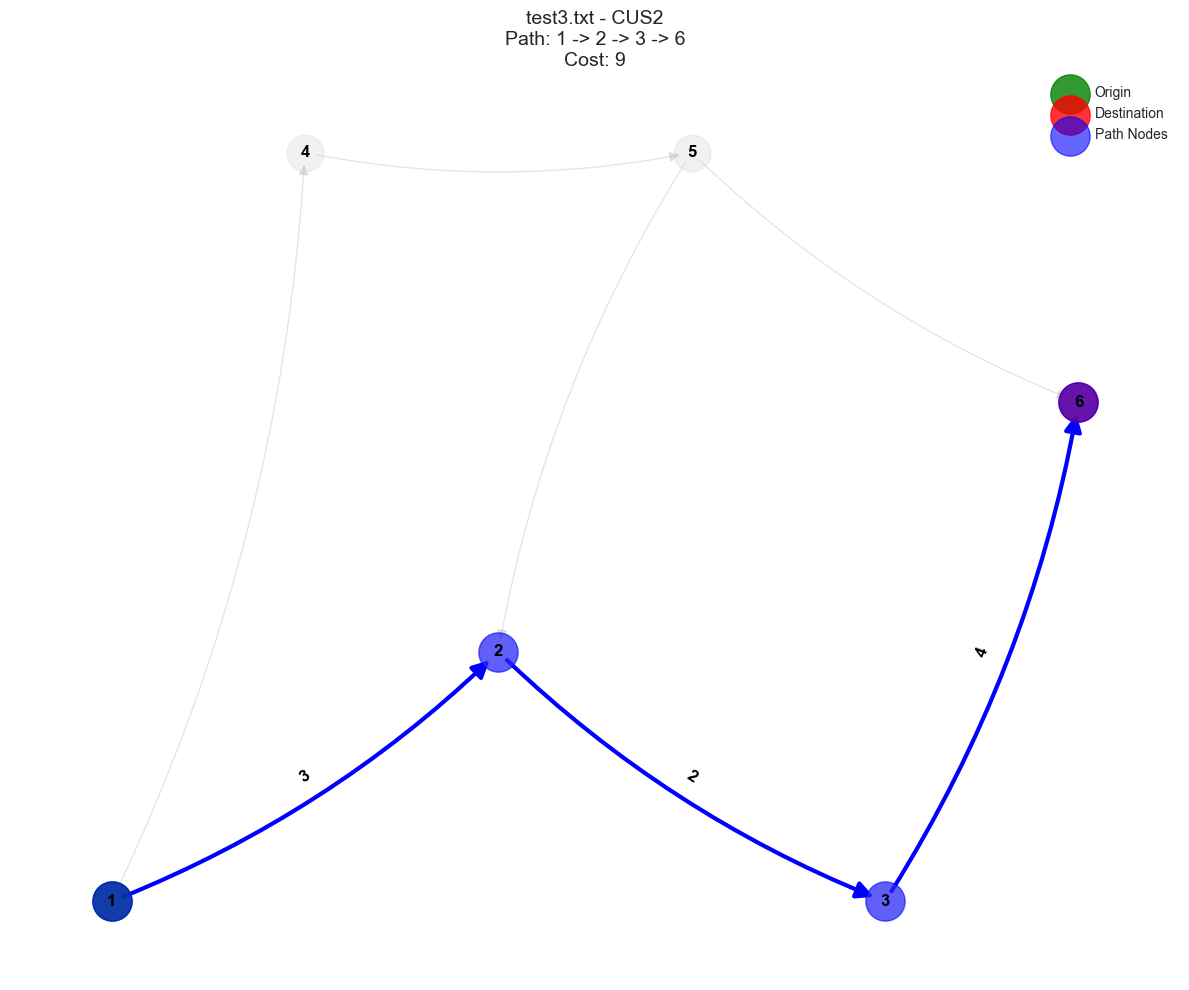

  Running on: test4.txt
Loaded graph with 6 nodes, 4 edges
Origin: 1, Destinations: [6]
    No solution found
  Running on: test5.txt
Loaded graph with 20 nodes, 39 edges
Origin: 1, Destinations: [20]
    Success! Goal: 20, Nodes created: 6, Path length: 3, Cost: 9.00
Saved path visualization to test_paths/test5.txt_CUS2_path.png


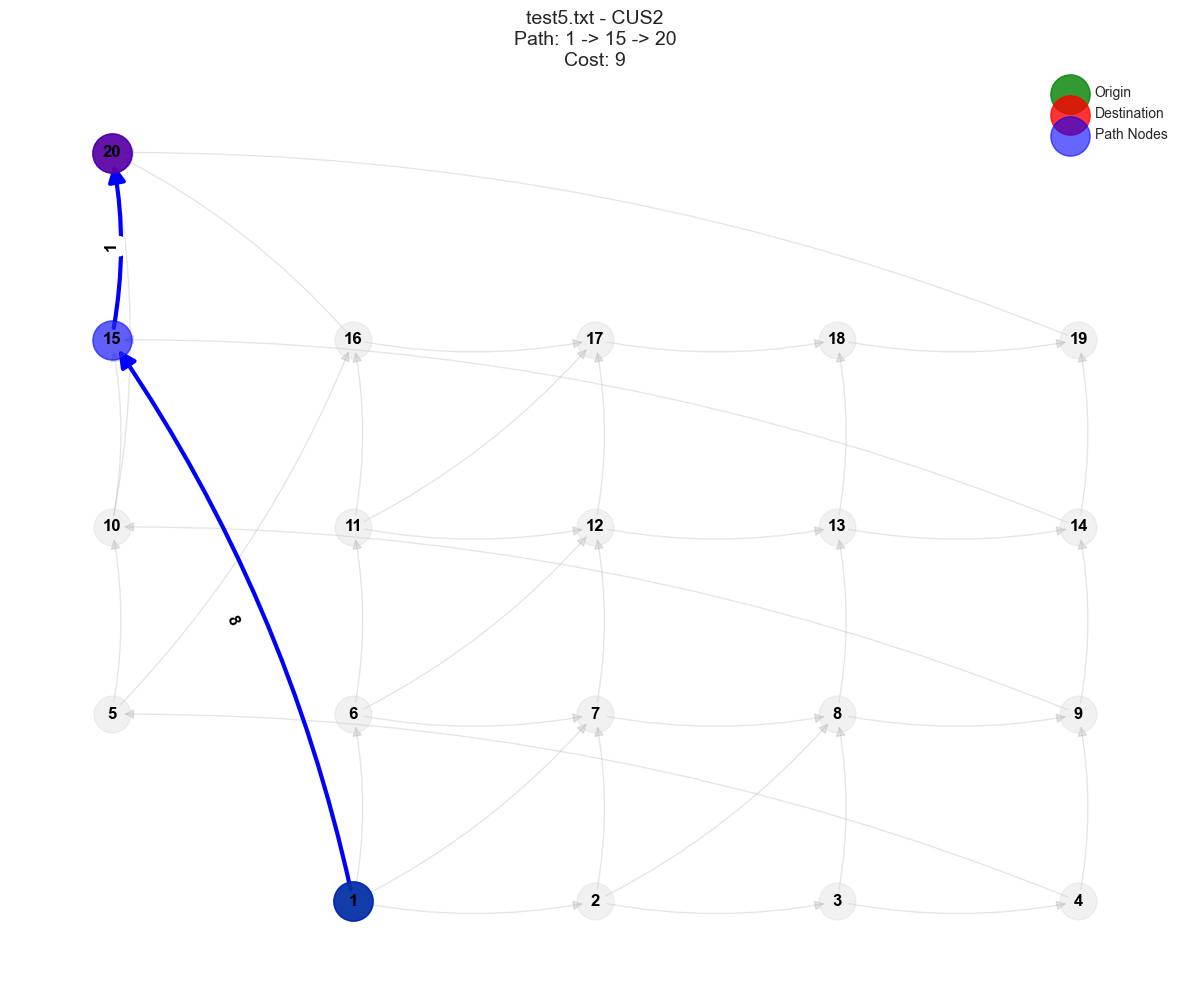

  Running on: test6.txt
Loaded graph with 6 nodes, 6 edges
Origin: 1, Destinations: [5, 6]
    Success! Goal: 6, Nodes created: 6, Path length: 4, Cost: 6.00
Saved path visualization to test_paths/test6.txt_CUS2_path.png


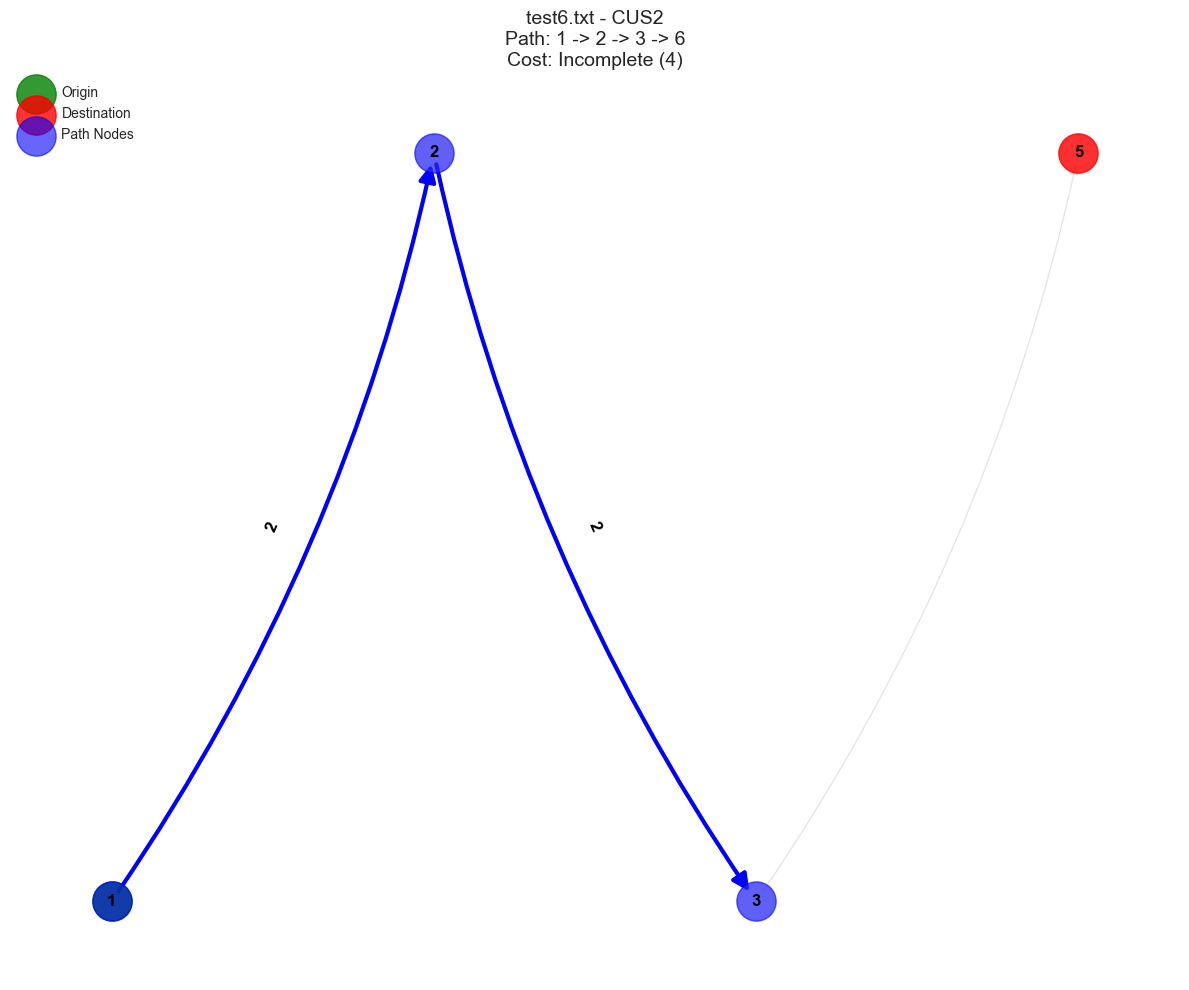

  Running on: test7.txt
Loaded graph with 4 nodes, 2 edges
Origin: 1, Destinations: [4]
    No solution found
  Running on: test8.txt
Loaded graph with 1 nodes, 0 edges
Origin: 1, Destinations: [1]
    Success! Goal: 1, Nodes created: 1, Path length: 1, Cost: 0.00
Saved path visualization to test_paths/test8.txt_CUS2_path.png


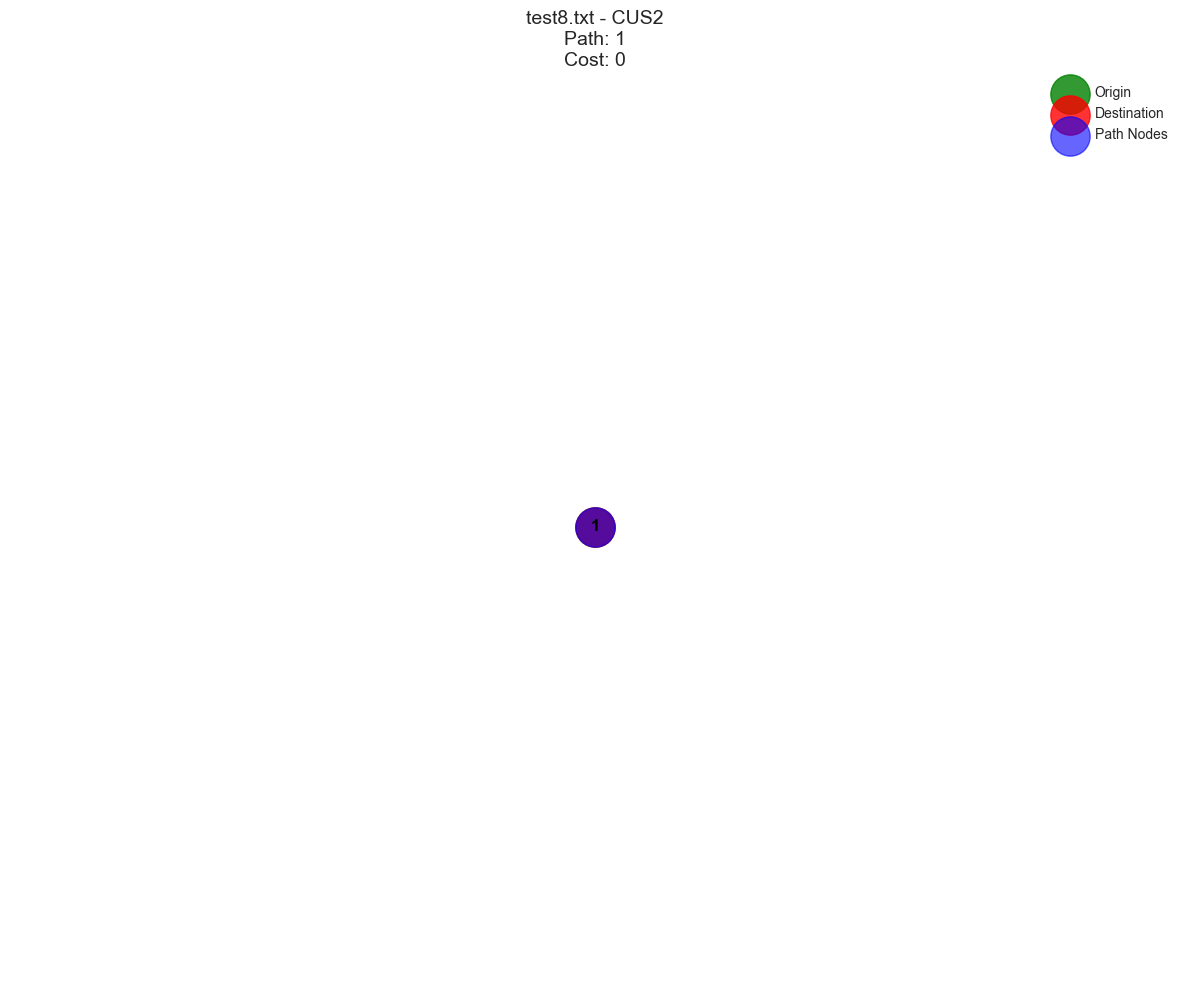

  Running on: test9.txt
Loaded graph with 5 nodes, 5 edges
Origin: 1, Destinations: [5]
    Success! Goal: 5, Nodes created: 5, Path length: 4, Cost: 4.00
Saved path visualization to test_paths/test9.txt_CUS2_path.png


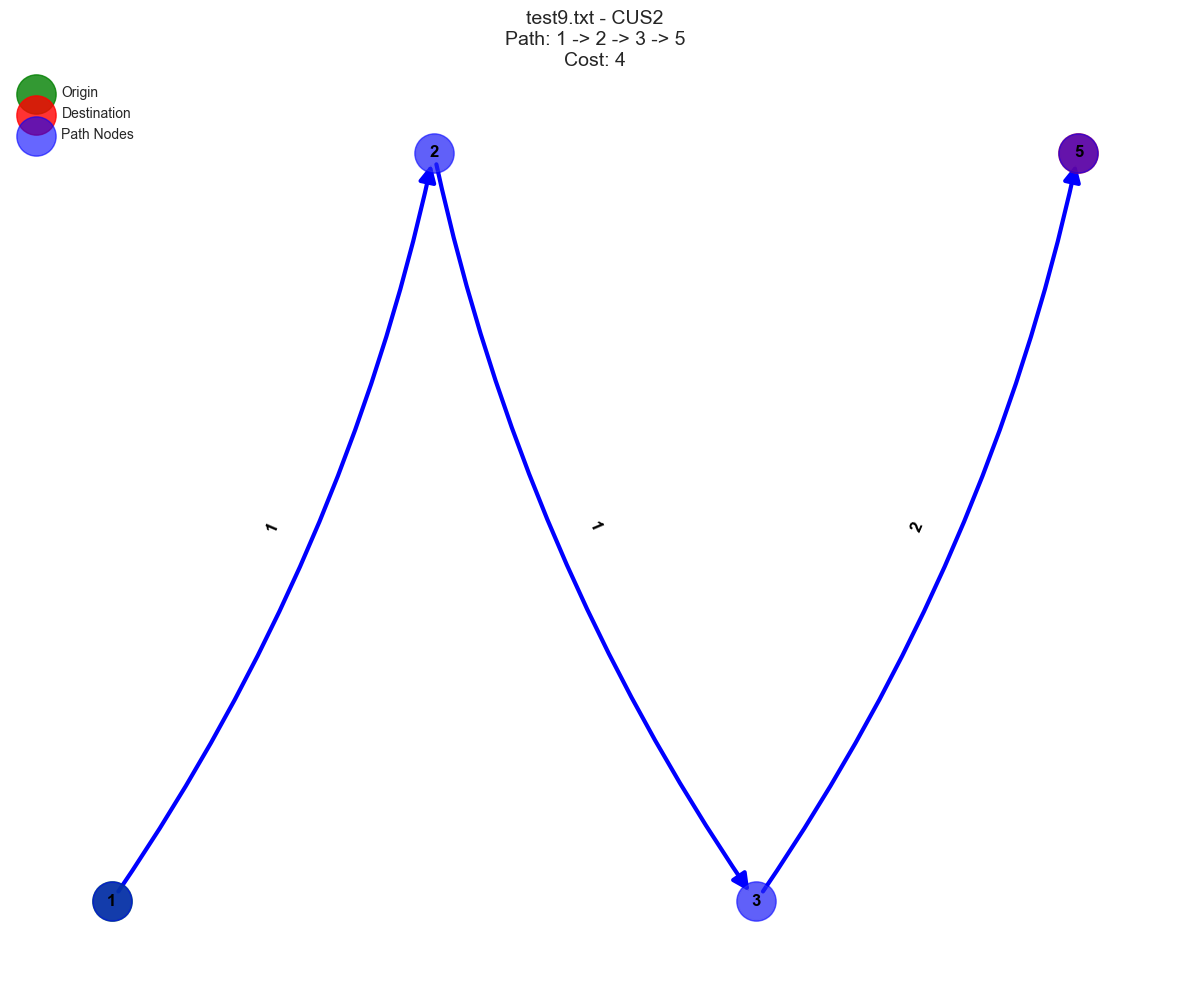


===== ALGORITHM PERFORMANCE REPORT =====

===== SUMMARY STATISTICS =====

Tested on 12 files.

Success Rate:
  DFS: 10/12 (83.3%)
  BFS: 10/12 (83.3%)
  GBFS: 10/12 (83.3%)
  AS: 10/12 (83.3%)
  CUS1: 10/12 (83.3%)
  CUS2: 10/12 (83.3%)

Average Nodes Created (on success):
  DFS: 11.10 (min: 1, max: 34)
  BFS: 6.90 (min: 1, max: 16)
  GBFS: 5.80 (min: 1, max: 13)
  AS: 7.20 (min: 1, max: 16)
  CUS1: 23.30 (min: 1, max: 102)
  CUS2: 6.10 (min: 1, max: 13)

Average Path Length (on success):
  DFS: 5.20 (min: 1, max: 11)
  BFS: 3.30 (min: 1, max: 4)
  GBFS: 3.30 (min: 1, max: 4)
  AS: 3.60 (min: 1, max: 5)
  CUS1: 3.30 (min: 1, max: 4)
  CUS2: 3.40 (min: 1, max: 4)

Average Path Cost (on success):
  DFS: 13.40 (min: 0.00, max: 44.00)
  BFS: 8.70 (min: 0.00, max: 18.00)
  GBFS: 8.70 (min: 0.00, max: 18.00)
  AS: 7.70 (min: 0.00, max: 18.00)
  CUS1: 8.70 (min: 0.00, max: 18.00)
  CUS2: 8.10 (min: 0.00, max: 18.00)

Average Execution Time (seconds, total):
  DFS: 0.844465 (Successful min: 0

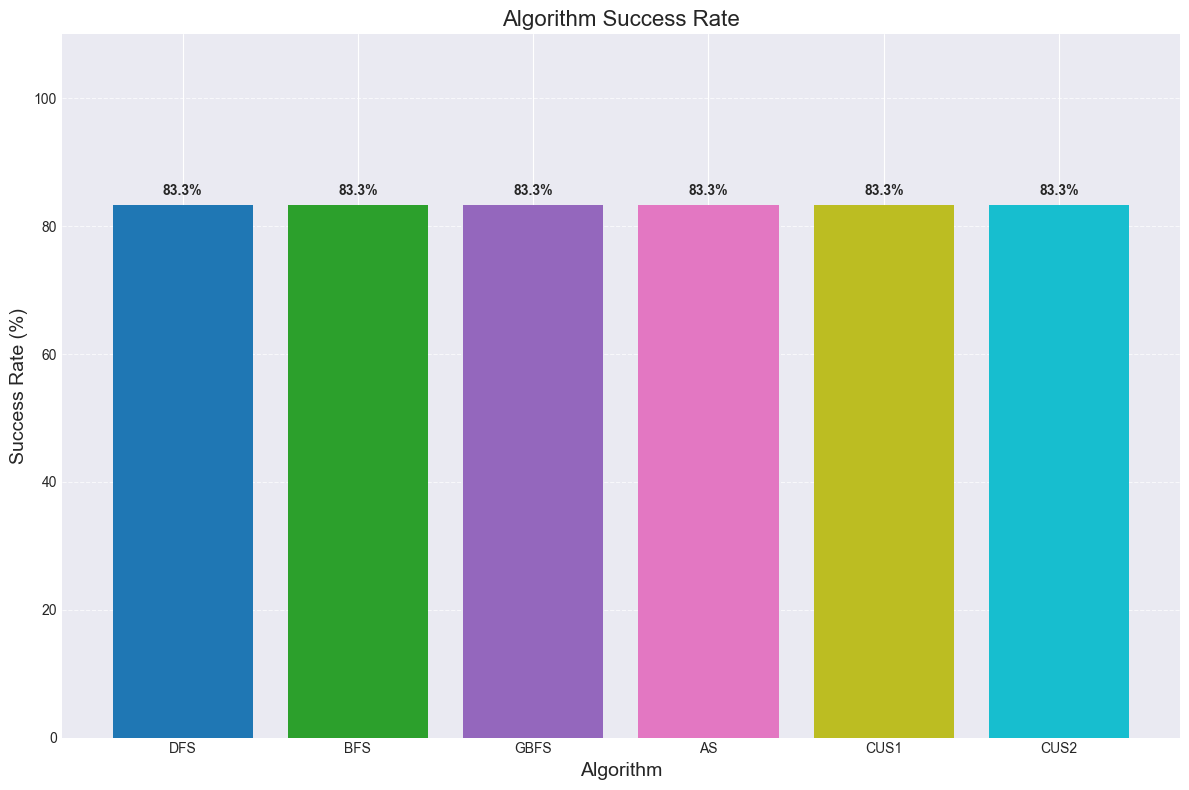

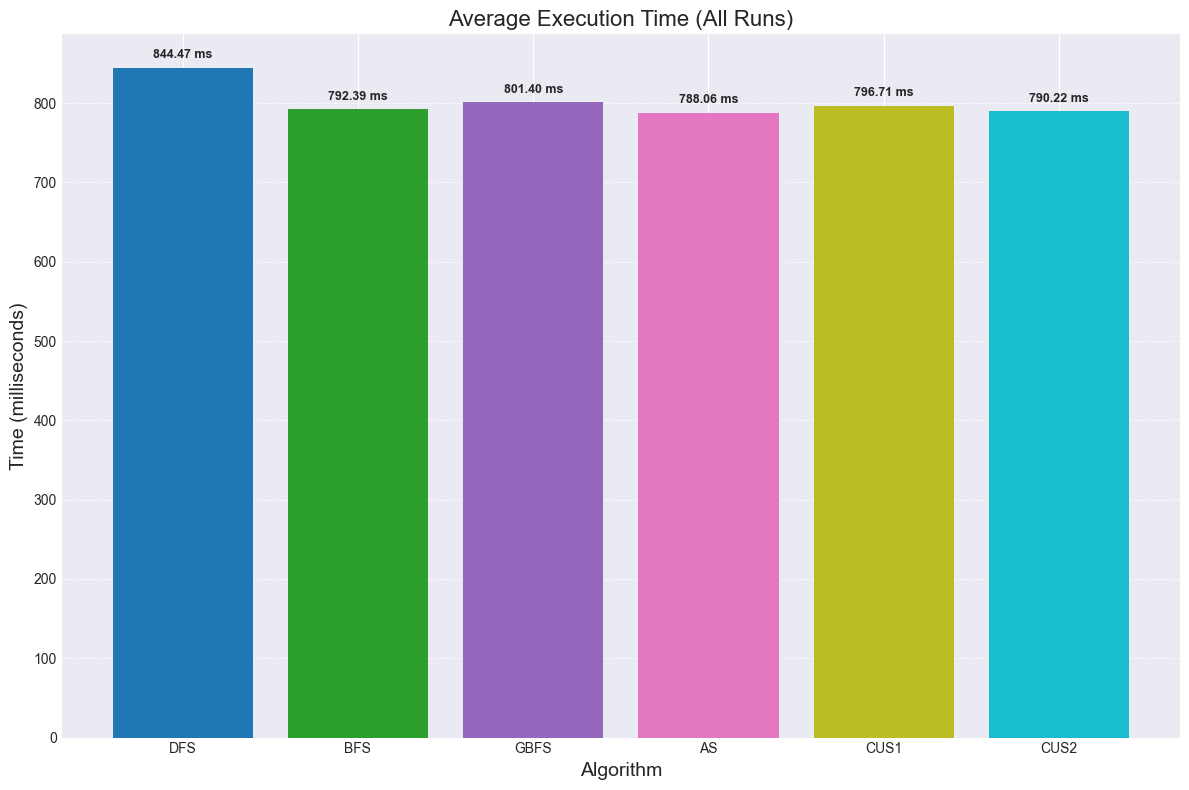

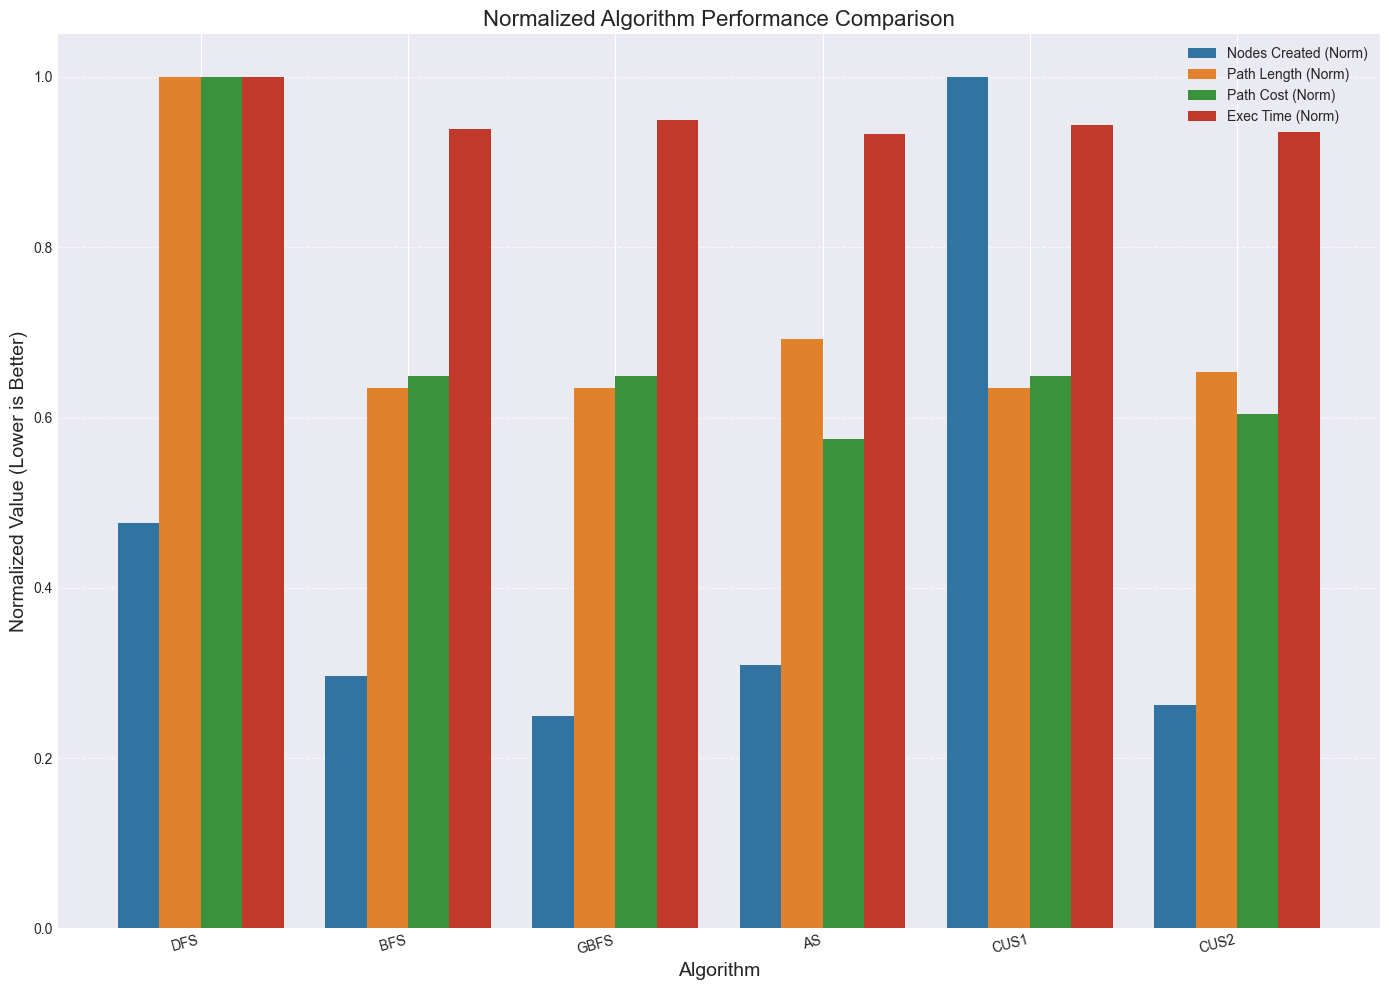

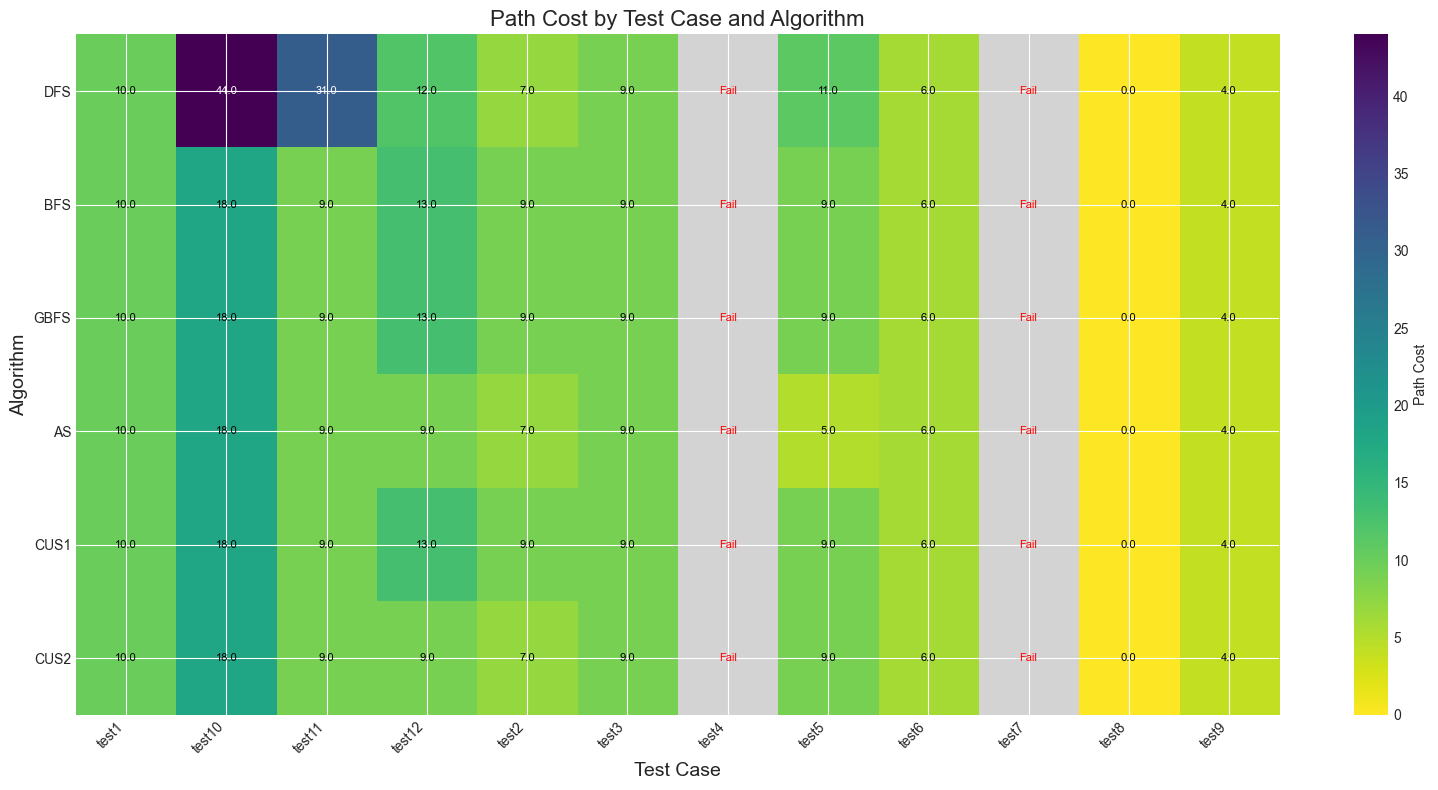


Generated performance report: test_plots\performance_report.txt
Generated plots in directory: test_plots


: 

In [ ]:
# Execute the test runner function
run_tests()